# This is the notebook for Submission to the Oxygen Credit Score Assessment

In [ ]:
# Install all necessary libraries



# Import only the required libraries

In [64]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import missingno as msno
from scipy.stats import chi2_contingency
from collections import defaultdict


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import xgboost as xgb



In [3]:
project_data_folder = "/content/drive/MyDrive/Data Science Projects/Oxygen-Credit-Scoring/assets"
model_folder =  "/content/drive/MyDrive/Data Science Projects/Oxygen-Credit-Scoring/models"

# Read the data

In [5]:
credit_data = pd.read_csv(project_data_folder + "/GermanCredit.csv")
credit_data = credit_data.iloc[:, 1:]

# Understand the Data

In [6]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   checking_balance      606 non-null    float64
 1   months_loan_duration  1000 non-null   int64  
 2   credit_history        1000 non-null   object 
 3   purpose               1000 non-null   object 
 4   amount                1000 non-null   int64  
 5   savings_balance       817 non-null    float64
 6   employment_length     938 non-null    object 
 7   installment_rate      1000 non-null   int64  
 8   personal_status       690 non-null    object 
 9   other_debtors         1000 non-null   object 
 10  residence_history     870 non-null    object 
 11  property              1000 non-null   object 
 12  age                   1000 non-null   int64  
 13  installment_plan      1000 non-null   object 
 14  housing               1000 non-null   object 
 15  existing_credits      

In [7]:
credit_data.describe()

checking_balance  months_loan_duration        amount  savings_balance  \
count        606.000000           1000.000000   1000.000000       817.000000   
mean          97.245875             20.903000   3271.258000       781.570379   
std          206.923583             12.058814   2822.736876      3016.983785   
min          -50.000000              4.000000    250.000000         0.000000   
25%          -23.000000             12.000000   1365.500000        31.000000   
50%           24.000000             18.000000   2319.500000        64.000000   
75%          131.750000             24.000000   3972.250000       128.000000   
max          999.000000             72.000000  18424.000000     19972.000000   

       installment_rate          age  existing_credits      default  \
count       1000.000000  1000.000000       1000.000000  1000.000000   
mean           2.973000    35.546000          1.407000     0.300000   
std            1.118715    11.375469          0.577654     0.458487   
min            1.000000    19.000000          1.000000     0.000000   
25%            2.000000    27.000000          1.000000     0.000000   
50%            3.000000    33.000000          1.000000     0.000000   
75%            4.000000    42.000000          2.000000     1.000000   
max            4.000000    75.000000          4.000000     1.000000   

        dependents     telephone  
count  1000.000000  4.040000e+02  
mean      1.155000  2.344914e+09  
std       0.362086  3.008193e+06  
min       1.000000  2.340000e+09  
25%       1.000000  2.342211e+09  
50%       1.000000  2.344804e+09  
75%       1.000000  2.347731e+09  
max       2.000000  2.349994e+09

# Perform Exploratory Data Analysis

In [8]:
df = credit_data.copy()

## Understanding the Target - Default
Question: What do we want to predict?

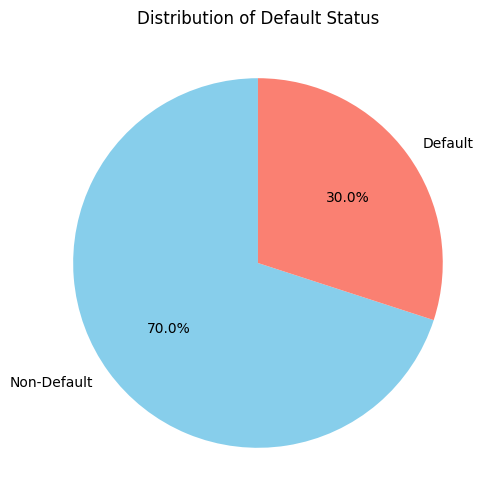

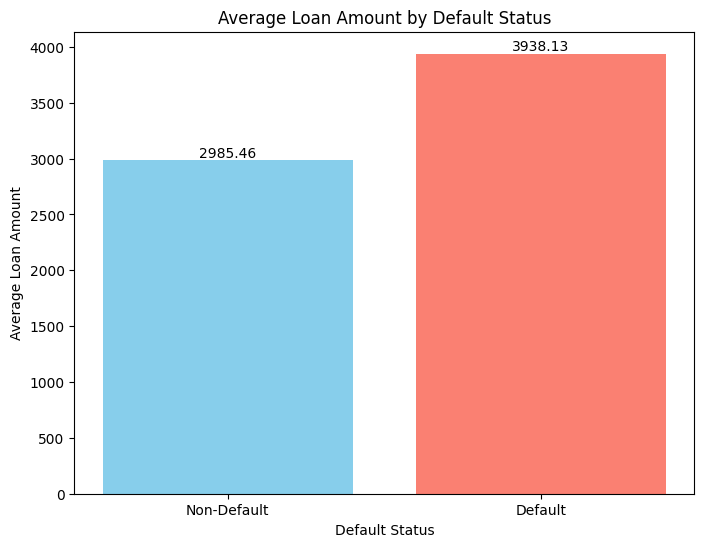


--- Plots Generated ---


In [9]:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
# 2. Plot 1: Pie chart of the default column
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
plt.figure(figsize=(8, 6))
default_counts = df['default'].value_counts()

# Optional: Create more descriptive labels if default is 0/1
# Map 0 to 'Non-Default' and 1 to 'Default' (adjust if your values differ)
labels_map = {0: 'Non-Default', 1: 'Default'}
labels = default_counts.index.map(lambda x: labels_map.get(x, x)) # Use map value or original index if not found

plt.pie(default_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribution of Default Status')
plt.ylabel('') # Hide the default 'default' label on the y-axis for pie charts
plt.show()


# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
# 3. Plot 2: Bar chart of average loan amount by default category
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
plt.figure(figsize=(8, 6))
avg_amount_by_default = df.groupby('default')['amount'].mean()

# Use the same descriptive labels as before
bar_labels = avg_amount_by_default.index.map(lambda x: labels_map.get(x, x))

bars = plt.bar(bar_labels, avg_amount_by_default, color=['skyblue', 'salmon'])
plt.xlabel('Default Status')
plt.ylabel('Average Loan Amount')
plt.title('Average Loan Amount by Default Status')

# Optional: Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center') # Adjust formatting as needed

plt.show()

print("\n--- Plots Generated ---")

## Getting the Applicants Demographics and Stability Profile
Who are our Customers?


--- Age Analysis ---
Descriptive Statistics for Age:
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64


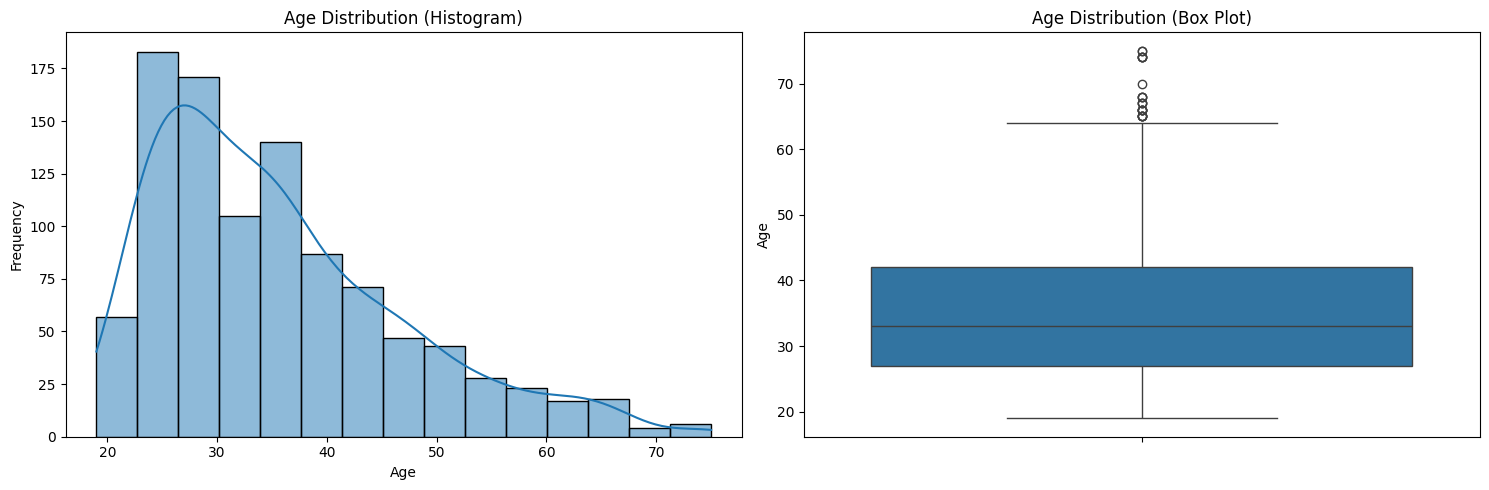


--- Categorical Feature Analysis (Counts) ---


<ipython-input-11-bf4d1f5bbb45>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_index, y=counts.values, palette='viridis', order=plot_index) # Use plot_index for labels


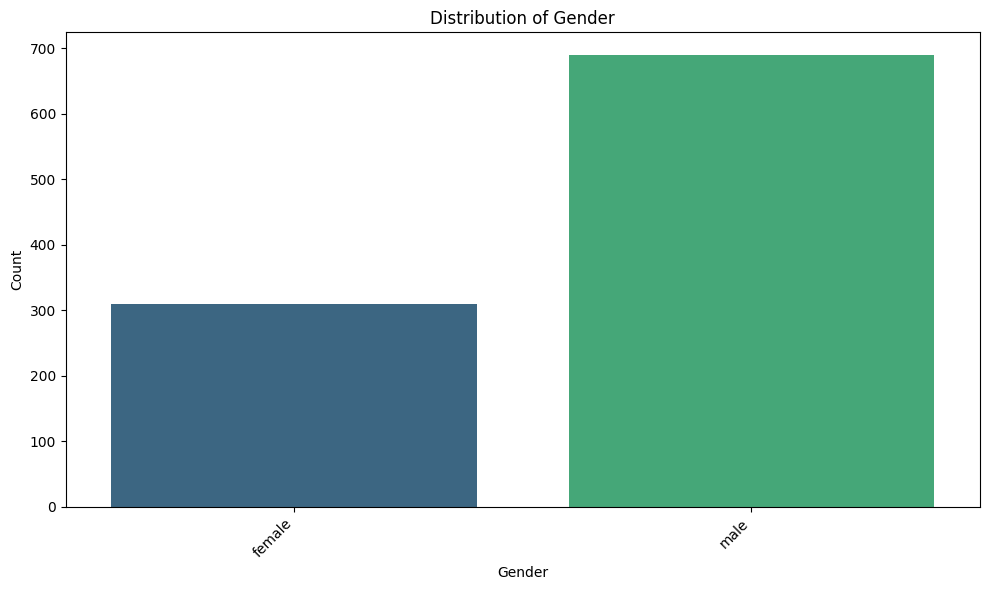


Value Counts for gender (including missing):
gender
female    310
male      690
Name: count, dtype: int64


<ipython-input-11-bf4d1f5bbb45>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_index, y=counts.values, palette='viridis', order=plot_index) # Use plot_index for labels


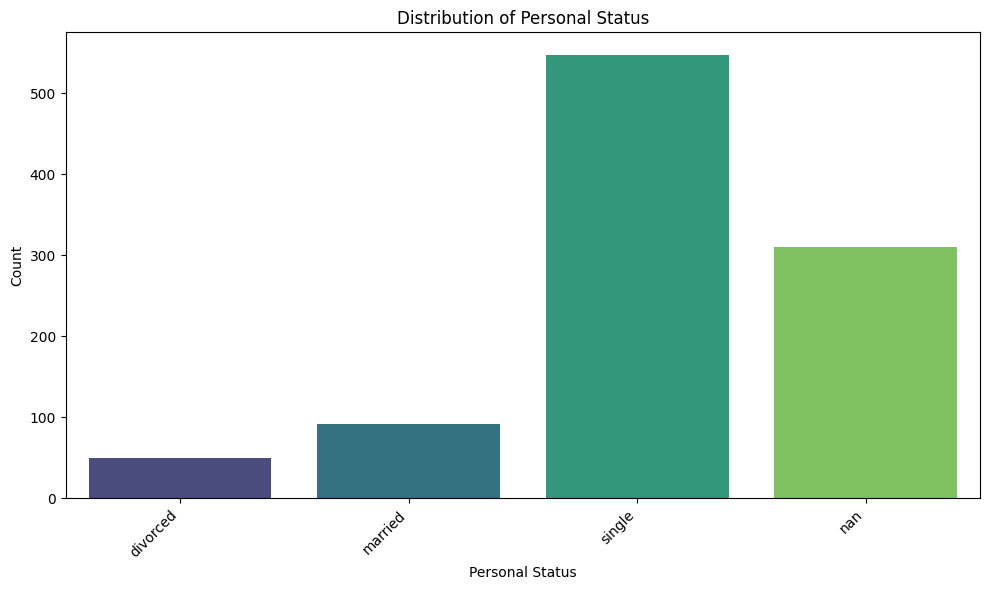


Value Counts for personal_status (including missing):
personal_status
divorced     50
married      92
single      548
NaN         310
Name: count, dtype: int64


<ipython-input-11-bf4d1f5bbb45>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_index, y=counts.values, palette='viridis', order=plot_index) # Use plot_index for labels


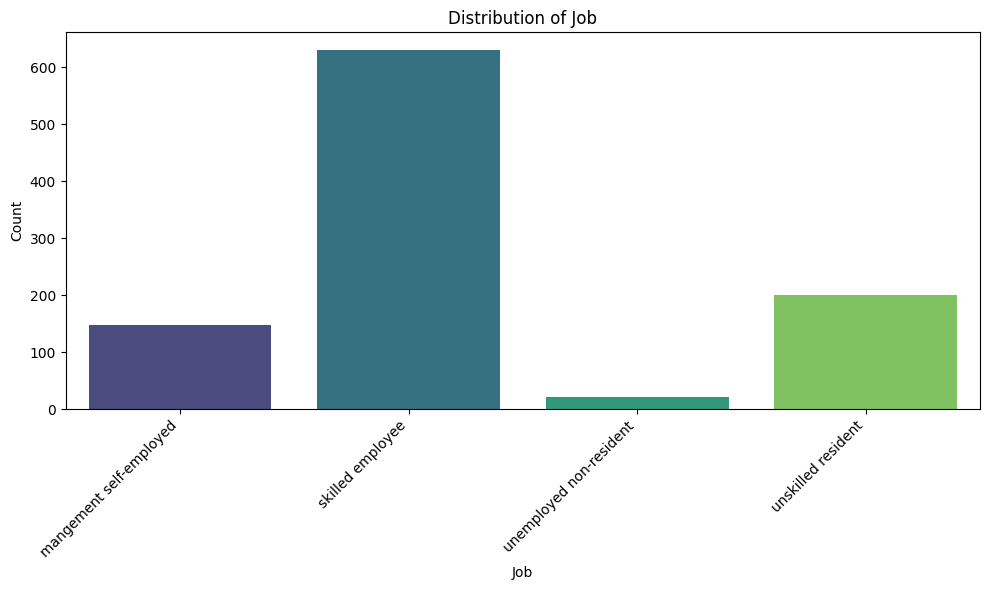


Value Counts for job (including missing):
job
mangement self-employed    148
skilled employee           630
unemployed non-resident     22
unskilled resident         200
Name: count, dtype: int64


<ipython-input-11-bf4d1f5bbb45>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_index, y=counts.values, palette='viridis', order=plot_index) # Use plot_index for labels


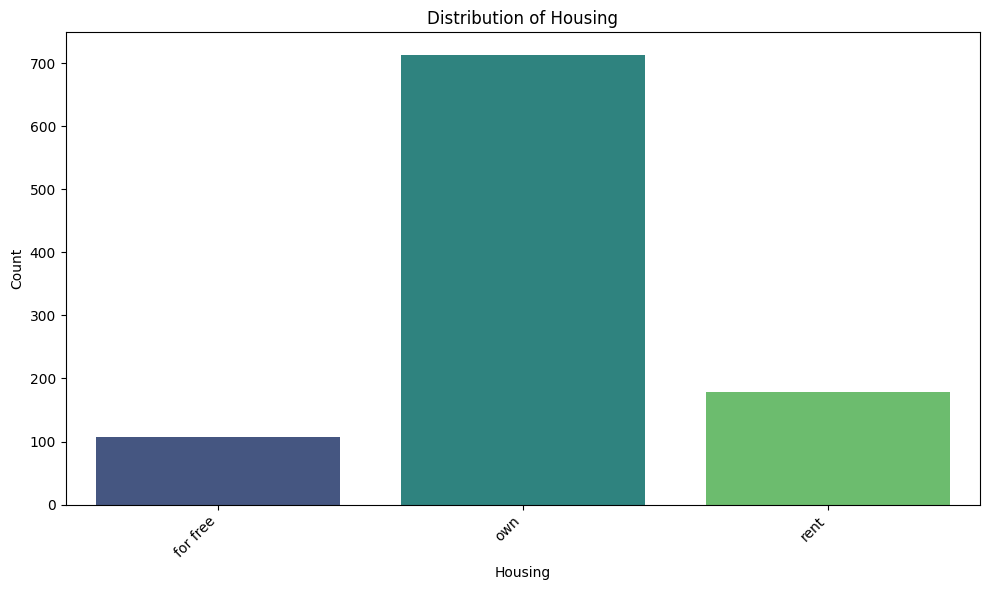

<ipython-input-11-bf4d1f5bbb45>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_index, y=counts.values, palette='viridis', order=plot_index) # Use plot_index for labels



Value Counts for housing (including missing):
housing
for free    108
own         713
rent        179
Name: count, dtype: int64


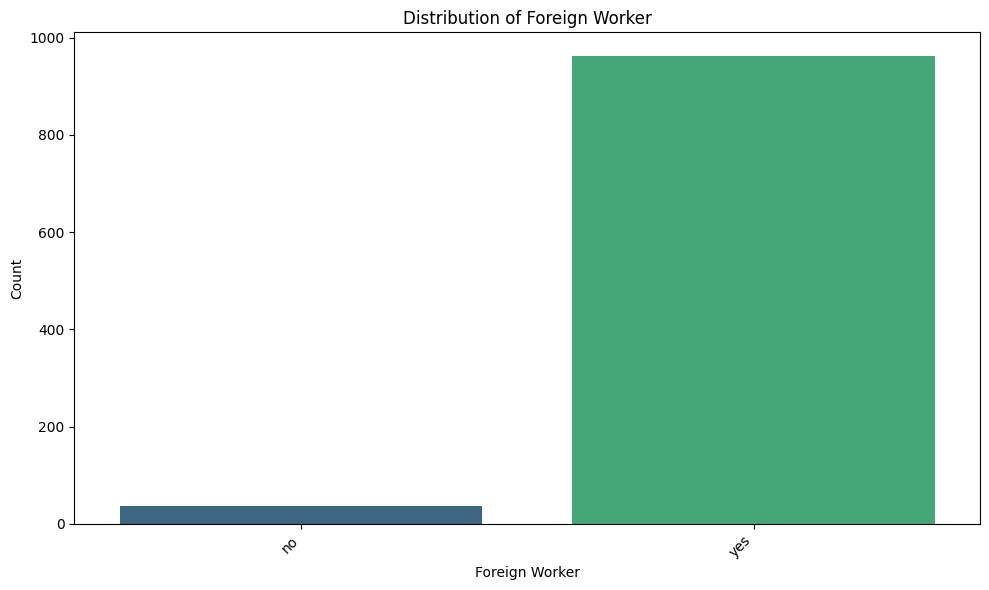


Value Counts for foreign_worker (including missing):
foreign_worker
no      37
yes    963
Name: count, dtype: int64

--- Duration/Stability Feature Analysis (Counts) ---
Note: These features likely represent duration or stability.


<ipython-input-11-bf4d1f5bbb45>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_index, y=counts.values, palette='magma', order=plot_index)


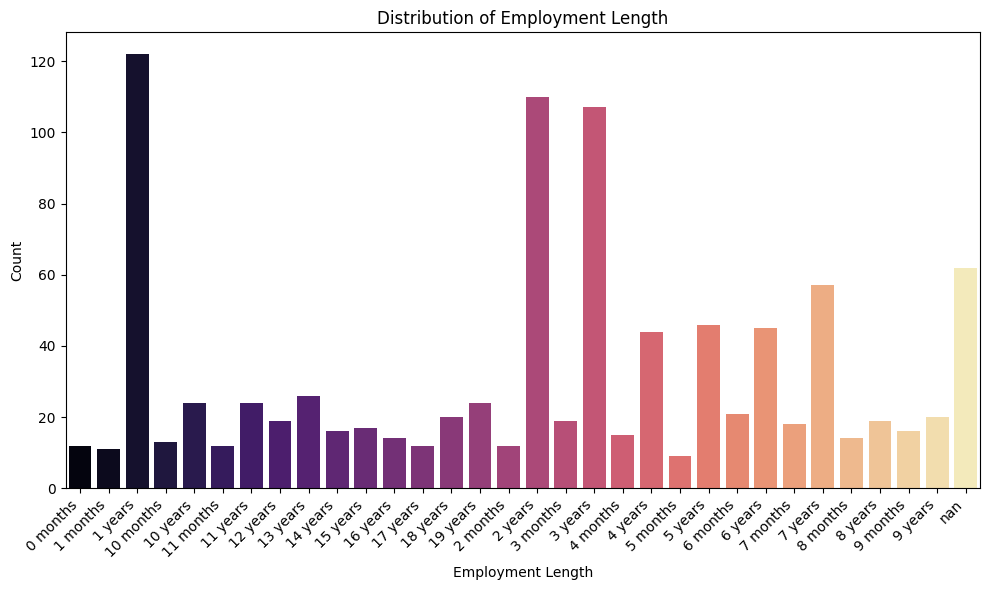


Value Counts for employment_length (including missing):
employment_length
0 months      12
1 months      11
1 years      122
10 months     13
10 years      24
11 months     12
11 years      24
12 years      19
13 years      26
14 years      16
15 years      17
16 years      14
17 years      12
18 years      20
19 years      24
2 months      12
2 years      110
3 months      19
3 years      107
4 months      15
4 years       44
5 months       9
5 years       46
6 months      21
6 years       45
7 months      18
7 years       57
8 months      14
8 years       19
9 months      16
9 years       20
NaN           62
Name: count, dtype: int64


<ipython-input-11-bf4d1f5bbb45>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_index, y=counts.values, palette='magma', order=plot_index)


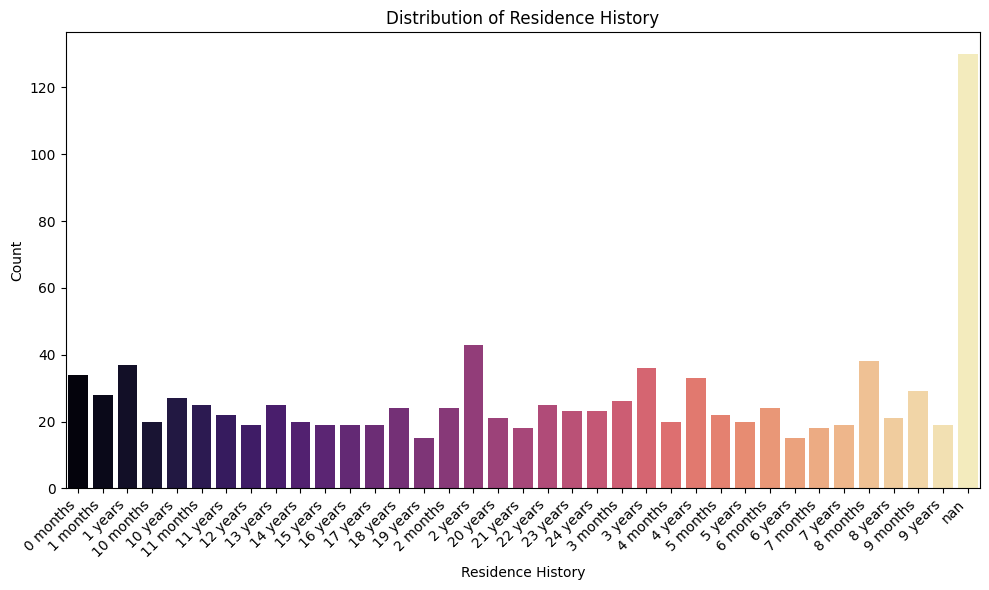


Value Counts for residence_history (including missing):
residence_history
0 months      34
1 months      28
1 years       37
10 months     20
10 years      27
11 months     25
11 years      22
12 years      19
13 years      25
14 years      20
15 years      19
16 years      19
17 years      19
18 years      24
19 years      15
2 months      24
2 years       43
20 years      21
21 years      18
22 years      25
23 years      23
24 years      23
3 months      26
3 years       36
4 months      20
4 years       33
5 months      22
5 years       20
6 months      24
6 years       15
7 months      18
7 years       19
8 months      38
8 years       21
9 months      29
9 years       19
NaN          130
Name: count, dtype: int64

--- Telephone Feature Analysis (Missing Data) ---
Total entries: 1000
Missing 'telephone' entries: 596
Percentage of missing 'telephone' entries: 59.60%


<ipython-input-11-bf4d1f5bbb45>:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=telephone_status_counts.index, y=telephone_status_counts.values, palette='coolwarm')


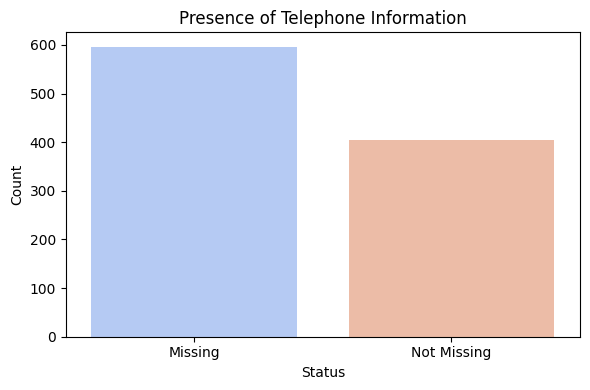


--- Analysis Complete ---


In [11]:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
# Analysis 1: Age (Histogram, Box Plot, describe())
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
print("\n--- Age Analysis ---")
print("Descriptive Statistics for Age:")
print(df['age'].describe())

# Plotting Age distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Create a figure with 2 subplots

# Histogram
sns.histplot(df['age'], bins=15, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution (Histogram)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Box Plot
sns.boxplot(y=df['age'], ax=axes[1])
axes[1].set_title('Age Distribution (Box Plot)')
axes[1].set_ylabel('Age')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()


# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
# Analysis 2: Categorical Features (Gender, Personal Status, Job, Housing, Foreign Worker)
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
print("\n--- Categorical Feature Analysis (Counts) ---")
categorical_cols_1 = ['gender', 'personal_status', 'job', 'housing', 'foreign_worker']

for col in categorical_cols_1:
    plt.figure(figsize=(10, 6))
    # Use value_counts(dropna=False) to include missing values if any exist in the column
    counts = df[col].value_counts(dropna=False).sort_index() # Sort index for consistent order

    # Map potential NaN index to 'Missing' for plotting
    plot_index = counts.index.astype(str) # Convert index to string to handle potential NaN

    sns.barplot(x=plot_index, y=counts.values, palette='viridis', order=plot_index) # Use plot_index for labels

    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
    plt.tight_layout()
    plt.show()
    print(f"\nValue Counts for {col} (including missing):")
    print(counts)


# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
# Analysis 3: Duration/Stability Features (Employment Length, Residence History)
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
print("\n--- Duration/Stability Feature Analysis (Counts) ---")
print("Note: These features likely represent duration or stability.")
categorical_cols_2 = ['employment_length', 'residence_history']

for col in categorical_cols_2:
    plt.figure(figsize=(10, 6))
    # Use value_counts(dropna=False) to include missing values
    counts = df[col].value_counts(dropna=False).sort_index() # Sort index for consistent order

    # Map potential NaN index to 'Missing' for plotting
    plot_index = counts.index.astype(str) # Convert index to string to handle potential NaN

    sns.barplot(x=plot_index, y=counts.values, palette='magma', order=plot_index)

    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"\nValue Counts for {col} (including missing):")
    print(counts)


# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
# Analysis 4: Telephone (Missing vs. Non-Missing)
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
print("\n--- Telephone Feature Analysis (Missing Data) ---")

# Calculate missing percentage
missing_count = df['telephone'].isnull().sum()
total_count = len(df)
missing_percentage = (missing_count / total_count) * 100
print(f"Total entries: {total_count}")
print(f"Missing 'telephone' entries: {missing_count}")
print(f"Percentage of missing 'telephone' entries: {missing_percentage:.2f}%")

# Create counts for plotting
telephone_status_counts = df['telephone'].isnull().map({True: 'Missing', False: 'Not Missing'}).value_counts()

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=telephone_status_counts.index, y=telephone_status_counts.values, palette='coolwarm')
plt.title('Presence of Telephone Information')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")

Our typical applicant pool looks like this:
A young single male foreign worker, who is a skilled employee and has been working for approximately one year, owns a house, although information on his authorized length of stay and telephone records is not available.


## Getting Applicants Profile - Financial Health

### Who are our customers?


--- Checking/Savings Balance Analysis ---


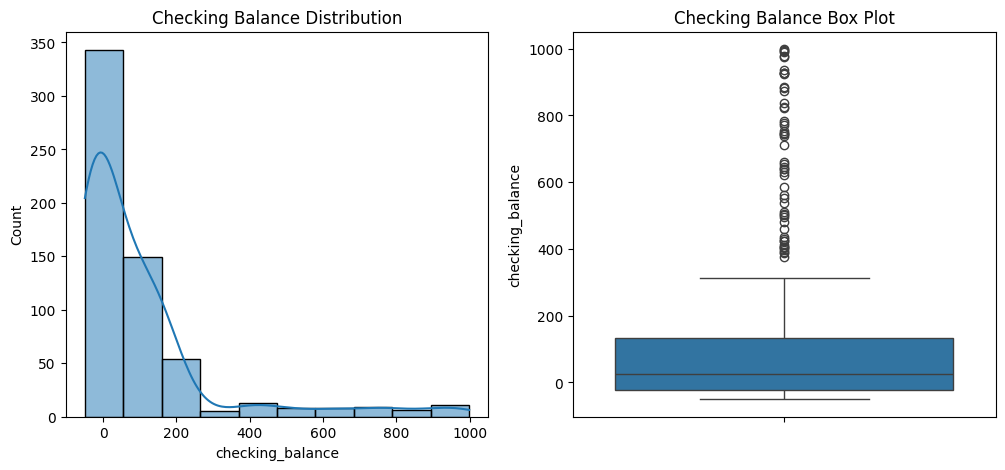


Checking Balance Description (including missing):
count    606.000000
mean      97.245875
std      206.923583
min      -50.000000
25%      -23.000000
50%       24.000000
75%      131.750000
max      999.000000
Name: checking_balance, dtype: float64


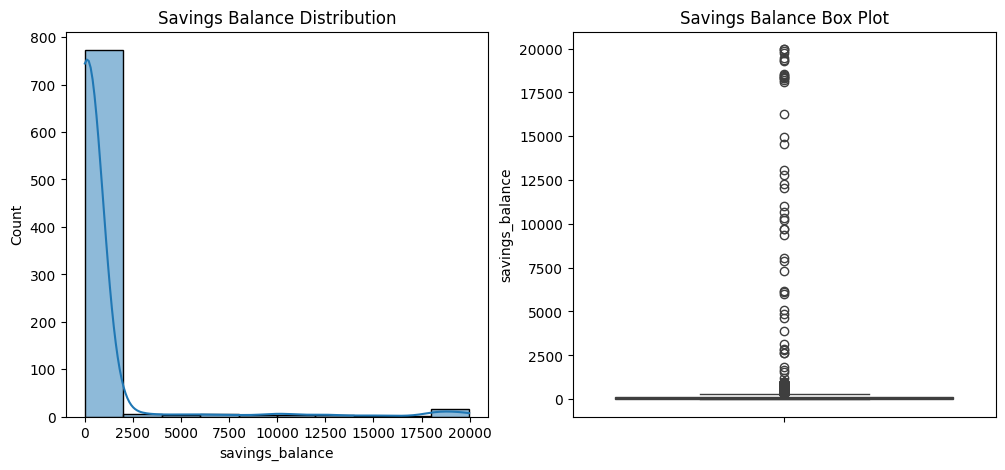

\Savings Balance Description (including missing):
count      817.000000
mean       781.570379
std       3016.983785
min          0.000000
25%         31.000000
50%         64.000000
75%        128.000000
max      19972.000000
Name: savings_balance, dtype: float64

--- Credit History Analysis ---


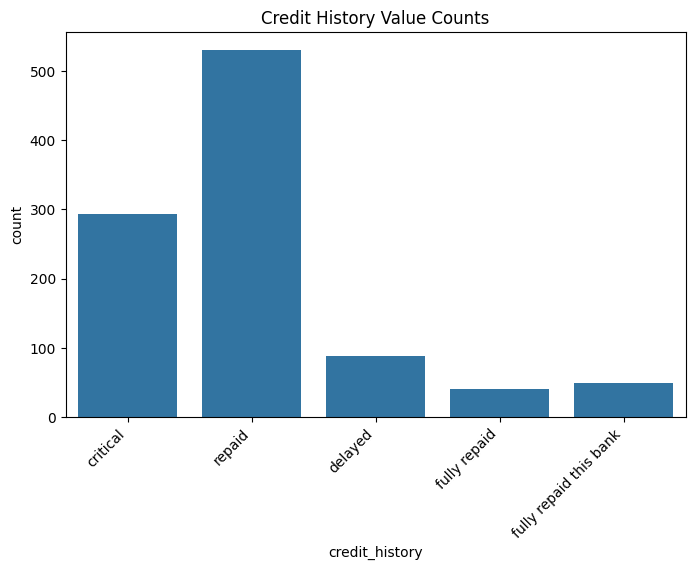


Credit History Value Counts:
credit_history
repaid                    530
critical                  293
delayed                    88
fully repaid this bank     49
fully repaid               40
Name: count, dtype: int64

--- Other Debtors, Property Analysis ---


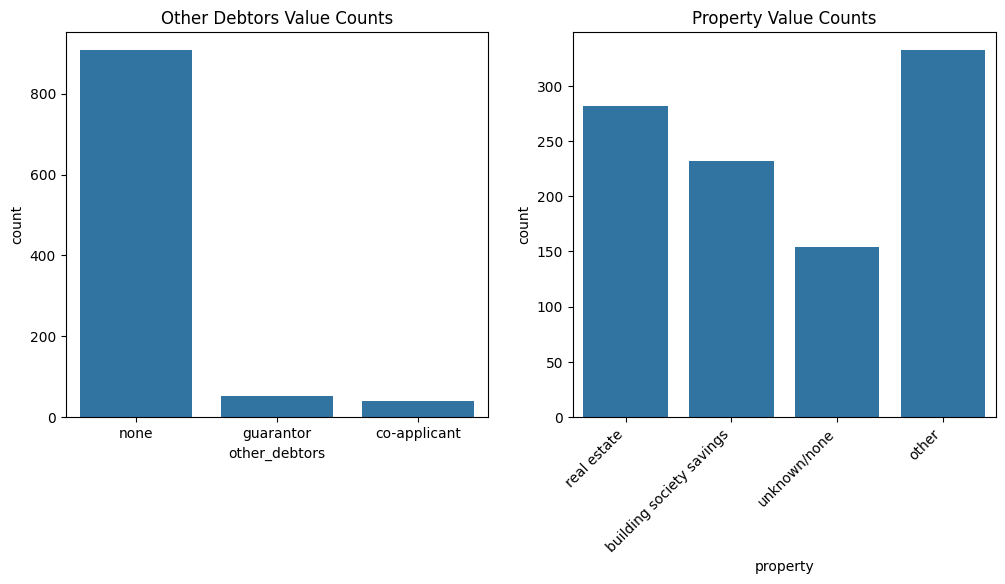


Other Debtors Value Counts:
other_debtors
none            907
guarantor        52
co-applicant     41
Name: count, dtype: int64

Property Value Counts:
property
other                       332
real estate                 282
building society savings    232
unknown/none                154
Name: count, dtype: int64

--- Existing Credits, Dependents Analysis ---


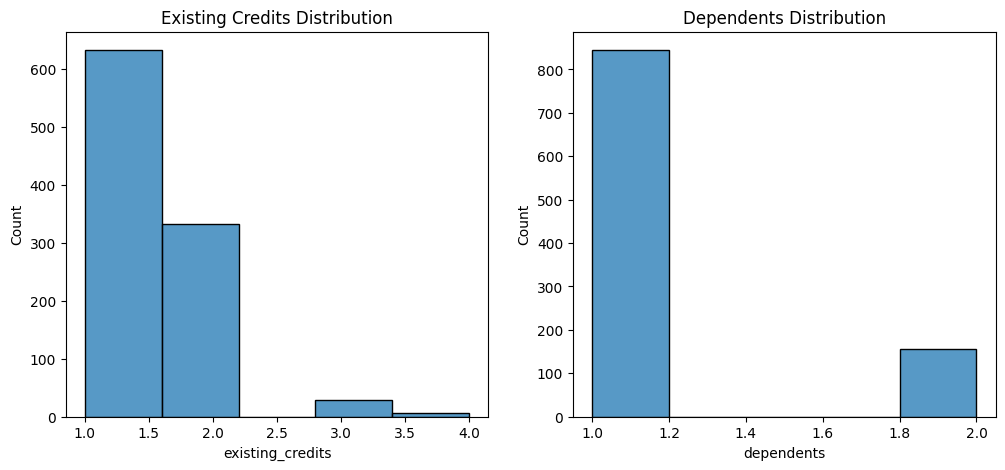


Existing Credits Value Counts:
existing_credits
1    633
2    333
3     28
4      6
Name: count, dtype: int64

Dependents Value Counts:
dependents
1    845
2    155
Name: count, dtype: int64

--- Story Point ---

Applicants show a range of financial standings based on available balance data
[mention typical ranges or skewness]. Credit history varies, with
[mention common categories] being prevalent. Information on property ownership
and other debts is also available. [Reiterate missing data in balances].


--- Analysis Complete ---


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in a DataFrame called 'credit_data'
df = credit_data.copy()

# --- Checking/Savings Balance Analysis ---
print("\n--- Checking/Savings Balance Analysis ---")

# Histograms and Box Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['checking_balance'], bins=10, kde=True, ax=axes[0])
axes[0].set_title('Checking Balance Distribution')
sns.boxplot(y=df['checking_balance'], ax=axes[1])
axes[1].set_title('Checking Balance Box Plot')
plt.show()

# Describe (including missing values)
print("\nChecking Balance Description (including missing):")
print(df['checking_balance'].describe(include='all'))  # 'all' to include NaN

# Histograms and Box Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['savings_balance'], bins=10, kde=True, ax=axes[0])
axes[0].set_title('Savings Balance Distribution')
sns.boxplot(y=df['savings_balance'], ax=axes[1])
axes[1].set_title('Savings Balance Box Plot')
plt.show()

# Describe (including missing values)
print("\Savings Balance Description (including missing):")
print(df['savings_balance'].describe(include='all'))  # 'all' to include Na

# --- Credit History Analysis ---
print("\n--- Credit History Analysis ---")
plt.figure(figsize=(8, 5))
sns.countplot(x='credit_history', data=df)
plt.title('Credit History Value Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

credit_history_counts = df['credit_history'].value_counts()
print("\nCredit History Value Counts:")
print(credit_history_counts)

# --- Other Debtors, Property Analysis ---
print("\n--- Other Debtors, Property Analysis ---")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='other_debtors', data=df, ax=axes[0])
axes[0].set_title('Other Debtors Value Counts')
sns.countplot(x='property', data=df, ax=axes[1])
axes[1].set_title('Property Value Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

other_debtors_counts = df['other_debtors'].value_counts()
print("\nOther Debtors Value Counts:")
print(other_debtors_counts)

property_counts = df['property'].value_counts()
print("\nProperty Value Counts:")
print(property_counts)

# --- Existing Credits, Dependents Analysis ---
print("\n--- Existing Credits, Dependents Analysis ---")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['existing_credits'], bins=5, ax=axes[0])  # Or sns.countplot
axes[0].set_title('Existing Credits Distribution')
sns.histplot(df['dependents'], bins=5, ax=axes[1])  # Or sns.countplot
axes[1].set_title('Dependents Distribution')
plt.show()

existing_credits_counts = df['existing_credits'].value_counts()
print("\nExisting Credits Value Counts:")
print(existing_credits_counts)

dependents_counts = df['dependents'].value_counts()
print("\nDependents Value Counts:")
print(dependents_counts)

print("\n--- Analysis Complete ---")

## Loan Characterisitics/Attributes
What do the loans in this portfolio look like?


--- Amount Analysis ---
count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: amount, dtype: float64


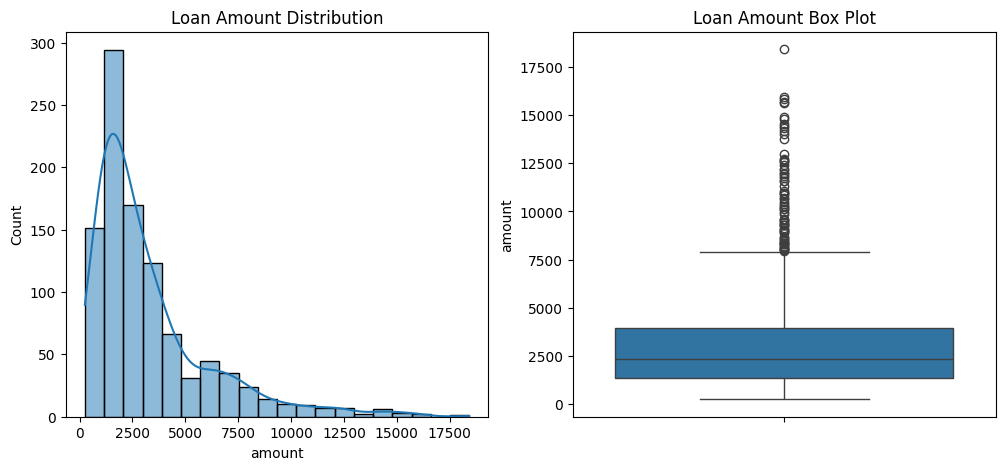


--- Months Loan Duration Analysis ---


<ipython-input-13-58c9eace967e>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


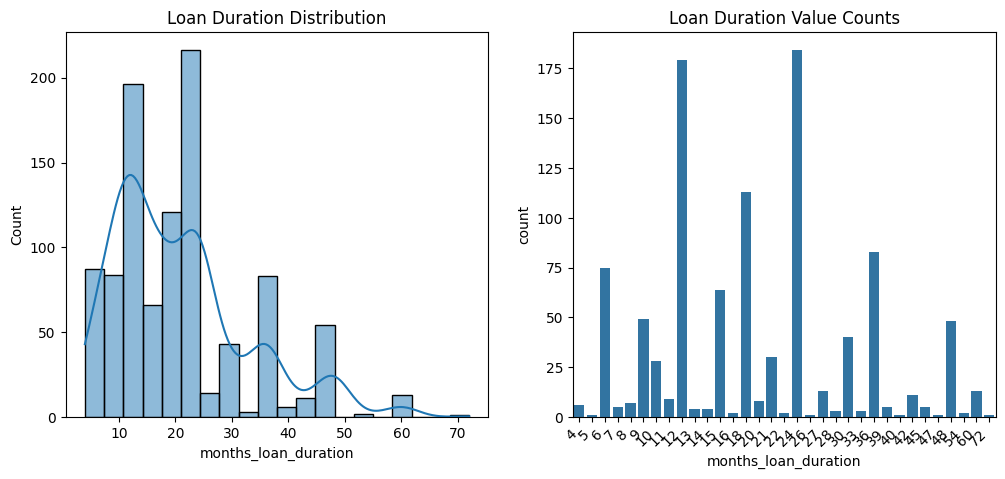

count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: months_loan_duration, dtype: float64

--- Purpose Analysis ---


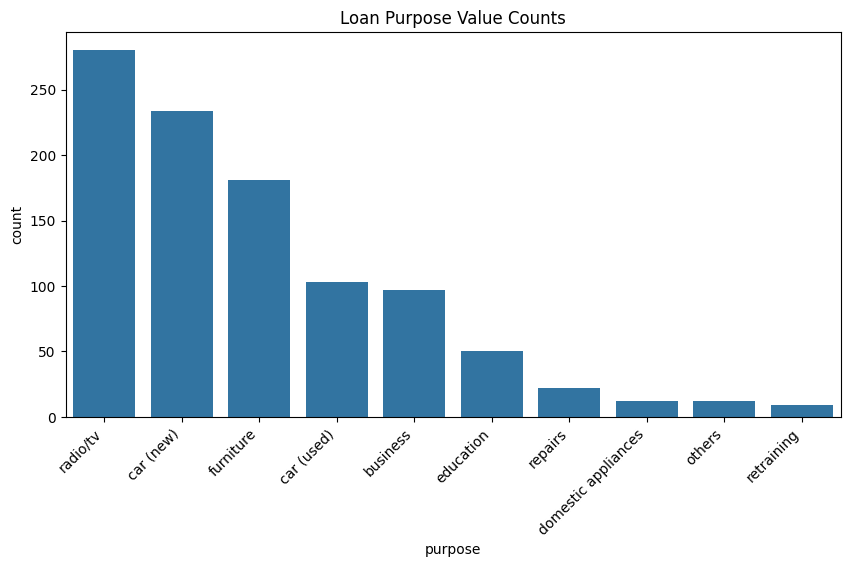

purpose
radio/tv               280
car (new)              234
furniture              181
car (used)             103
business                97
education               50
repairs                 22
domestic appliances     12
others                  12
retraining               9
Name: count, dtype: int64

--- Installment Rate Analysis ---


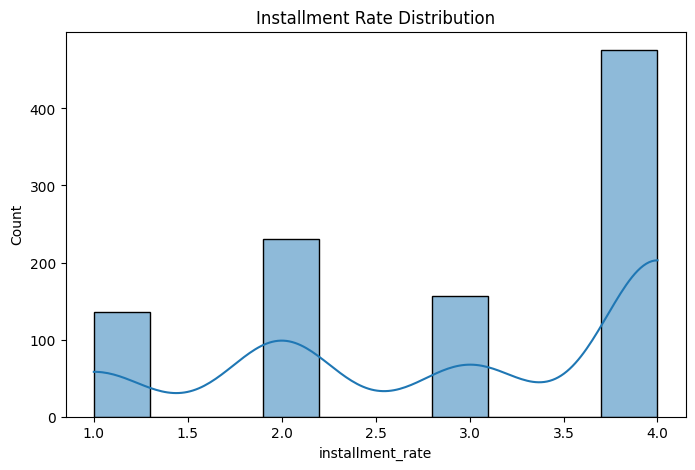

installment_rate
4    476
2    231
3    157
1    136
Name: count, dtype: int64

--- Installment Plan Analysis ---


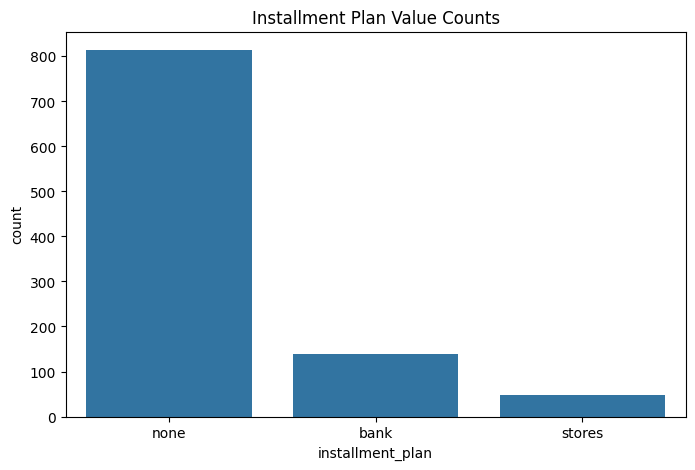

installment_plan
none      814
bank      139
stores     47
Name: count, dtype: int64

--- Analysis Complete ---


In [13]:


# --- Amount Analysis ---
print("\n--- Amount Analysis ---")
print(df['amount'].describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['amount'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Loan Amount Distribution')
sns.boxplot(y=df['amount'], ax=axes[1])
axes[1].set_title('Loan Amount Box Plot')
plt.show()

# --- Months Loan Duration Analysis ---
print("\n--- Months Loan Duration Analysis ---")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['months_loan_duration'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Loan Duration Distribution')
sns.countplot(x='months_loan_duration', data=df, ax=axes[1])
axes[1].set_title('Loan Duration Value Counts')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
plt.show()
print(df['months_loan_duration'].describe())

# --- Purpose Analysis ---
print("\n--- Purpose Analysis ---")
plt.figure(figsize=(10, 5))
sns.countplot(x='purpose', data=df, order=df['purpose'].value_counts().index)
plt.title('Loan Purpose Value Counts')
plt.xticks(rotation=45, ha='right')
plt.show()
print(df['purpose'].value_counts())


# --- Installment Rate Analysis ---
print("\n--- Installment Rate Analysis ---")
plt.figure(figsize=(8, 5))
sns.histplot(df['installment_rate'], bins=10, kde=True)  # Or sns.countplot
plt.title('Installment Rate Distribution')
plt.show()
print(df['installment_rate'].value_counts())

# --- Installment Plan Analysis ---
print("\n--- Installment Plan Analysis ---")
plt.figure(figsize=(8, 5))
sns.countplot(x='installment_plan', data=df)
plt.title('Installment Plan Value Counts')
plt.show()

print(df['installment_plan'].value_counts())

print("\n--- Analysis Complete ---")

## Which Factors Correlate with Default?

In [15]:
credit_data.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_length', 'installment_rate',
       'personal_status', 'other_debtors', 'residence_history', 'property',
       'age', 'installment_plan', 'housing', 'existing_credits', 'default',
       'dependents', 'telephone', 'foreign_worker', 'job', 'gender'],
      dtype='object')

In [17]:
df.isnull().sum()

checking_balance        394
months_loan_duration      0
credit_history            0
purpose                   0
amount                    0
savings_balance         183
employment_length        62
installment_rate          0
personal_status         310
other_debtors             0
residence_history       130
property                  0
age                       0
installment_plan          0
housing                   0
existing_credits          0
default                   0
dependents                0
telephone               596
foreign_worker            0
job                       0
gender                    0
dtype: int64


--- Numerical Features vs. Default ---


<ipython-input-18-f35b733befae>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['employment_length'].fillna("Unknown", inplace=True)
<ipython-input-18-f35b733befae>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

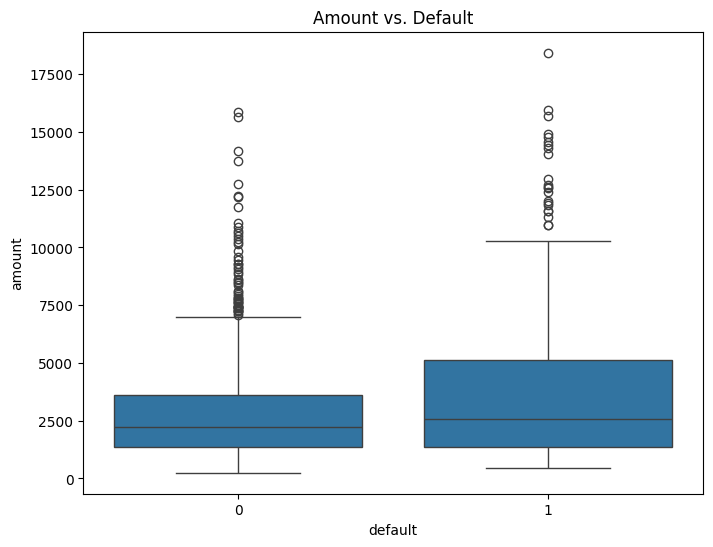


Amount Statistics by Default Status:
                mean  median  count
default                            
0        2985.457143  2244.0    700
1        3938.126667  2574.5    300


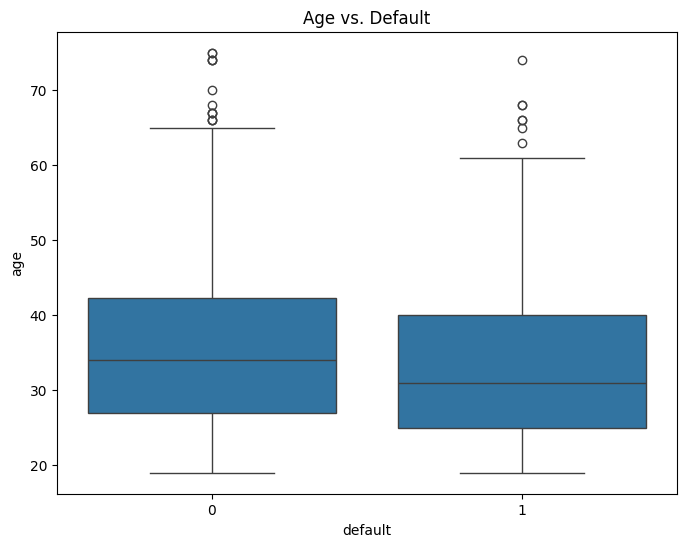


Age Statistics by Default Status:
              mean  median  count
default                          
0        36.224286    34.0    700
1        33.963333    31.0    300


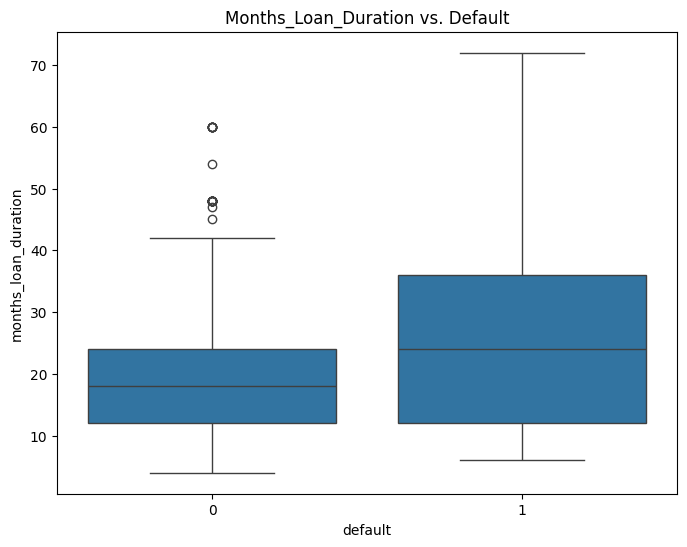


Months_Loan_Duration Statistics by Default Status:
              mean  median  count
default                          
0        19.207143    18.0    700
1        24.860000    24.0    300


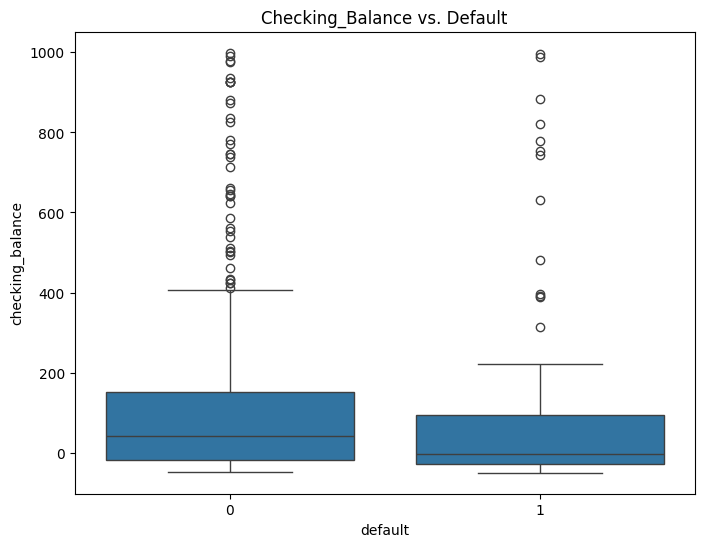


Checking_Balance Statistics by Default Status:
               mean  median  count
default                           
0        123.167614    42.0    352
1         61.322835    -2.0    254


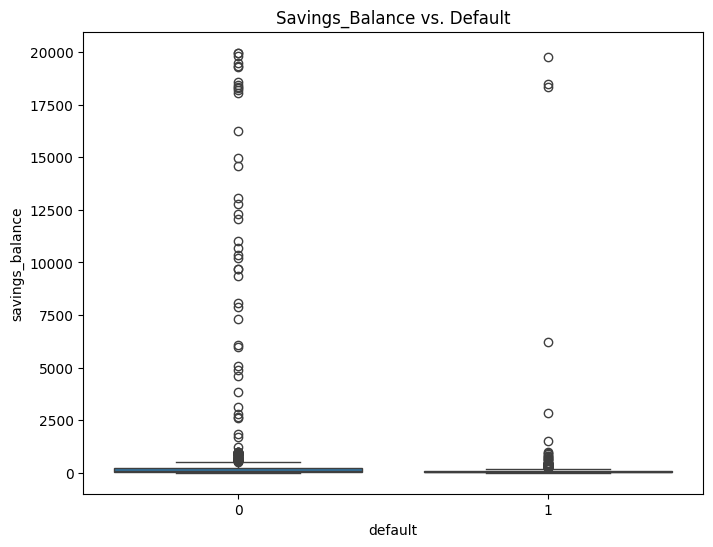


Savings_Balance Statistics by Default Status:
               mean  median  count
default                           
0        986.612022    70.0    549
1        361.541045    53.5    268

--- Categorical Features vs. Default ---
credit_history
fully repaid              0.625000
fully repaid this bank    0.571429
repaid                    0.318868
delayed                   0.318182
critical                  0.170648
Name: default, dtype: float64
credit_history
repaid                    530
critical                  293
delayed                    88
fully repaid this bank     49
fully repaid               40
Name: default, dtype: int64


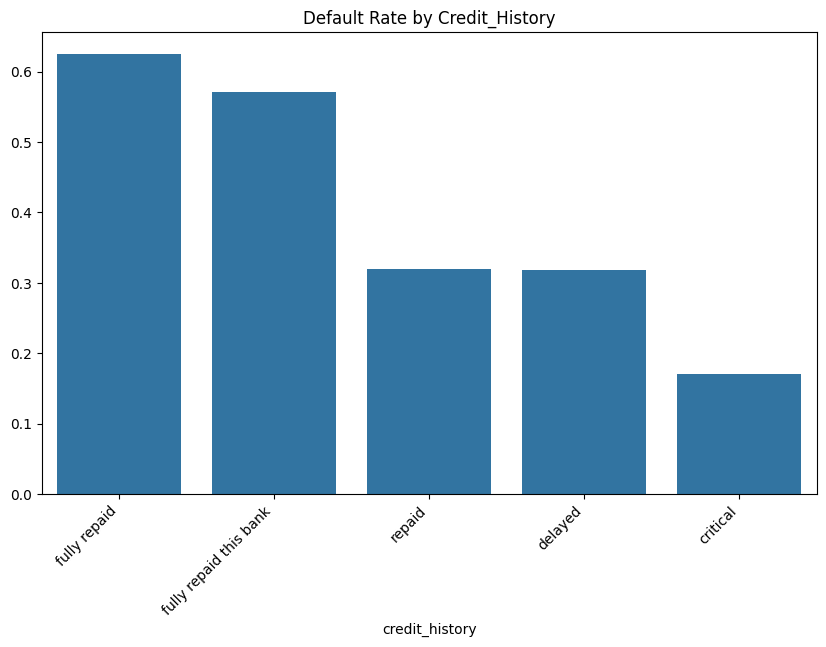

purpose
education              0.440000
others                 0.416667
car (new)              0.380342
repairs                0.363636
business               0.350515
domestic appliances    0.333333
furniture              0.320442
radio/tv               0.221429
car (used)             0.165049
retraining             0.111111
Name: default, dtype: float64
purpose
radio/tv               280
car (new)              234
furniture              181
car (used)             103
business                97
education               50
repairs                 22
domestic appliances     12
others                  12
retraining               9
Name: default, dtype: int64


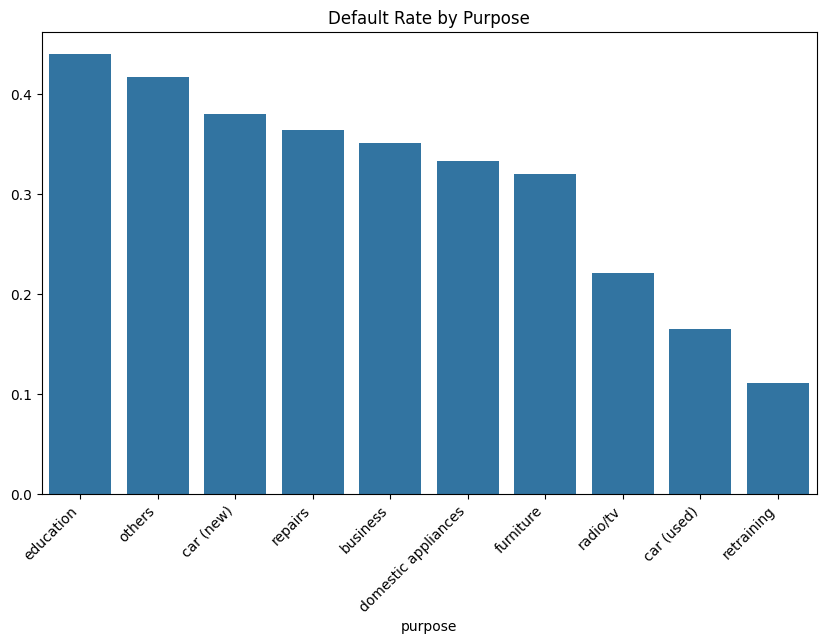

job
mangement self-employed    0.344595
unemployed non-resident    0.318182
skilled employee           0.295238
unskilled resident         0.280000
Name: default, dtype: float64
job
skilled employee           630
unskilled resident         200
mangement self-employed    148
unemployed non-resident     22
Name: default, dtype: int64


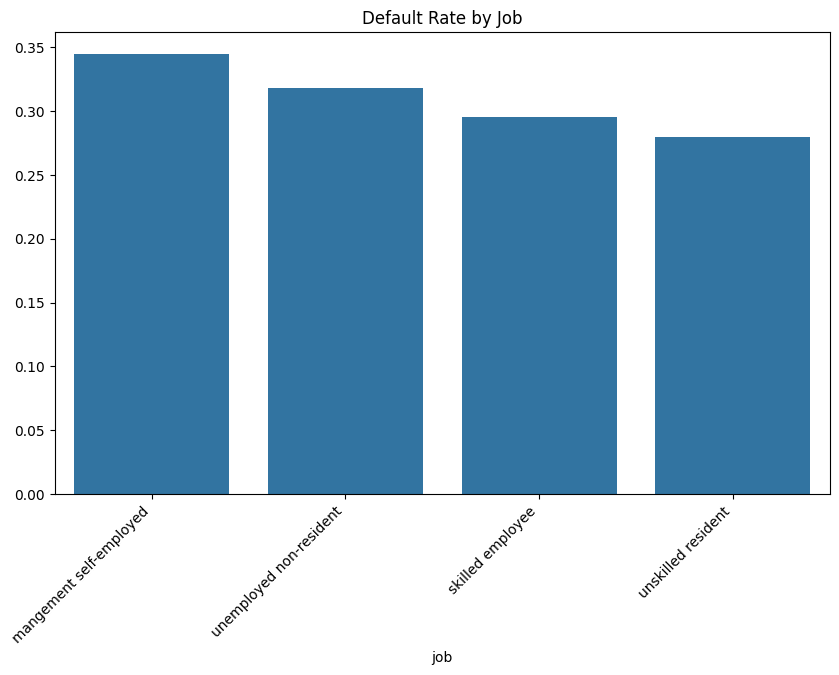

housing
for free    0.407407
rent        0.391061
own         0.260870
Name: default, dtype: float64
housing
own         713
rent        179
for free    108
Name: default, dtype: int64


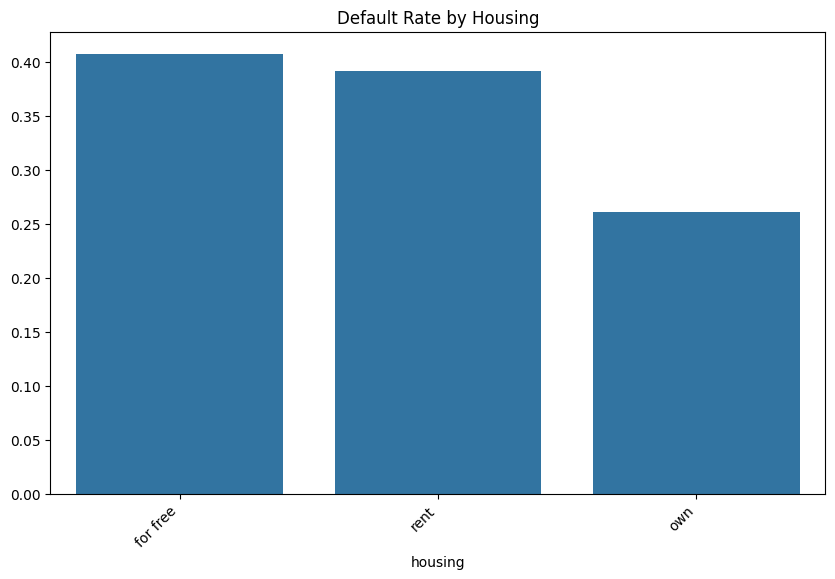

employment_length
11 months    0.750000
0 months     0.666667
7 months     0.500000
3 months     0.421053
2 months     0.416667
10 months    0.384615
10 years     0.375000
9 months     0.375000
Unknown      0.370968
1 months     0.363636
16 years     0.357143
4 months     0.333333
17 years     0.333333
2 years      0.318182
13 years     0.307692
5 years      0.304348
1 years      0.303279
9 years      0.300000
3 years      0.299065
8 months     0.285714
11 years     0.250000
18 years     0.250000
19 years     0.250000
6 months     0.238095
7 years      0.228070
5 months     0.222222
8 years      0.210526
6 years      0.200000
15 years     0.176471
4 years      0.159091
14 years     0.125000
12 years     0.105263
Name: default, dtype: float64
employment_length
1 years      122
2 years      110
3 years      107
Unknown       62
7 years       57
5 years       46
6 years       45
4 years       44
13 years      26
19 years      24
11 years      24
10 years      24
6 months      21
18 years 

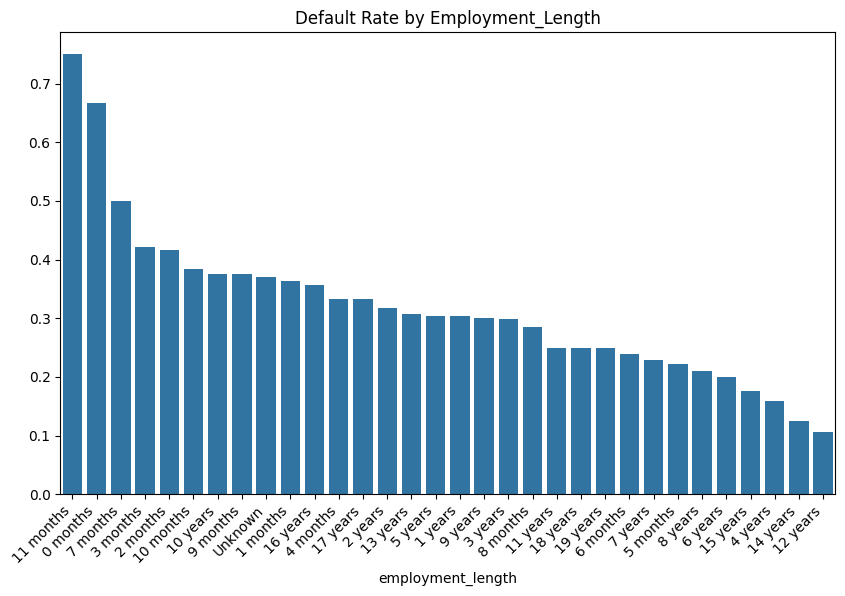

personal_status
divorced    0.400000
Unknown     0.351613
married     0.271739
single      0.266423
Name: default, dtype: float64
personal_status
single      548
Unknown     310
married      92
divorced     50
Name: default, dtype: int64


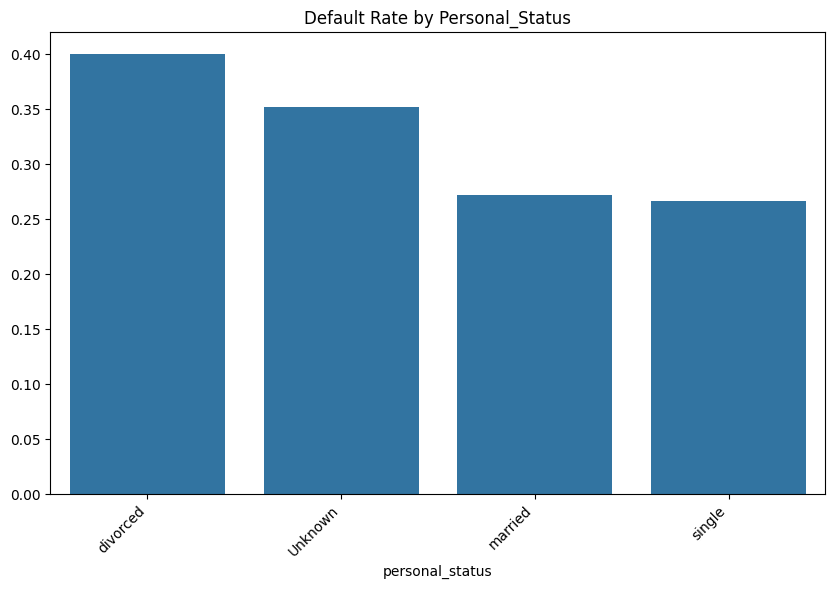

property
unknown/none                0.435065
other                       0.307229
building society savings    0.306034
real estate                 0.212766
Name: default, dtype: float64
property
other                       332
real estate                 282
building society savings    232
unknown/none                154
Name: default, dtype: int64


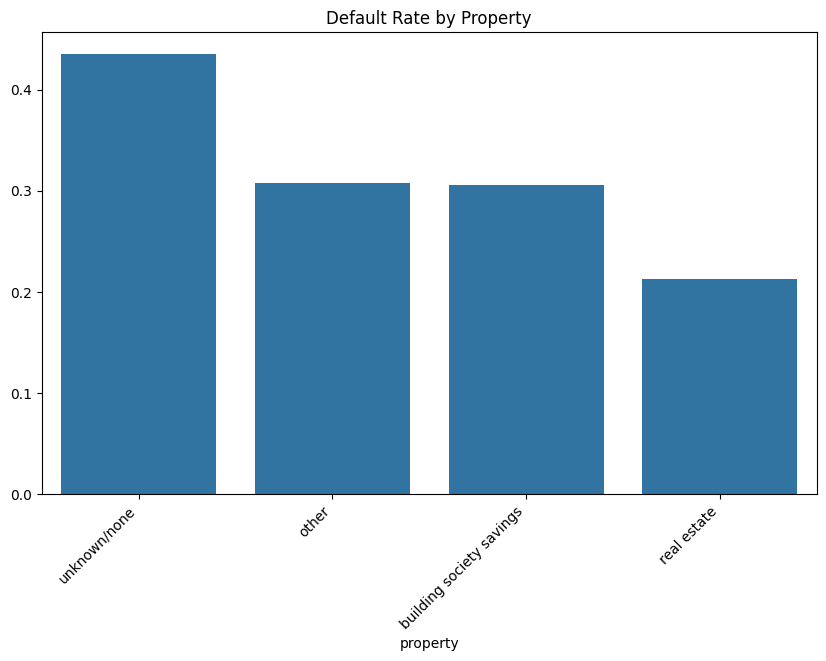

other_debtors
co-applicant    0.439024
none            0.299890
guarantor       0.192308
Name: default, dtype: float64
other_debtors
none            907
guarantor        52
co-applicant     41
Name: default, dtype: int64


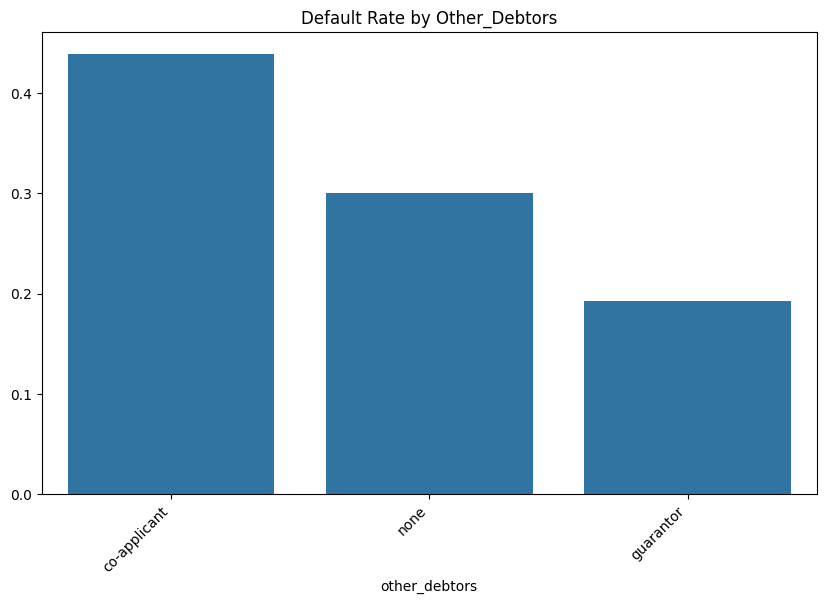

gender
female    0.351613
male      0.276812
Name: default, dtype: float64
gender
male      690
female    310
Name: default, dtype: int64


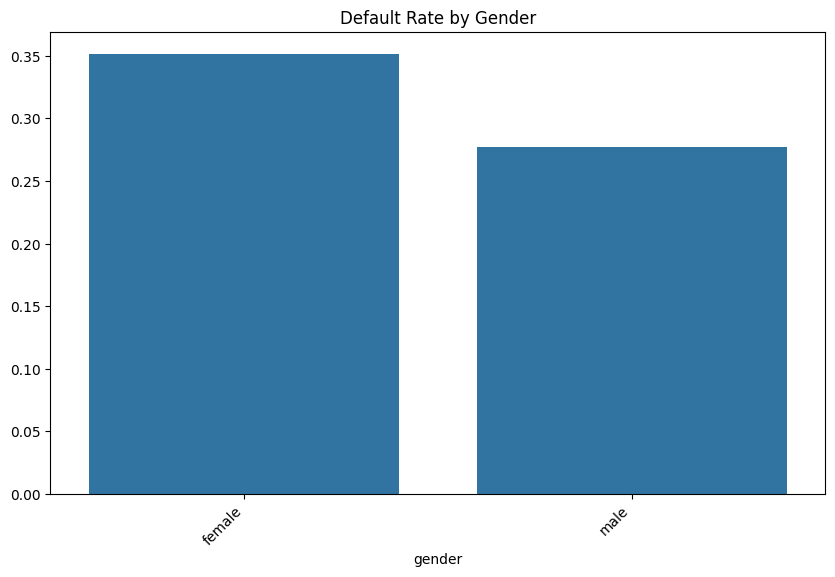

residence_history
0 months     0.558824
9 years      0.526316
21 years     0.444444
6 years      0.400000
4 years      0.393939
10 years     0.370370
5 months     0.363636
10 months    0.350000
5 years      0.350000
23 years     0.347826
3 months     0.346154
19 years     0.333333
6 months     0.333333
22 years     0.320000
7 years      0.315789
15 years     0.315789
9 months     0.310345
24 years     0.304348
2 months     0.291667
8 years      0.285714
20 years     0.285714
11 months    0.280000
2 years      0.279070
Unknown      0.276923
1 years      0.270270
12 years     0.263158
8 months     0.263158
18 years     0.250000
13 years     0.240000
11 years     0.227273
3 years      0.222222
1 months     0.214286
17 years     0.210526
4 months     0.200000
7 months     0.166667
16 years     0.157895
14 years     0.100000
Name: default, dtype: float64
residence_history
Unknown      130
2 years       43
8 months      38
1 years       37
3 years       36
0 months      34
4 years       33
9

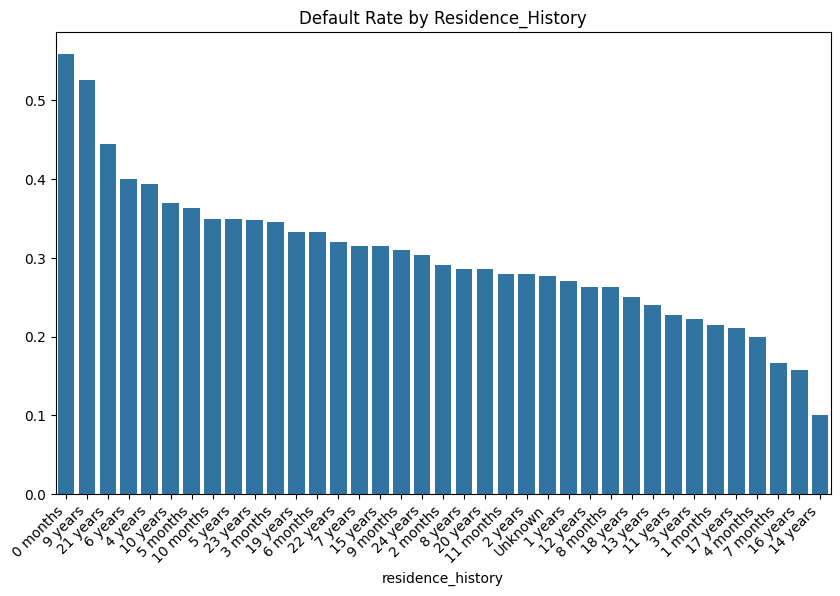

dependents
1    0.300592
2    0.296774
Name: default, dtype: float64
dependents
1    845
2    155
Name: default, dtype: int64


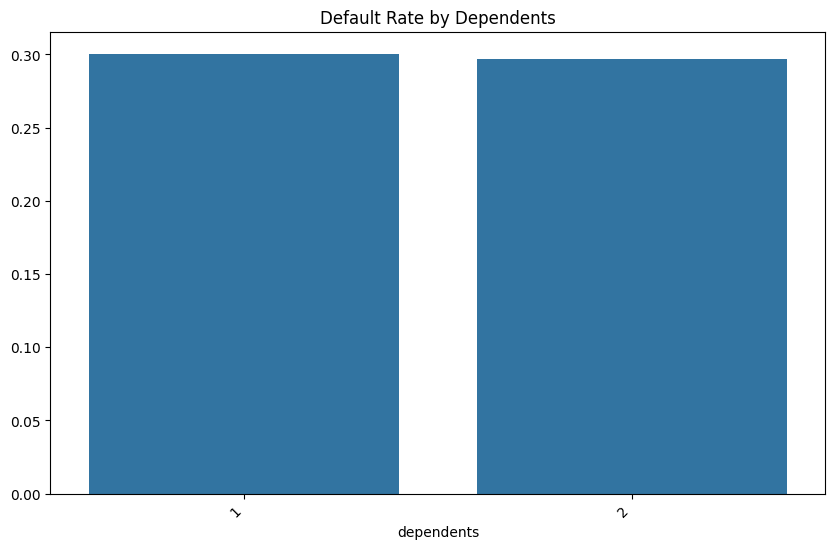

has_telephone
False    0.313758
True     0.279703
Name: default, dtype: float64
has_telephone
False    596
True     404
Name: default, dtype: int64


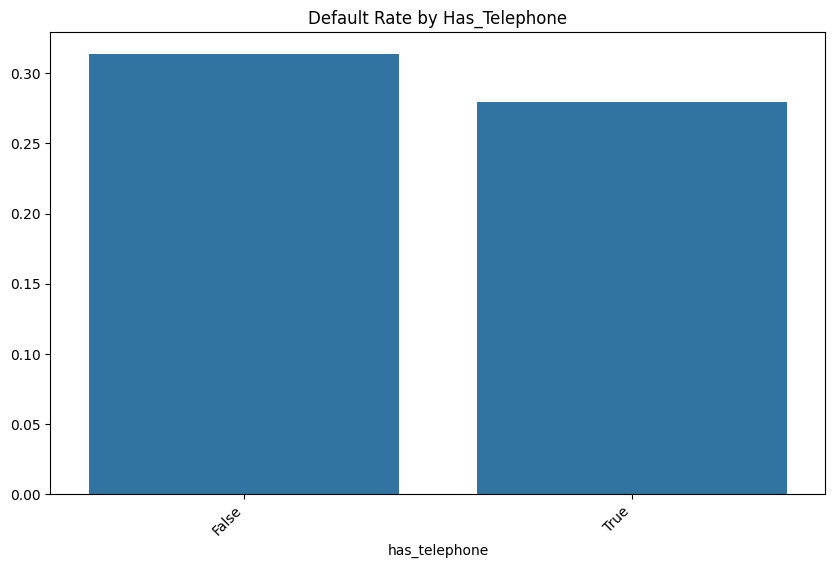

installment_plan
bank      0.410072
stores    0.404255
none      0.275184
Name: default, dtype: float64
installment_plan
none      814
bank      139
stores     47
Name: default, dtype: int64


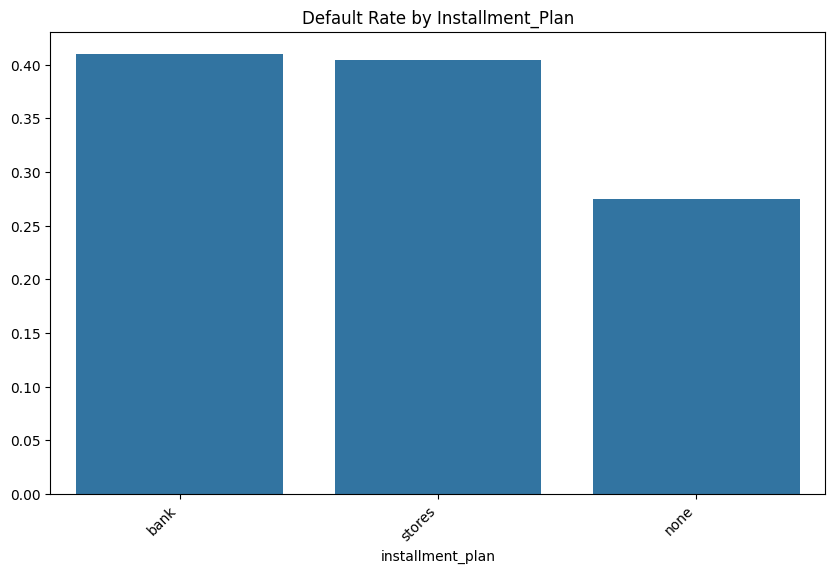

existing_credits
4    0.333333
1    0.315956
2    0.276276
3    0.214286
Name: default, dtype: float64
existing_credits
1    633
2    333
3     28
4      6
Name: default, dtype: int64


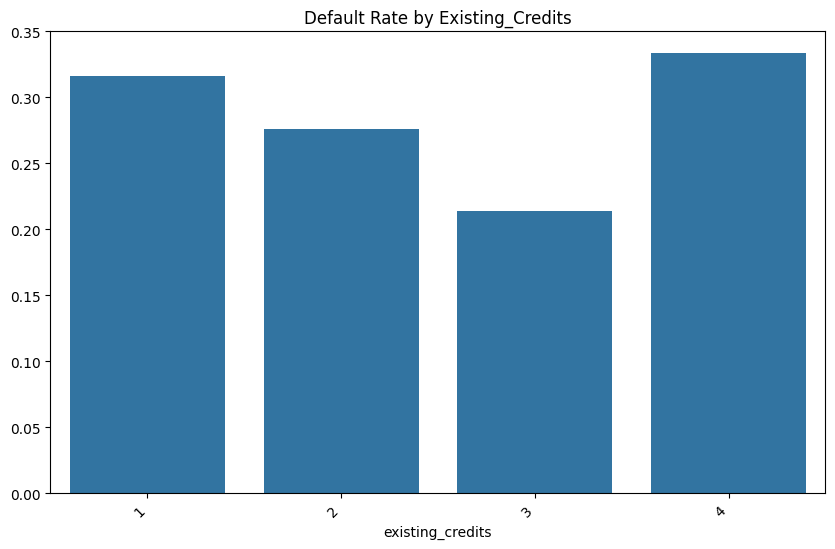

foreign_worker
yes    0.307373
no     0.108108
Name: default, dtype: float64
foreign_worker
yes    963
no      37
Name: default, dtype: int64


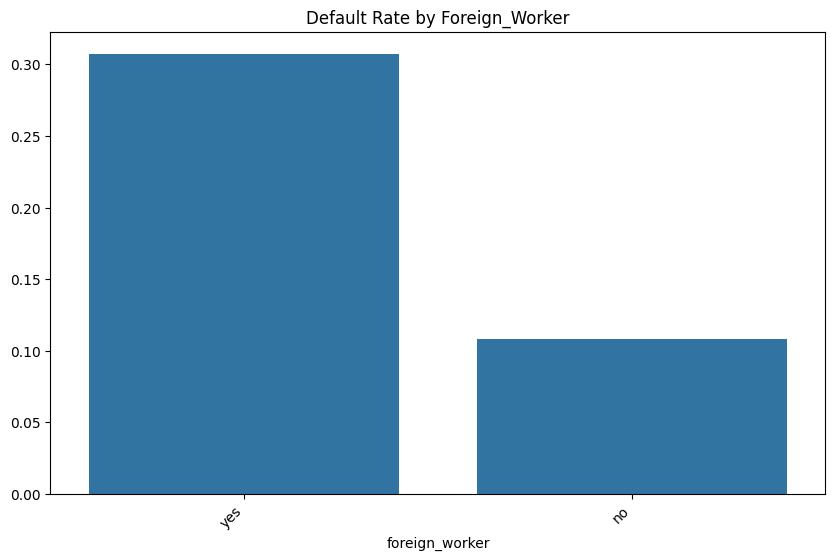


--- Analysis Complete ---


In [18]:
# --- Numerical vs. Default ---
print("\n--- Numerical Features vs. Default ---")
numerical_features = ['amount', 'age', 'months_loan_duration', 'checking_balance', 'savings_balance']

df['employment_length'].fillna("Unknown", inplace=True)
df['residence_history'].fillna("Unknown", inplace=True)
df['personal_status'].fillna("Unknown", inplace=True)
df['has_telephone'] = df['telephone'].notna()

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='default', y=feature, data=df)  # Or sns.violinplot
    plt.title(f'{feature.title()} vs. Default')
    plt.show()

    # Calculate and compare mean/median
    print(f'\n{feature.title()} Statistics by Default Status:')
    print(df.groupby('default')[feature].agg(['mean', 'median', 'count']))

# --- Categorical vs. Default ---
print("\n--- Categorical Features vs. Default ---")
categorical_features = ['credit_history', 'purpose', 'job', 'housing', 'employment_length',
                        'personal_status', 'property', 'other_debtors', 'gender',
                        'residence_history', 'dependents','has_telephone',
                        'installment_plan', 'existing_credits', 'foreign_worker']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    default_rates = df.groupby(feature)['default'].mean().sort_values(ascending=False)
    default_counts = df.groupby(feature)['default'].count().sort_values(ascending=False)
    print(default_rates)
    print(default_counts)
    sns.barplot(x=default_rates.index, y=default_rates.values)
    plt.title(f'Default Rate by {feature.title()}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
    plt.show()

print("\n--- Analysis Complete ---")

# Missing Data Analysis

In [23]:
df = credit_data.copy()


--- 1. Missing Value Percentage Bar Chart ---


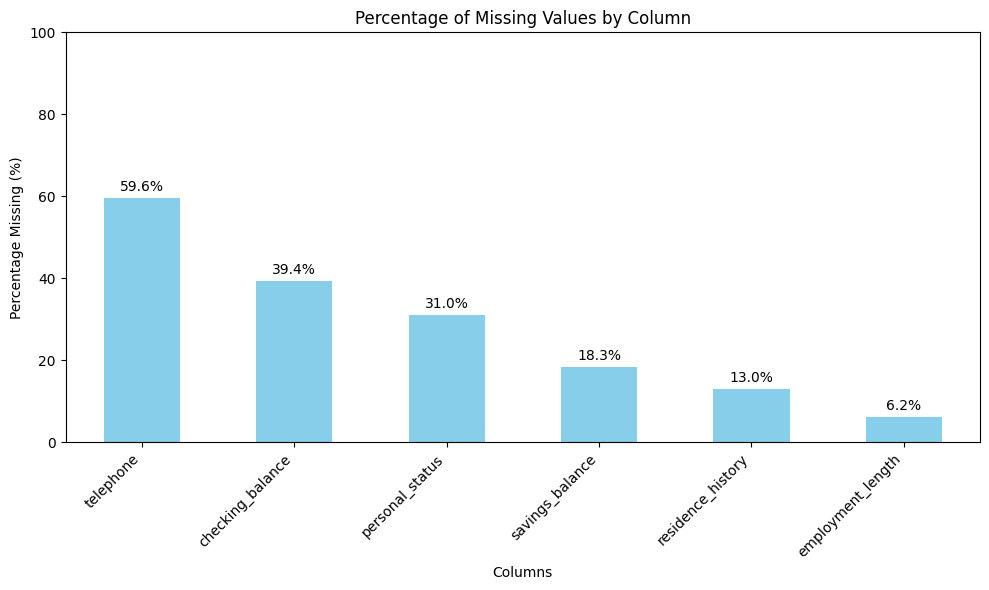


--- 2. Missingno Visualizations ---

Missing Value Matrix:


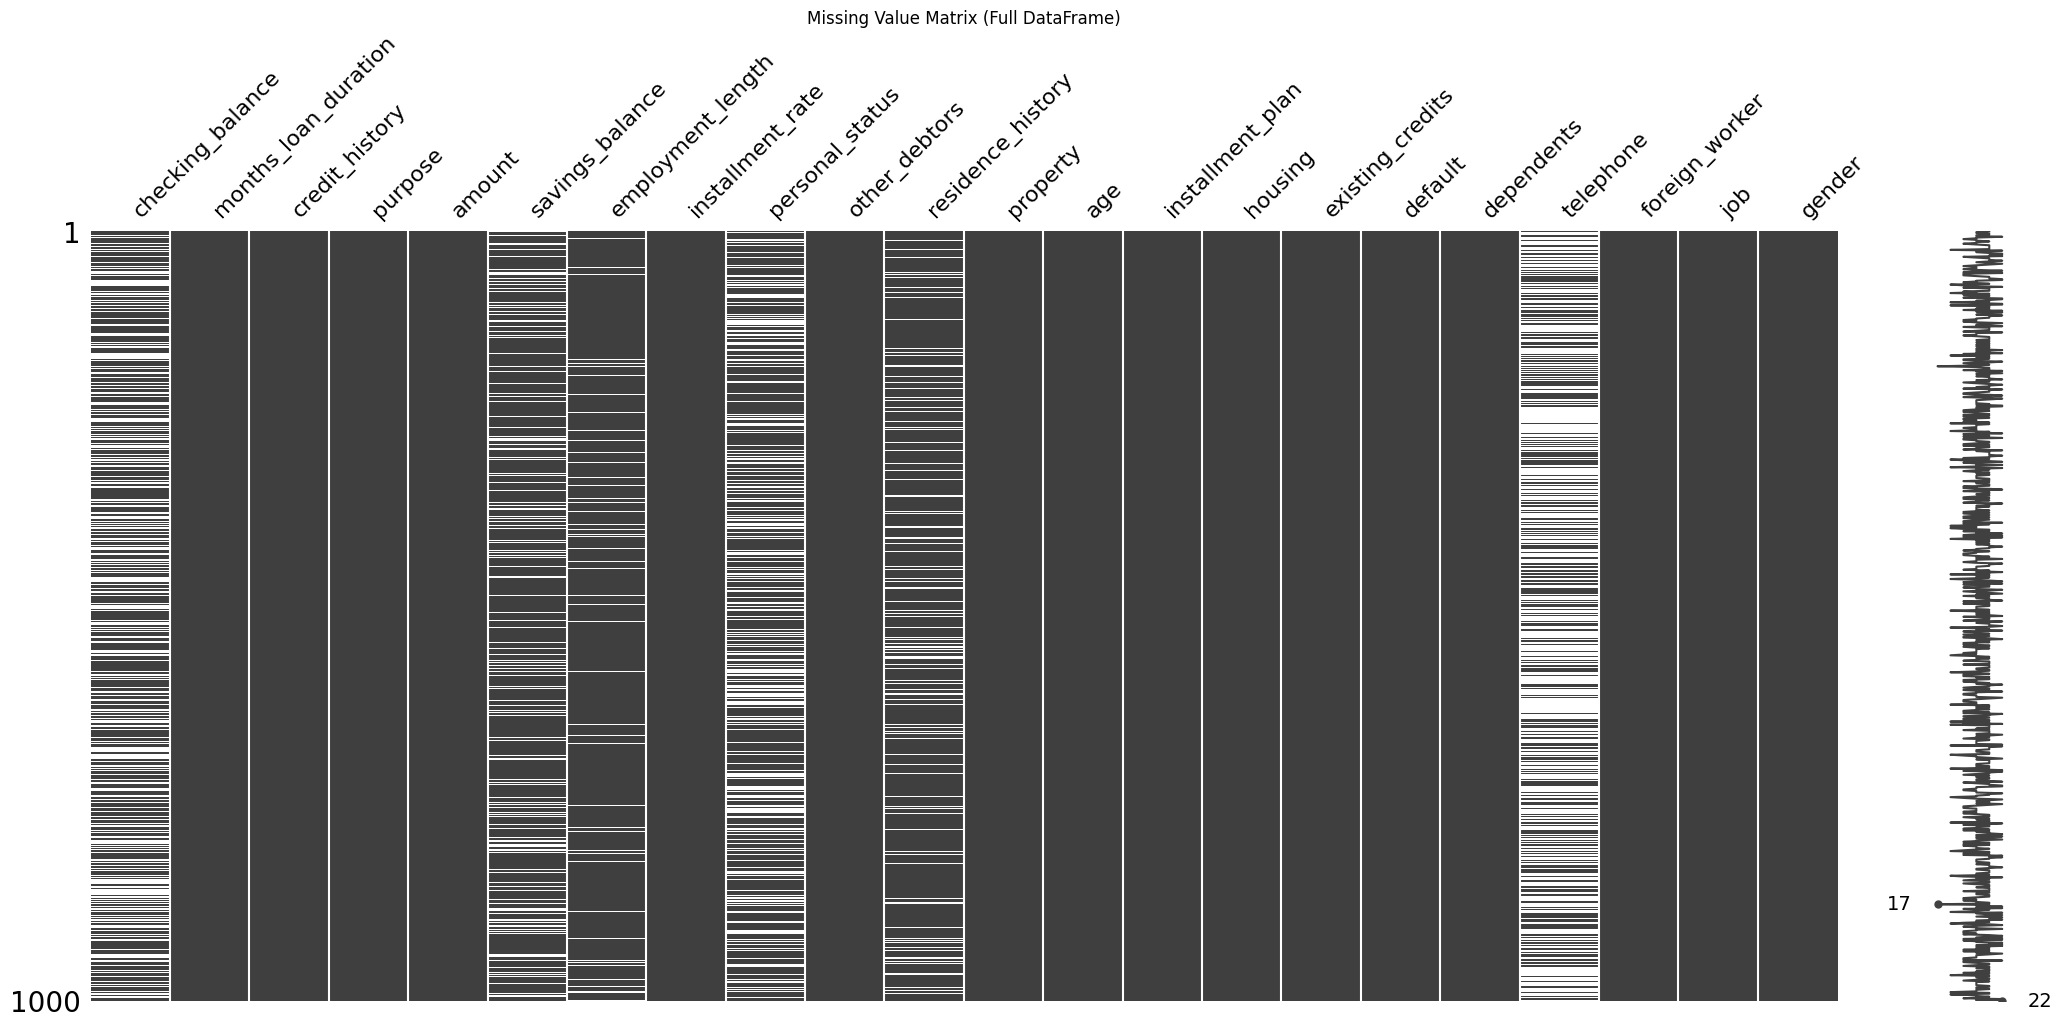


Missing Value Heatmap:


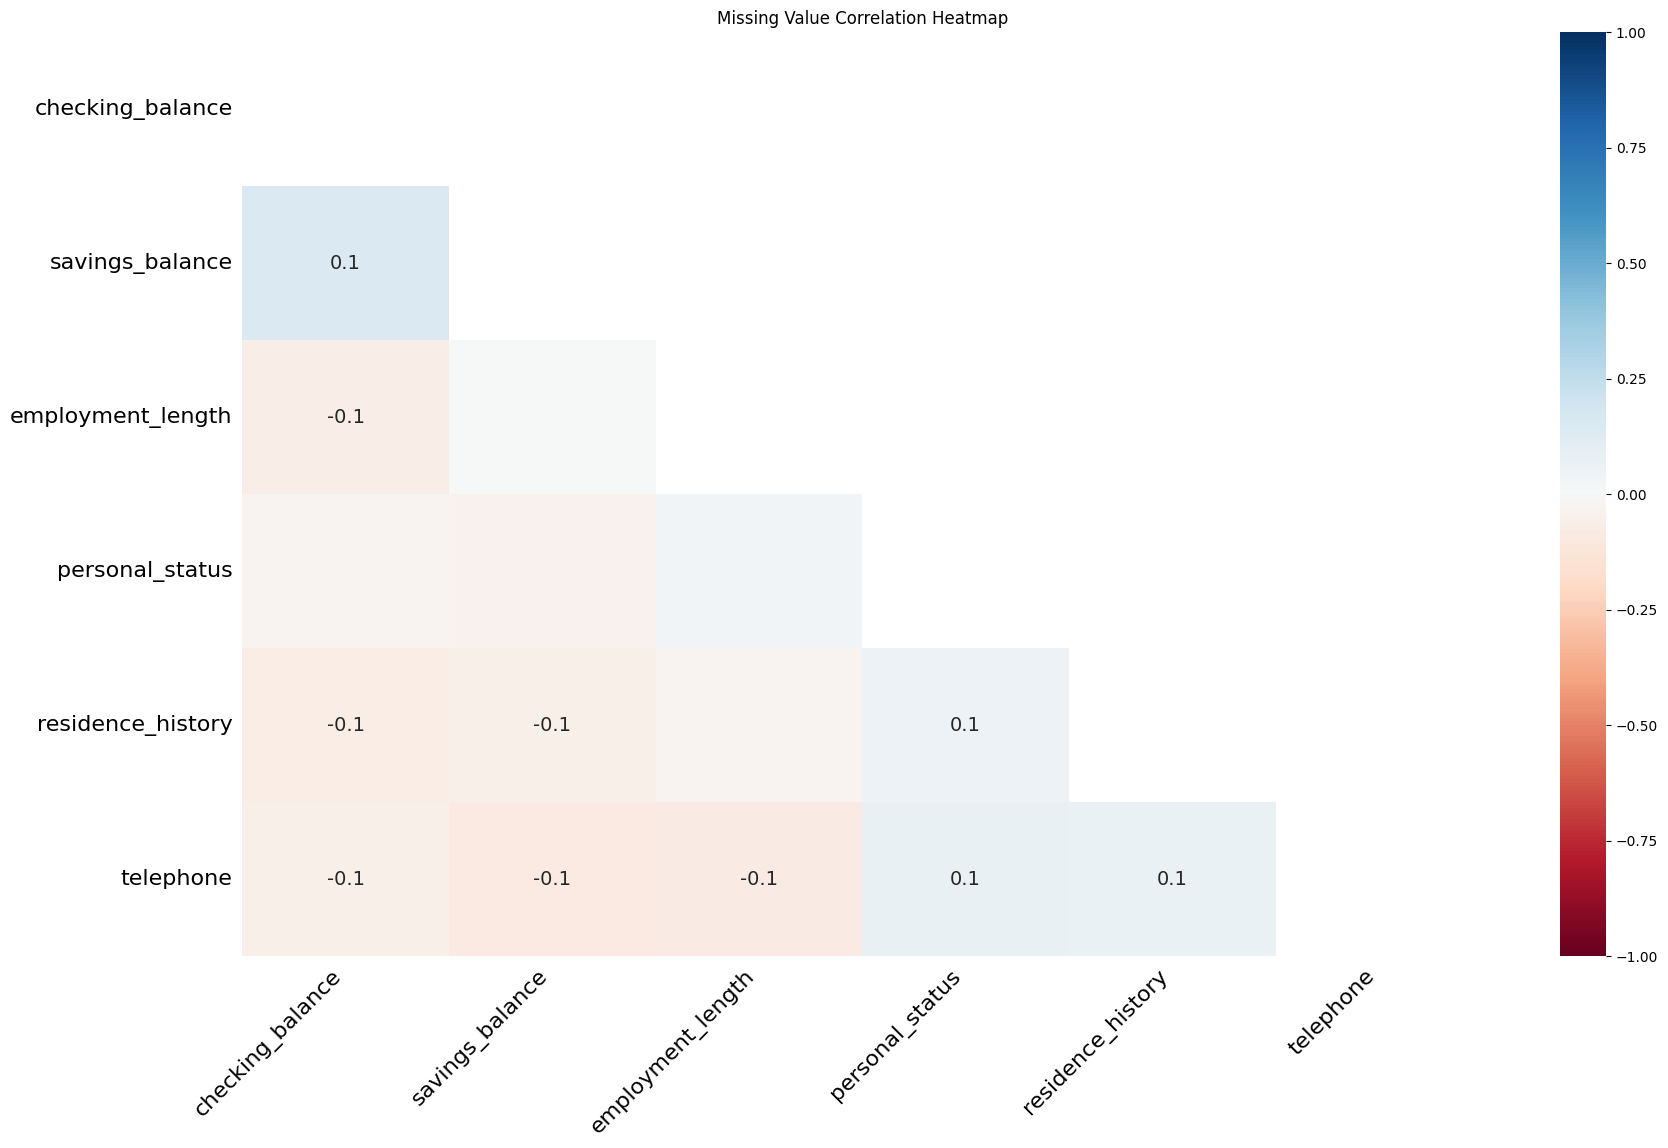


--- 3. Chi-squared Test (Missingness vs. Default) ---

--- Chi-squared Test for Missingness in 'checking_balance' vs. 'default' ---

Contingency Table:
default             0    1
checking_balance          
False             352  254
True              348   46

Chi-squared Statistic: 102.5298
P-value: 0.0000
Degrees of Freedom: 1

Result: Reject the null hypothesis (p < 0.05).
There is a statistically significant association between whether 'checking_balance' is missing and the 'default' status.

--- Chi-squared Test for Missingness in 'savings_balance' vs. 'default' ---

Contingency Table:
default            0    1
savings_balance          
False            549  268
True             151   32

Chi-squared Statistic: 15.9810
P-value: 0.0001
Degrees of Freedom: 1

Result: Reject the null hypothesis (p < 0.05).
There is a statistically significant association between whether 'savings_balance' is missing and the 'default' status.

--- Chi-squared Test for Missingness in 'employment_length'

In [24]:


# --- Analysis ---

# 1. Bar Chart of Missing Value Percentage for Specified Columns

print("\n--- 1. Missing Value Percentage Bar Chart ---")
cols_to_check = ['checking_balance', 'savings_balance', 'employment_length', 'personal_status', 'residence_history', 'telephone']

# Calculate missing percentage for ALL columns
missing_perc = (df.isnull().sum() / len(df)) * 100

# Filter for the specified columns that actually HAVE missing values
missing_perc_selected = missing_perc[missing_perc.index.isin(cols_to_check) & (missing_perc > 0)]
missing_perc_selected = missing_perc_selected.sort_values(ascending=False)

if not missing_perc_selected.empty:
    plt.figure(figsize=(10, 6))
    missing_perc_selected.plot(kind='bar', color='skyblue')
    plt.title('Percentage of Missing Values by Column')
    plt.ylabel('Percentage Missing (%)')
    plt.xlabel('Columns')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100) # Ensure y-axis goes up to 100%
    # Add percentage labels on top of bars
    for index, value in enumerate(missing_perc_selected):
        plt.text(index, value + 1, f"{value:.1f}%", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
else:
    print("None of the specified columns have missing data.")


# 2. Missingno Visualizations

print("\n--- 2. Missingno Visualizations ---")

# Select only columns with at least one missing value for clearer visualization
cols_with_missing = df.columns[df.isnull().any()].tolist()

if cols_with_missing:
    df_missing_subset = df[cols_with_missing]

    print("\nMissing Value Matrix:")
    msno.matrix(df) # Often better to plot the whole df to see context
    plt.title('Missing Value Matrix (Full DataFrame)')
    plt.show()

    print("\nMissing Value Heatmap:")
    # Heatmap shows correlation of missingness between columns
    # Only makes sense if there's more than one column with missing data
    if len(cols_with_missing) > 1:
        msno.heatmap(df_missing_subset)
        plt.title('Missing Value Correlation Heatmap')
        plt.show()
    else:
        print("Skipping heatmap: Only one column (or fewer) has missing data.")

else:
    print("No missing data found in the DataFrame. Skipping missingno plots.")


# 3. Chi-squared Test for Missingness vs. Default

print("\n--- 3. Chi-squared Test (Missingness vs. Default) ---")

# Columns to test correlation of missingness with 'default'
key_cols_for_chi2 = ['checking_balance', 'savings_balance', 'employment_length', 'personal_status', 'residence_history', 'telephone']

# Check if 'default' column exists
if 'default' not in df.columns:
    print("Error: 'default' column not found in DataFrame. Cannot perform Chi-squared test.")
else:
    alpha = 0.05 # Significance level

    for col in key_cols_for_chi2:
        if col not in df.columns:
            print(f"\nWarning: Column '{col}' not found. Skipping Chi-squared test for this column.")
            continue

        # Create a boolean column: True if the original value is missing, False otherwise
        missing_indicator = df[col].isnull()

        # Check if there's any missing data in this column to test
        if missing_indicator.sum() == 0:
            print(f"\nColumn '{col}': No missing values. Skipping Chi-squared test.")
            continue

        print(f"\n--- Chi-squared Test for Missingness in '{col}' vs. 'default' ---")

        # Create the contingency table: counts of default (0/1) vs missing (True/False)
        contingency_table = pd.crosstab(missing_indicator, df['default'])

        print("\nContingency Table:")
        print(contingency_table)

        # Perform the Chi-squared test
        try:
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)

            print(f"\nChi-squared Statistic: {chi2:.4f}")
            print(f"P-value: {p_value:.4f}")
            print(f"Degrees of Freedom: {dof}")
            # print("\nExpected Frequencies:")
            # print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

            # Interpretation
            if p_value < alpha:
                print(f"\nResult: Reject the null hypothesis (p < {alpha}).")
                print(f"There is a statistically significant association between whether '{col}' is missing and the 'default' status.")
            else:
                print(f"\nResult: Fail to reject the null hypothesis (p >= {alpha}).")
                print(f"There is no statistically significant association between whether '{col}' is missing and the 'default' status.")

        except ValueError as e:
             print(f"\nCould not perform Chi-squared test for '{col}'.")
             print(f"Reason: {e}")
             print("This often happens if one category (e.g., all missing values correspond to only one default status) leads to zero expected frequencies.")

print("\n--- Analysis Complete ---")

# Split Train, Validation and Test set

I want us to simulate how this should look like in the real-world. We use the validation data set as the main test set for now and then develop an inference pipeline for the test dataset. On the test dataset we can even demonstrate how individual customers can be predicted upon (online inference) and also show (batch inference).

We use the batch inference bit for the qualitative analysis of the model performance.

The current evaluation for Hyperparameter Tuning will be done on the validation set so that when get the best parameters we can use it in training pipeline to perform the final evaluation on the test set



In [27]:
X = credit_data.drop('default', axis=1)
y = credit_data['default']

In [71]:
# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1,
                                                        random_state=42,
                                                        stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_full,
                                                      y_train_full,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y_train_full)

# Data Preprocessing

 Based on the above Chi-Sqaure analysis systematic imputation methods will be applied for

 1. Checking Balance
 2. Savings Balance
 3. Personal Status

In [32]:
def prepare_imputation_strategy(train_df, target_column='default'):
    """
    Analyzes training data to determine imputation strategy.

    Calculates grouped (by target) and global (overall) imputation values
    for columns where missingness is significantly associated with the target.

    Args:
        train_df (pd.DataFrame): The training dataframe.
        target_column (str): The name of the target variable column.

    Returns:
        tuple: Contains:
            - imputation_instructions (dict): {col: 'must-impute'/'not-necessary'}
            - grouped_imputation_values (dict): {col: {target_val: median/mode}}
            - global_imputation_values (dict): {col: global_median/mode}
            - columns_to_impute (list): List of column names needing imputation.
            - missing_indicator_cols (list): List of names for the missing indicator columns to be created.
    """
    df = train_df.copy() # Work on a copy
    null_info = df.isnull().sum().reset_index()
    imputation_instructions = {} # {col: 'must-impute'/'not-necessary'}
    grouped_imputation_values = defaultdict(dict) # {feature: {class_value: median/mode}}
    global_imputation_values = {} # {feature: global_median/mode}
    columns_to_impute = []
    missing_indicator_cols = []

    print("--- Preparing Imputation Strategy ---")

    for i in range(len(null_info)):
        column_name = null_info.iloc[i, 0]
        missing_count = null_info.iloc[i, 1]

        if missing_count > 0 and column_name != target_column:
            print(f"Analyzing column: {column_name} (Missing: {missing_count})")
            # Create temporary missingness indicator FOR THE TEST ONLY
            missing_col_name = f"{column_name}_missing"
            missing_indicator = df[column_name].isna()

            # Chi-square test
            # Avoid error if one group (missing/not missing) has low counts or no variance in target
            p_value = 1.0 # Default to not significant
            try:
                contingency_table = pd.crosstab(missing_indicator, df[target_column])
                # Check if contingency table is valid for chi-square
                if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2 or contingency_table.min().min() == 0:
                   print(f"  Skipping Chi-squared test for {column_name} due to insufficient data variation across groups/missingness.")
                   # Decide how to handle - Option: Impute if missingness > threshold, e.g. 5%
                   if missing_count / len(df) > 0.05:
                       print(f"  Marking {column_name} for imputation due to missing count > 5%.")
                       p_value = 0.0 # Force imputation
                   else:
                        print(f"  Marking {column_name} as 'not-necessary' due to low missing count and test infeasibility.")
                        p_value = 1.0
                else:
                    chi2, p_value, _, expected_freq = chi2_contingency(contingency_table)
                    # Check for low expected frequencies (warning for Chi-squared validity)
                    if (expected_freq < 5).any().any():
                         print(f"  Warning: Chi-squared test for {column_name} has expected frequencies < 5. P-value ({p_value:.4f}) might be unreliable.")
                    else:
                         print(f"  Chi-squared test for {column_name}: p-value = {p_value:.4f}")

            except ValueError as e:
                 print(f"  Error during Chi-squared test for {column_name}: {e}. Treating as 'must-impute'.")
                 p_value = 0.0 # Treat as significant if test fails

            # --- Imputation Decision ---
            if p_value < 0.05: # Threshold for significance
                print(f"  '{column_name}' missingness IS significantly associated with '{target_column}'. Marking for imputation.")
                imputation_instructions[column_name] = 'must-impute'
                columns_to_impute.append(column_name)
                missing_indicator_cols.append(missing_col_name) # Mark indicator as needed

                # --- Calculate Imputation Values ---
                is_numeric = pd.api.types.is_numeric_dtype(df[column_name])

                # 1. Calculate GLOBAL value (needed for Test set)
                if is_numeric:
                    global_value = df[column_name].median()
                    print(f"    Global Median: {global_value}")
                else: # Categorical or other non-numeric
                    mode_series = df[column_name].mode()
                    if not mode_series.empty:
                        global_value = mode_series.iloc[0]
                        print(f"    Global Mode: {global_value}")
                    else:
                        global_value = None # Handle case with no mode
                        print(f"    Warning: Global mode for {column_name} is undefined.")
                global_imputation_values[column_name] = global_value

                # 2. Calculate GROUPED values (needed for Train set)
                if is_numeric:
                    group_values = df.groupby(target_column)[column_name].median().to_dict()
                    print(f"    Grouped Medians: {group_values}")
                    grouped_imputation_values[column_name] = group_values
                else: # Categorical
                    # Calculate mode per group, fallback to global mode if group mode is empty or undefined
                    group_modes = {}
                    for name, group_df in df.groupby(target_column):
                         mode_series_group = group_df[column_name].mode()
                         if not mode_series_group.empty:
                              group_modes[name] = mode_series_group.iloc[0]
                         else:
                              # Fallback to previously calculated global mode
                              group_modes[name] = global_value
                              if global_value is None:
                                   print(f"    Warning: Group mode for {column_name} (group {name}) and global mode are undefined. Imputation might fail.")
                    print(f"    Grouped Modes: {group_modes}")
                    grouped_imputation_values[column_name] = group_modes

                # --- Sanity check imputation values ---
                # Ensure global value is not None if imputation is needed
                if global_imputation_values[column_name] is None:
                     print(f"  ERROR: Global imputation value for {column_name} is None, but imputation is required. Cannot proceed with this column.")
                     # Remove column from imputation lists
                     columns_to_impute.remove(column_name)
                     missing_indicator_cols.remove(missing_col_name)
                     del imputation_instructions[column_name]
                     if column_name in grouped_imputation_values: del grouped_imputation_values[column_name]
                     if column_name in global_imputation_values: del global_imputation_values[column_name]
                     continue # Skip to next column

                # Check grouped values for None (can happen if global fallback was also None)
                for group, value in grouped_imputation_values[column_name].items():
                     if value is None:
                         print(f"  ERROR: Grouped imputation value for {column_name}, group {group} is None. Cannot proceed with this column.")
                         # Remove column from imputation lists
                         if column_name in columns_to_impute: columns_to_impute.remove(column_name)
                         if missing_col_name in missing_indicator_cols: missing_indicator_cols.remove(missing_col_name)
                         if column_name in imputation_instructions: del imputation_instructions[column_name]
                         if column_name in grouped_imputation_values: del grouped_imputation_values[column_name]
                         if column_name in global_imputation_values: del global_imputation_values[column_name]
                         break # Stop checking groups for this column

            else: # p_value >= 0.05
                print(f"  '{column_name}' missingness IS NOT significantly associated with '{target_column}'. Marking as 'not-necessary'.")
                imputation_instructions[column_name] = 'not-necessary'
                # No imputation needed, no indicator needed for this column

    print("--- Imputation Strategy Prepared ---")
    print(f"Columns to impute: {columns_to_impute}")
    print(f"Missing indicator columns to create: {missing_indicator_cols}")

    return imputation_instructions, grouped_imputation_values, global_imputation_values, columns_to_impute, missing_indicator_cols


def apply_imputation_strategy(df, imputation_values, columns_to_impute, missing_indicator_cols, target_column=None, mode='grouped'):
    """
    Applies the prepared imputation strategy to a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to impute (can be train or test).
        imputation_values (dict): EITHER grouped OR global values, depending on mode.
        columns_to_impute (list): List of columns to fill NaNs in.
        missing_indicator_cols (list): List of indicator columns to create.
        target_column (str, optional): Name of target column. Required if mode='grouped'. Defaults to None.
        mode (str): 'grouped' (use target groups, provide grouped_values) or
                    'global' (use global values, provide global_values). Defaults to 'grouped'.

    Returns:
        pd.DataFrame: The DataFrame with imputations applied and indicators added.
    """
    df_imputed = df.copy()
    print(f"\n--- Applying Imputation (Mode: {mode}) ---")

    # 1. Add missing indicator columns
    print(f"Adding indicator columns: {missing_indicator_cols}")
    for indicator_col_name in missing_indicator_cols:
        original_col_name = indicator_col_name.replace('_missing', '')
        if original_col_name in df_imputed.columns:
            df_imputed[indicator_col_name] = df_imputed[original_col_name].isna().astype(int)
        else:
             print(f"  Warning: Original column '{original_col_name}' not found for indicator '{indicator_col_name}'. Skipping indicator creation.")


    # 2. Apply imputation value filling
    print(f"Imputing columns: {columns_to_impute}")
    for col in columns_to_impute:
        if col not in df_imputed.columns:
             print(f"  Warning: Column '{col}' not found in DataFrame. Skipping imputation.")
             continue

        if col not in imputation_values:
            print(f"  Warning: Imputation values not found for column '{col}'. Skipping imputation.")
            continue

        nan_count_before = df_imputed[col].isnull().sum()
        if nan_count_before == 0:
             # print(f"  No NaNs to impute in column '{col}'.") # Optional: reduce verbosity
             continue

        if mode == 'grouped':
            if target_column is None or target_column not in df_imputed.columns:
                raise ValueError("Target column must be provided and exist in df for 'grouped' mode.")

            print(f"  Applying GROUPED imputation for '{col}'...")
            group_vals = imputation_values[col] # Should be {group: value}
            for group, value in group_vals.items():
                 if value is not None:
                     # Create boolean mask for NaNs in the specific group
                     mask = (df_imputed[col].isnull()) & (df_imputed[target_column] == group)
                     df_imputed.loc[mask, col] = value
                 else:
                     # This case should ideally be handled in prepare step, but warn again.
                      print(f"  Warning: Imputation value is None for column {col}, group {group}. NaNs in this group remain.")

        elif mode == 'global':
            print(f"  Applying GLOBAL imputation for '{col}'...")
            global_value = imputation_values[col] # Should be a single value
            if global_value is not None:
                df_imputed[col].fillna(global_value, inplace=True)
            else:
                 # This case should ideally be handled in prepare step, but warn again.
                 print(f"  Warning: Global imputation value is None for column {col}. NaNs remain.")
        else:
            raise ValueError("Invalid mode. Choose 'grouped' or 'global'.")

        nan_count_after = df_imputed[col].isnull().sum()
        print(f"    '{col}': NaNs imputed: {nan_count_before - nan_count_after} (Remaining NaNs: {nan_count_after})")


    # Optional: Drop original 'telephone' column if exists, like in the original code
    if 'telephone' in df_imputed.columns:
      df_imputed['has_telephone'] = df_imputed['telephone'].notna().astype(int)
      print("Dropping 'telephone' column.")
      df_imputed.drop(columns=['telephone'], inplace=True, errors='ignore')

    print("--- Imputation Applied ---")
    return df_imputed


# Feature Engineering

Based on the EDA - Default Rate Analysis, the following strategies will be implemented to engineer the features for a robust implementation


### To convert to ordinal category type or numerical column:
1. Employment Length
2. Residence History

### Reason
Reason: Small dataset (800 rows) of data will be difficult to learn from these columns as just catgories. Converting to ordinal or numerical column will preserve the learnings and required relationships. Binning won't be good strategy as some of the distinct lengths that do not follow the trend will be mixed up.

### To re-group

1. Installment Plan - this is beacause of their default rate



In [35]:
def convert_object_to_category(df, ordinal=False):
    """
    Convert all object (string) columns in a DataFrame to categorical dtype.

    Parameters:
    df (pd.DataFrame): Input DataFrame

    Returns:
    pd.DataFrame: DataFrame with object columns converted to category
    """
    df = df.copy()
    for col in df.columns:
        if pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].astype('category')
    if ordinal:
      columns_to_convert = ['employment_length', 'residence_history']
      # Function to convert duration strings to months
      def duration_to_months(duration):
          if pd.isna(duration):
            return np.nan
          if 'month' in duration:
            return int(duration.split()[0])
          elif 'year' in duration:
            return int(duration.split()[0]) * 12
          else:
            return np.nan  # Handle unexpected formats
    for col in columns_to_convert:
      col_name = col.split("_")[0]
      df[f'{col_name}_months'] = df[col].apply(duration_to_months)
      unique_months = sorted(df[f'{col_name}_months'].dropna().unique())
      categories = [str(m) for m in unique_months]  # Convert to strings for categorical dtype

      # Convert to ordered categorical
      df[f'{col_name}_ordinal'] = pd.Categorical(
      df[f'{col_name}_months'].astype(str),
      categories=categories,
      ordered=True
        )

      df.drop(columns=[col, f'{col_name}_months'], inplace=True)

    return df

In [34]:
def regroup_installment_plan(df: pd.DataFrame, column_name: str = 'installment_plan') -> pd.DataFrame:
    """
    Regroups the 'installment_plan' column based on observed default rates.

    Combines 'bank' and 'stores' into a single 'Bank/Stores Plan' category,
    leaving 'none' as its own category. Creates a new column 'installment_plan_grouped'.

    Args:
        df (pd.DataFrame): The input DataFrame containing the installment_plan column.
        column_name (str): The name of the column to regroup. Defaults to 'installment_plan'.

    Returns:
        pd.DataFrame: The DataFrame with the new 'installment_plan_grouped' column added.
                      The original column is kept for reference but can be dropped later.
    """
    df_copy = df.copy()

    if column_name not in df_copy.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Define the mapping for regrouping
    # Categories 'bank' and 'stores' have similar high default rates (~40-41%)
    # Category 'none' has a distinct lower default rate (~27.5%)
    mapping = {
        'bank': 'Bank/Stores Plan',
        'stores': 'Bank/Stores Plan',
        'none': 'None'
    }

    # Create the new grouped column
    new_col_name = f"{column_name}_grouped"
    df_copy[new_col_name] = df_copy[column_name].map(mapping)

    # Convert the new column to category dtype for consistency
    df_copy[new_col_name] = df_copy[new_col_name].astype('category')

    print(f"Created new column '{new_col_name}' by grouping '{column_name}'.")
    print("Original vs Grouped Value Counts:")
    print("Original:\n", df_copy[column_name].value_counts())
    print("\nGrouped:\n", df_copy[new_col_name].value_counts())

    return df_copy

In [79]:
train_df = X_train.copy()
train_df['default'] = y_train

val_df = X_val.copy()
val_df['default'] = y_val

test_df = X_test.copy()
test_df['default'] = y_test

In [80]:
target = 'default'
instructions, grouped_vals, global_vals, cols_to_impute, indicator_cols = prepare_imputation_strategy(
    train_df, target_column=target
)



--- Preparing Imputation Strategy ---
Analyzing column: checking_balance (Missing: 279)
  Chi-squared test for checking_balance: p-value = 0.0000
  'checking_balance' missingness IS significantly associated with 'default'. Marking for imputation.
    Global Median: 22.0
    Grouped Medians: {0: 40.5, 1: -4.0}
Analyzing column: savings_balance (Missing: 140)
  Chi-squared test for savings_balance: p-value = 0.0055
  'savings_balance' missingness IS significantly associated with 'default'. Marking for imputation.
    Global Median: 63.0
    Grouped Medians: {0: 68.5, 1: 51.5}
Analyzing column: employment_length (Missing: 46)
  Chi-squared test for employment_length: p-value = 0.3693
  'employment_length' missingness IS NOT significantly associated with 'default'. Marking as 'not-necessary'.
Analyzing column: personal_status (Missing: 229)
  Chi-squared test for personal_status: p-value = 0.0034
  'personal_status' missingness IS significantly associated with 'default'. Marking for imputa

In [ ]:
train_df_imputed = apply_imputation_strategy(
    train_df,
    imputation_values=grouped_vals, # Use grouped values
    columns_to_impute=cols_to_impute,
    missing_indicator_cols=indicator_cols,
    target_column=target,          # Target needed for grouping
    mode='grouped'                 # Specify grouped mode
)
print("\n--- Imputed Training Data ---")
print(train_df_imputed.isnull().sum())
print("\nNaN counts in imputed Train DF:\n", train_df_imputed.isnull().sum())

In [ ]:
val_df_imputed = apply_imputation_strategy(
    val_df,
    imputation_values=global_vals,   # Use global values
    columns_to_impute=cols_to_impute,
    missing_indicator_cols=indicator_cols,
    # target_column not needed for global mode
    mode='global'                    # Specify global mode
)

In [83]:
train_df_cat = convert_object_to_category(train_df_imputed, ordinal=True)
val_df_cat = convert_object_to_category(val_df_imputed, ordinal=True)


In [ ]:
train_df_grouped = regroup_installment_plan(train_df_cat)
val_df_grouped = regroup_installment_plan(val_df_cat)

In [85]:
X_train = train_df_cat.drop('default', axis=1)
y_train = train_df_cat['default']

X_val = val_df_cat.drop('default', axis=1)
y_val = val_df_cat['default']

# BASELINE MODEL


Calculated scale_pos_weight: 2.33

Starting model training...
Model training complete.

--- Model Evaluation on Validation Set ---
Accuracy: 0.7611
Weighted F1 Score: 0.7506
AUC Score: 0.7897

Confusion Matrix:
[[111  15]
 [ 28  26]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:39:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 800x600 with 0 Axes>

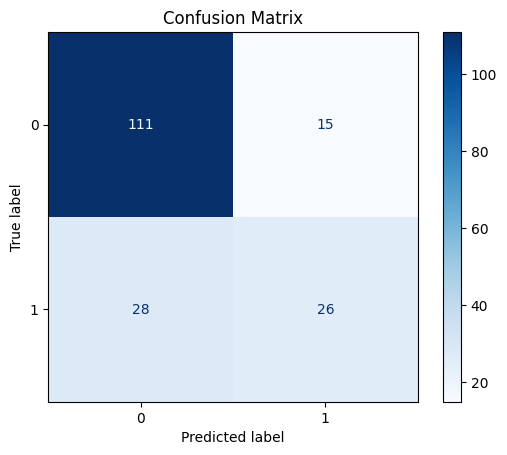


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       126
           1       0.63      0.48      0.55        54

    accuracy                           0.76       180
   macro avg       0.72      0.68      0.69       180
weighted avg       0.75      0.76      0.75       180



In [43]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

xgb = xgb.XGBClassifier(use_label_encoder=False,
                    eval_metric='logloss',
                    enable_categorical=True,
                    scale_pos_weight=scale_pos_weight,
                    objective='binary:logistic',
                    random_state=42 # Added for reproducibility
                    )
print("\nStarting model training...")

xgb.fit(X_train, y_train)

print("Model training complete.")

# --- Evaluation ---

# 1. Make predictions on the validation set
# Predicted classes (0 or 1)
y_pred = xgb.predict(X_val)
y_proba = xgb.predict_proba(X_val)[:, 1]

print("\n--- Model Evaluation on Validation Set ---")

# 2. Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 3. Weighted F1 Score
# 'weighted' accounts for label imbalance when calculating F1
f1_weighted = f1_score(y_val, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1_weighted:.4f}")

# 4. AUC Score (Area Under the ROC Curve)
auc_score = roc_auc_score(y_val, y_proba)
print(f"AUC Score: {auc_score:.4f}")

# 5. Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
# Determine the actual labels (0 and 1 in this case)
# If your original target was 'Yes'/'No', map back for plotting labels
labels = sorted(y_val.unique()) # Should be [0, 1] if .cat.codes was used

print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
# You can provide display_labels if you want 'No Default' and 'Default' on the plot
# Need to know which code (0 or 1) corresponds to which original label
# Assuming 0 is 'No Default' and 1 is 'Default' based on common practice & scale_pos_weight calc
display_labels = ['No Default', 'Default'] if sorted(train_df['default'].unique().astype(str)) == ['No', 'Yes'] else [str(label) for label in labels]


cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cmp.plot(cmap=plt.cm.Blues, values_format='d') # values_format='d' for integer counts
plt.title('Confusion Matrix')
plt.show()


# 6. Classification Report
print("\nClassification Report:")
# Use target_names if you mapped 0/1 back to 'No Default'/'Default' for clarity
target_names = ['No Default', 'Default'] if sorted(train_df['default'].unique().astype(str)) == ['No', 'Yes'] else [str(label) for label in labels]

print(classification_report(y_val, y_pred, target_names=target_names))

In [ ]:
# Save baseline xgb model:
with open(f'{model_folder}/baseline_xgb_sub.pkl', 'wb') as f:
    pickle.dump(xgb, f)

# Categorical Feature and Numerical Feature Interaction Analysis

Checking Balance Statistics by Job Category:
                       job        mean  median         std   min    max
0  mangement self-employed   96.526882    58.0  191.322775 -48.0  873.0
1         skilled employee   92.269231    15.5  204.637202 -50.0  999.0
2  unemployed non-resident  165.000000    57.0  271.800376 -50.0  881.0
3       unskilled resident  101.792308    27.0  213.988433 -50.0  989.0


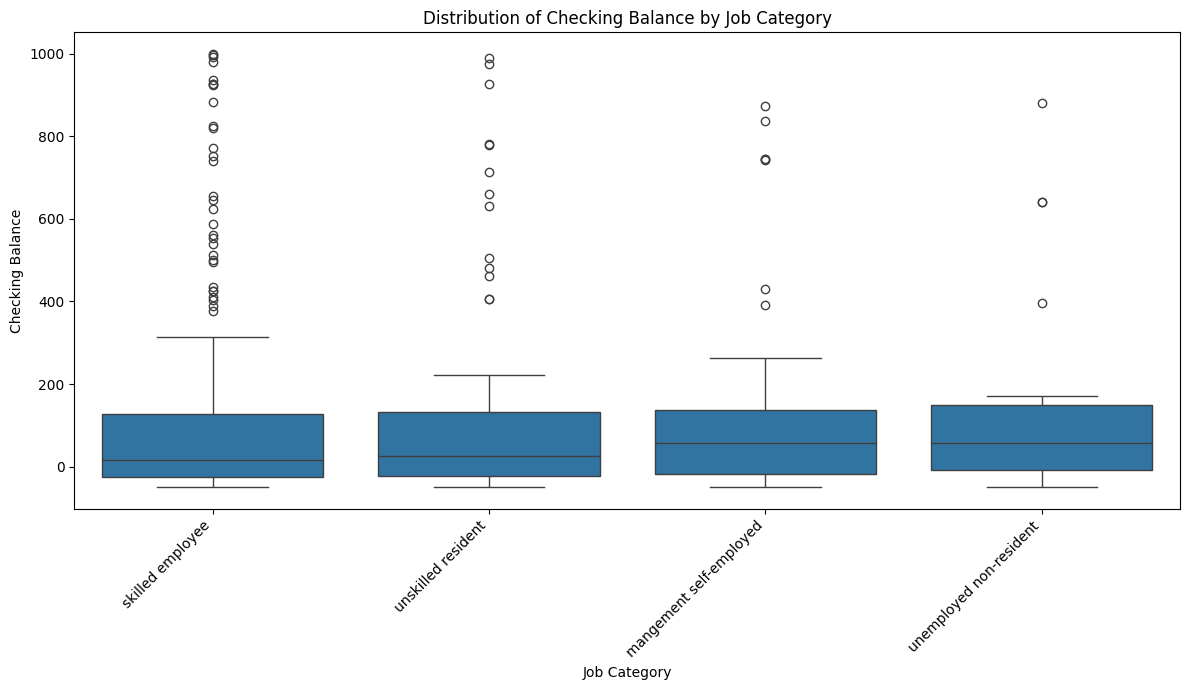


--- Analysis: Checking Balance vs. Default Risk ---
Checking Balance Statistics by Default Status (0=No, 1=Yes):
   default        mean  median         std
0        0  123.167614    42.0  229.266607
1        1   61.322835    -2.0  165.031241


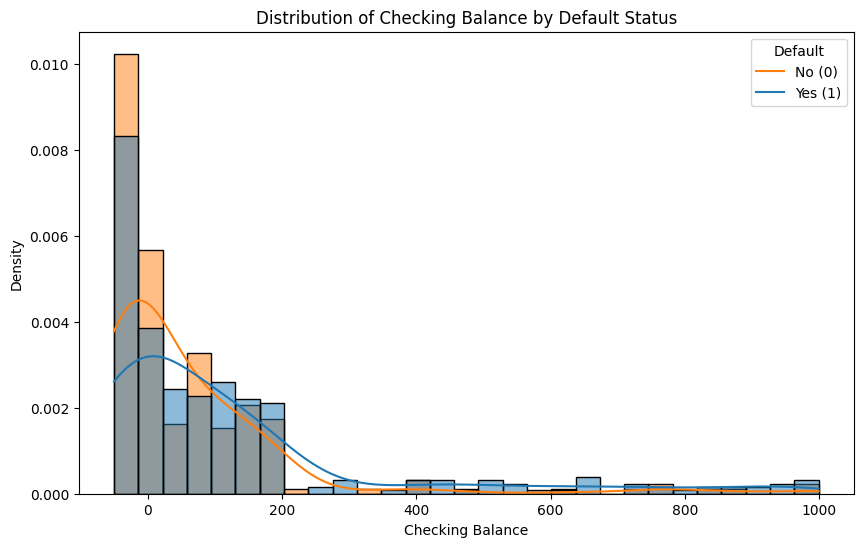

<ipython-input-47-1a90fb7a6ba5>:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_bin_default_rate = df.groupby('balance_bin')['default'].mean().reset_index()


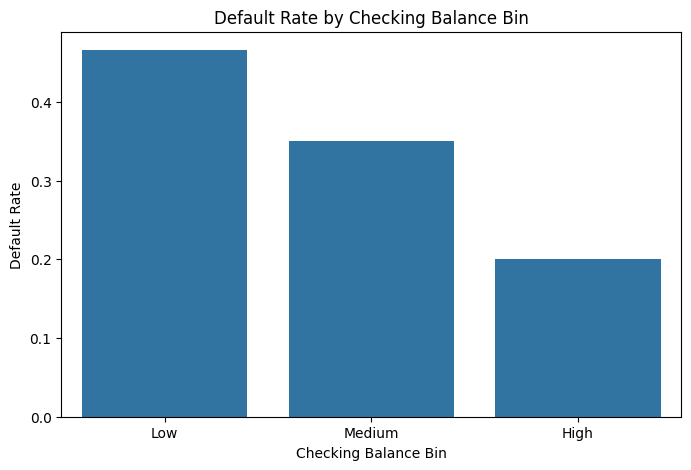


--- Analysis: Combined Effect (Job, Checking Balance, Default) ---

Using threshold for 'Low Checking Balance': below -23.00

Default Rate for Low Checking Balance Individuals by Job Category:
                       job   default
2  unemployed non-resident  1.000000
1         skilled employee  0.535354
3       unskilled resident  0.454545
0  mangement self-employed  0.363636


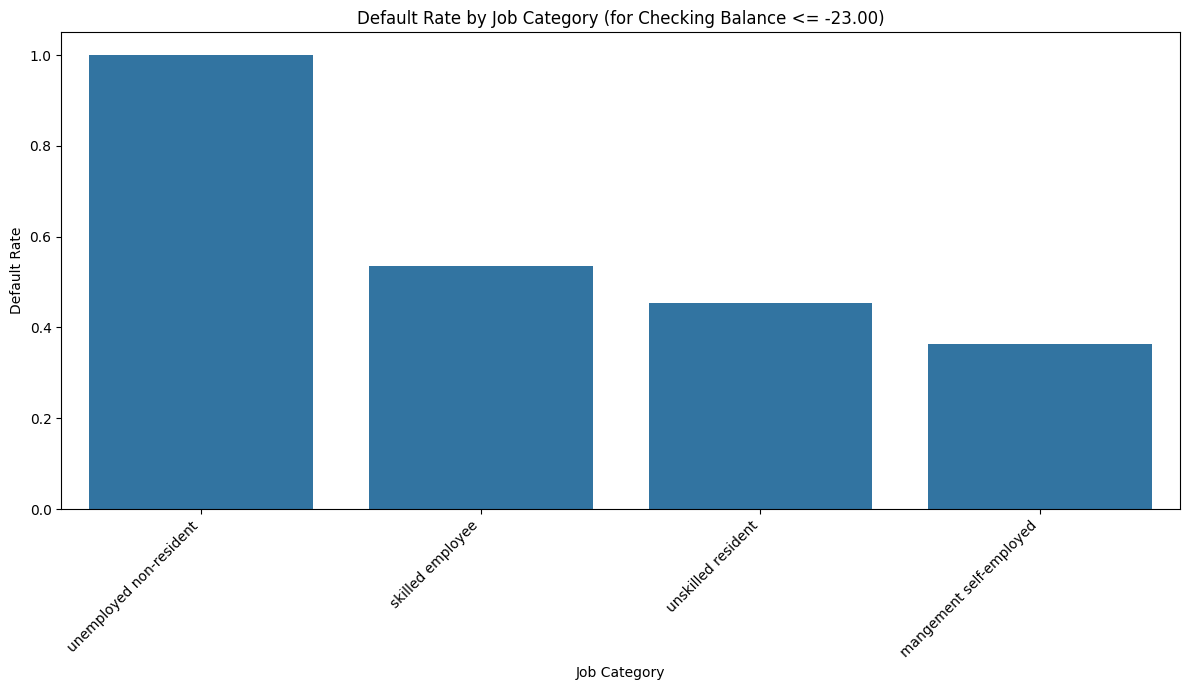

In [47]:
# Scratch Analysis:

# Descriptive statistics by job category
job_balance_stats = credit_data.groupby('job')['checking_balance'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
print("Checking Balance Statistics by Job Category:")
print(job_balance_stats)


# Visualize Checking Balance distribution by Job Category
plt.figure(figsize=(12, 7))
sns.boxplot(x='job', y='checking_balance', data=credit_data)
plt.title('Distribution of Checking Balance by Job Category')
plt.xlabel('Job Category')
plt.ylabel('Checking Balance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# --- Analysis Step 2: Checking Balance vs. Default Risk ---
print("\n--- Analysis: Checking Balance vs. Default Risk ---")

# Descriptive statistics for checking balance by default status
balance_default_stats = credit_data.groupby('default')['checking_balance'].agg(['mean', 'median', 'std']).reset_index()
print("Checking Balance Statistics by Default Status (0=No, 1=Yes):")
print(balance_default_stats)

# Visualize Checking Balance distribution by Default Status
plt.figure(figsize=(10, 6))
sns.histplot(data=credit_data, x='checking_balance', hue='default', kde=True, stat='density', common_norm=False)
plt.title('Distribution of Checking Balance by Default Status')
plt.xlabel('Checking Balance')
plt.ylabel('Density')
plt.legend(title='Default', labels=['No (0)', 'Yes (1)'])
plt.show()


# Bin Checking Balance and calculate default rate per bin
# Define bins - example quartiles or custom thresholds
balance_bins = df['checking_balance'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
# Or use fixed bins, e.g., [0, 100, 500, 1000, max_balance]
# Let's use simple bins based on the distribution observed, e.g., Low (< 100), Medium (100-500), High (>500)
# You'll need to choose appropriate bins based on your data's actual distribution
max_balance = df['checking_balance'].max()
balance_bins = [df['checking_balance'].min(), 100, 500, max_balance] # Example bins
balance_labels = ['Low', 'Medium', 'High']
# Ensure labels match bins - bins should be len(labels) + 1
if len(balance_labels) == len(balance_bins) - 1:
    df['balance_bin'] = pd.cut(df['checking_balance'], bins=balance_bins, labels=balance_labels, include_lowest=True)
    balance_bin_default_rate = df.groupby('balance_bin')['default'].mean().reset_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(x='balance_bin', y='default', data=balance_bin_default_rate, order=balance_labels)
    plt.title('Default Rate by Checking Balance Bin')
    plt.xlabel('Checking Balance Bin')
    plt.ylabel('Default Rate')
    plt.show()
else:
    print("\nWarning: Number of balance bins and labels don't match. Skipping bin analysis plot.")


# --- Analysis Step 3: Combined Effect (Job, Checking Balance, Default) ---
print("\n--- Analysis: Combined Effect (Job, Checking Balance, Default) ---")

# Calculate default rate specifically for low checking balance individuals, grouped by job
# First, identify what 'low' checking balance means. Let's use a threshold, e.g., below the first quartile.
low_balance_threshold = df['checking_balance'].quantile(0.25)
print(f"\nUsing threshold for 'Low Checking Balance': below {low_balance_threshold:.2f}")

df_low_balance = df[df['checking_balance'] <= low_balance_threshold].copy()

if not df_low_balance.empty:
    low_balance_job_default_rate = df_low_balance.groupby('job')['default'].mean().reset_index()
    # Sort for better visualization
    low_balance_job_default_rate = low_balance_job_default_rate.sort_values(by='default', ascending=False)

    print("\nDefault Rate for Low Checking Balance Individuals by Job Category:")
    print(low_balance_job_default_rate)

    plt.figure(figsize=(12, 7))
    sns.barplot(x='job', y='default', data=low_balance_job_default_rate)
    plt.title(f'Default Rate by Job Category (for Checking Balance <= {low_balance_threshold:.2f})')
    plt.xlabel('Job Category')
    plt.ylabel('Default Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo individuals found with checking balance below the low threshold.")



# Categorical and Numerical Interactions


Is a high loan amount particularly risky *only* for individuals with a poor credit history? Or is even a moderate amount risky?

credit history combined with loan amount - how does it connect to risk? or default rate?


Amount bins created using quantiles:
amount_bin
Low         334
Moderate    332
High        334
Name: count, dtype: int64

Default Rate by Credit History and Amount Bin:
            credit_history amount_bin   default
0                 critical        Low  0.137255
1                 critical   Moderate  0.127660
2                 critical       High  0.247423
3                  delayed        Low  0.235294
4                  delayed   Moderate  0.392857
5                  delayed       High  0.302326
6             fully repaid        Low  0.571429
7             fully repaid   Moderate  0.555556
8             fully repaid       High  0.666667
9   fully repaid this bank        Low  0.722222
10  fully repaid this bank   Moderate  0.461538
11  fully repaid this bank       High  0.500000
12                  repaid        Low  0.315789
13                  repaid   Moderate  0.265957
14                  repaid       High  0.388158


<ipython-input-48-adfd2b9ea65e>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_combo = df.groupby(['credit_history', 'amount_bin'])['default'].mean().reset_index()


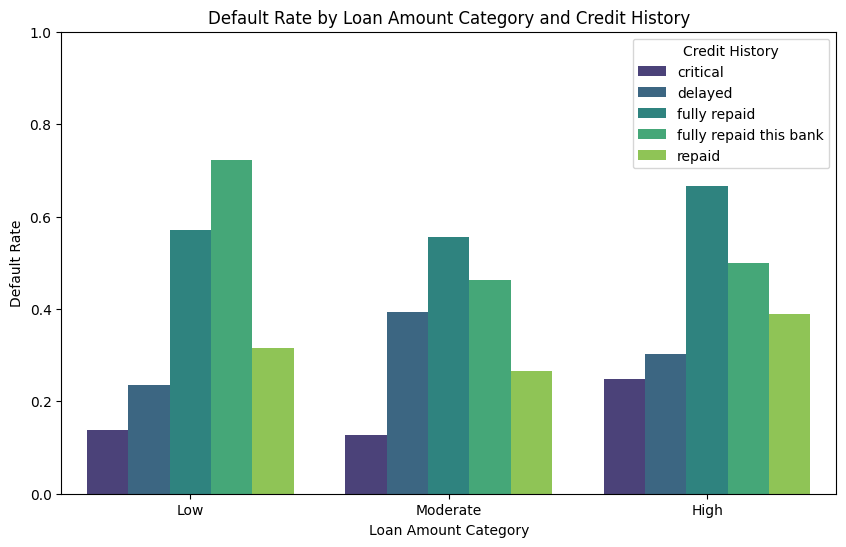

In [48]:
try:
    df['amount_bin'] = pd.qcut(df['amount'], q=3, labels=['Low', 'Moderate', 'High'])
    print("\nAmount bins created using quantiles:")
    print(df['amount_bin'].value_counts().sort_index())

    # 2. Calculate Default Rates by credit_history and amount_bin
    default_rate_by_combo = df.groupby(['credit_history', 'amount_bin'])['default'].mean().reset_index()
    print("\nDefault Rate by Credit History and Amount Bin:")
    print(default_rate_by_combo)

    # 3. Visualize the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='amount_bin', y='default', hue='credit_history', data=default_rate_by_combo, palette='viridis')
    plt.title('Default Rate by Loan Amount Category and Credit History')
    plt.xlabel('Loan Amount Category')
    plt.ylabel('Default Rate')
    plt.legend(title='Credit History')
    plt.ylim(0, 1) # Set y-axis limits to represent probability
    plt.show()

except Exception as e:
    print(f"\nCould not create amount bins or plot. Error: {e}")
    print("This might happen if 'amount' has too few unique values for q=3 or data is insufficient.")
    # If qcut fails, you could try fixed width bins instead:
    # bins = [df['amount'].min(), 2000, 5000, df['amount'].max()]
    # labels = ['Low', 'Moderate', 'High']
    # df['amount_bin'] = pd.cut(df['amount'], bins=bins, labels=labels, include_lowest=True)
    # Then re-run steps 2 and 3

The Loan Amont doesn't amount to a sharp contrast or difference between different loan amounts, the default distribution is similar across loan amounts

# Large_loan vs purpose interactions

Does a large loan amount have different risk profiles depending on the purpose (e.g., a large business loan vs. a large car loan)?




Defining 'Large Amount' as > 3972.25 (75th percentile)
Number of large loans in the dataset: 250

Default Rate for LARGE Loans by Purpose:
               purpose   default
4            education  0.538462
0             business  0.512821
1            car (new)  0.500000
6               others  0.500000
5            furniture  0.500000
7             radio/tv  0.358974
2           car (used)  0.266667
8              repairs  0.250000
3  domestic appliances  0.000000

Overall Default Rate by Purpose (All Loan Amounts):
               purpose   default
4            education  0.440000
6               others  0.416667
1            car (new)  0.380342
8              repairs  0.363636
0             business  0.350515
3  domestic appliances  0.333333
5            furniture  0.320442
7             radio/tv  0.221429
2           car (used)  0.165049
9           retraining  0.111111


<ipython-input-49-efc0513ac175>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='purpose', y='default', data=large_loan_default_rate_by_purpose, palette='YlOrRd')


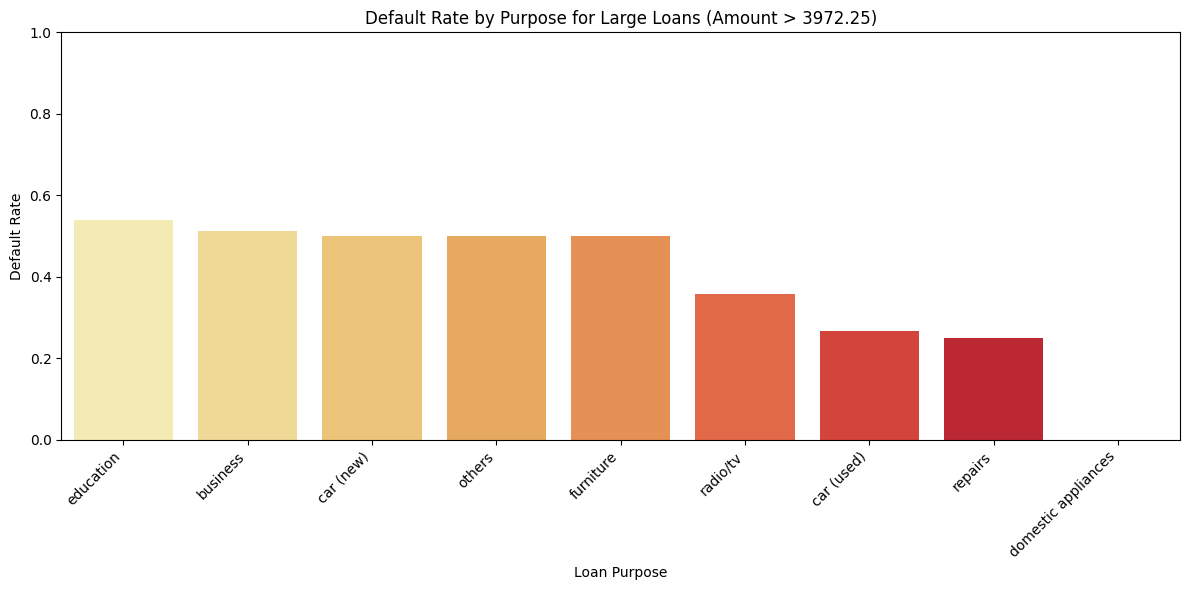

<ipython-input-49-efc0513ac175>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='purpose', y='default', data=overall_default_rate_by_purpose, palette='Blues_d')


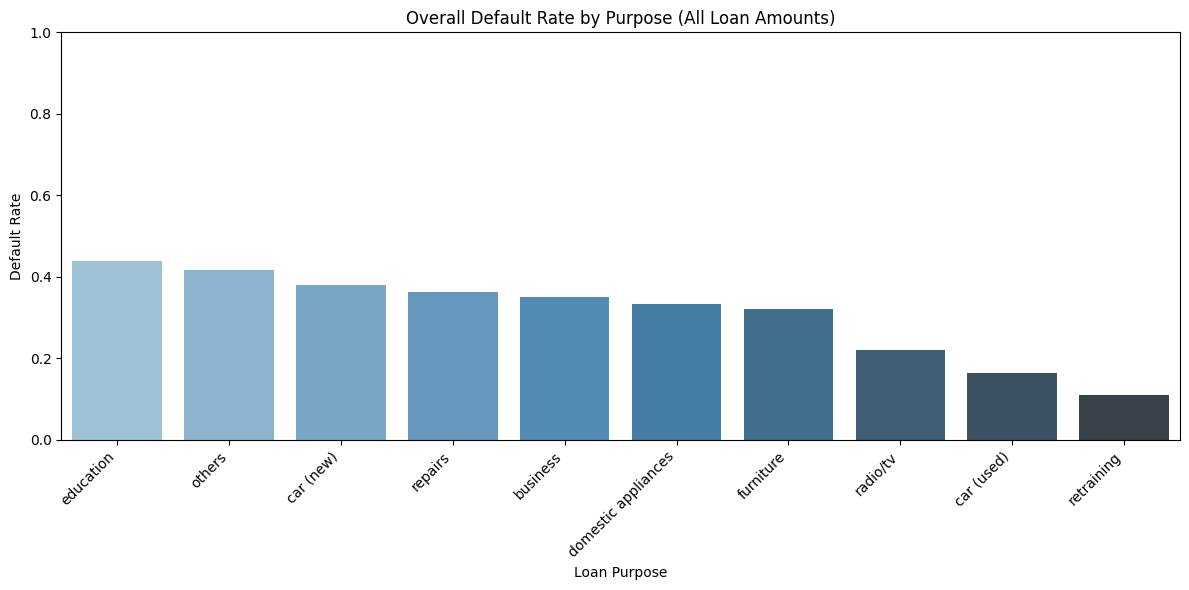

In [49]:
# 1. Define "Large Loan Amount" threshold
# Using the 75th percentile (top 25%) as an example
large_amount_threshold = df['amount'].quantile(0.75)
print(f"\nDefining 'Large Amount' as > {large_amount_threshold:.2f} (75th percentile)")

# 2. Filter the Data for large loans
df_large_loans = df[df['amount'] > large_amount_threshold].copy()
print(f"Number of large loans in the dataset: {len(df_large_loans)}")

if len(df_large_loans) > 0:
    # 3. Calculate Default Rate by Purpose (for Large Loans)
    large_loan_default_rate_by_purpose = df_large_loans.groupby('purpose')['default'].mean().reset_index()
    large_loan_default_rate_by_purpose = large_loan_default_rate_by_purpose.sort_values(by='default', ascending=False)
    print("\nDefault Rate for LARGE Loans by Purpose:")
    print(large_loan_default_rate_by_purpose)

    # 4. Calculate Overall Default Rate by Purpose (for context)
    overall_default_rate_by_purpose = df.groupby('purpose')['default'].mean().reset_index()
    overall_default_rate_by_purpose = overall_default_rate_by_purpose.sort_values(by='default', ascending=False)
    print("\nOverall Default Rate by Purpose (All Loan Amounts):")
    print(overall_default_rate_by_purpose)

    # 5. Visualize and Compare

    # Plot for Large Loans Only
    plt.figure(figsize=(12, 6))
    sns.barplot(x='purpose', y='default', data=large_loan_default_rate_by_purpose, palette='YlOrRd')
    plt.title(f'Default Rate by Purpose for Large Loans (Amount > {large_amount_threshold:.2f})')
    plt.xlabel('Loan Purpose')
    plt.ylabel('Default Rate')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1) # Ensure y-axis is 0 to 1 for rate
    plt.tight_layout()
    plt.show()

    # Plot for Overall Loans (Context)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='purpose', y='default', data=overall_default_rate_by_purpose, palette='Blues_d')
    plt.title('Overall Default Rate by Purpose (All Loan Amounts)')
    plt.xlabel('Loan Purpose')
    plt.ylabel('Default Rate')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1) # Ensure y-axis is 0 to 1 for rate
    plt.tight_layout()
    plt.show()

else:
    print("\nNo loans found above the specified 'large amount' threshold. Cannot perform analysis.")

# Age vs Loan Duration


Age bins created:
age_bin
18-30 (Young)    411
31-45 (Mid)      403
46-60 (Older)    141
61+ (Senior)      45
Name: count, dtype: int64

Duration bins created:
duration_bin
Short        359
Medium       187
Long         224
Very Long    230
Name: count, dtype: int64

Default Rate by Age Bin and Duration Bin:
          age_bin duration_bin      mean  count
0   18-30 (Young)        Short  0.300000    140
1   18-30 (Young)       Medium  0.304878     82
2   18-30 (Young)         Long  0.315217     92
3   18-30 (Young)    Very Long  0.536082     97
4     31-45 (Mid)        Short  0.145985    137
5     31-45 (Mid)       Medium  0.316456     79
6     31-45 (Mid)         Long  0.329670     91
7     31-45 (Mid)    Very Long  0.312500     96
8   46-60 (Older)        Short  0.183333     60
9   46-60 (Older)       Medium  0.176471     17
10  46-60 (Older)         Long  0.181818     33
11  46-60 (Older)    Very Long  0.548387     31
12   61+ (Senior)        Short  0.136364     22
13   61+ (Senior)

<ipython-input-51-0b4af999a7b6>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_combo = df.groupby(['age_bin', 'duration_bin'])['default'].agg(['mean', 'count']).reset_index()
<ipython-input-51-0b4af999a7b6>:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = default_rate_combo.pivot_table(index='age_bin', columns='duration_bin', values='mean')


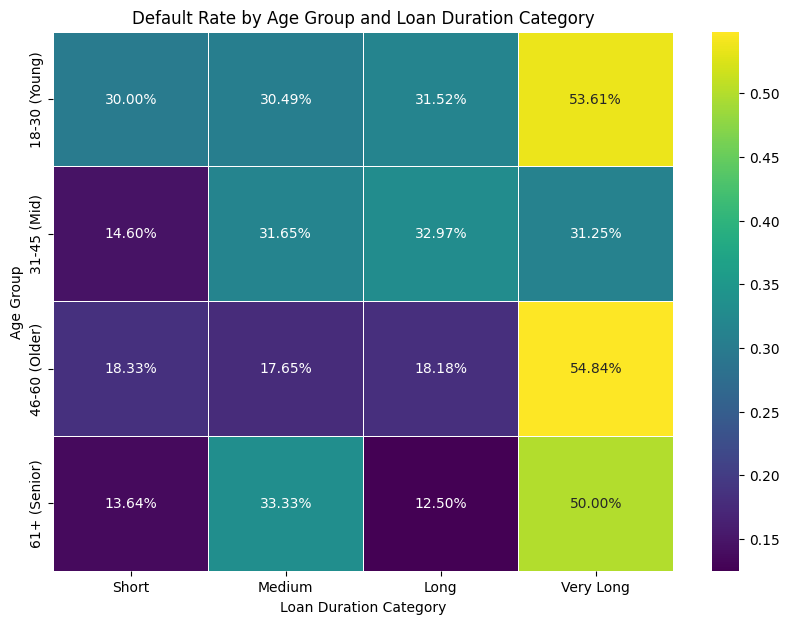


--- Analysis Focused on 'Very Long' Duration Loans ---
Default Rate and Count for 'Very Long' Duration Loans by Age Group:
          age_bin      mean  count
3   18-30 (Young)  0.536082     97
7     31-45 (Mid)  0.312500     96
11  46-60 (Older)  0.548387     31
15   61+ (Senior)  0.500000      6


<ipython-input-51-0b4af999a7b6>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_bin', y='mean', data=very_long_defaults, palette='Reds_d')


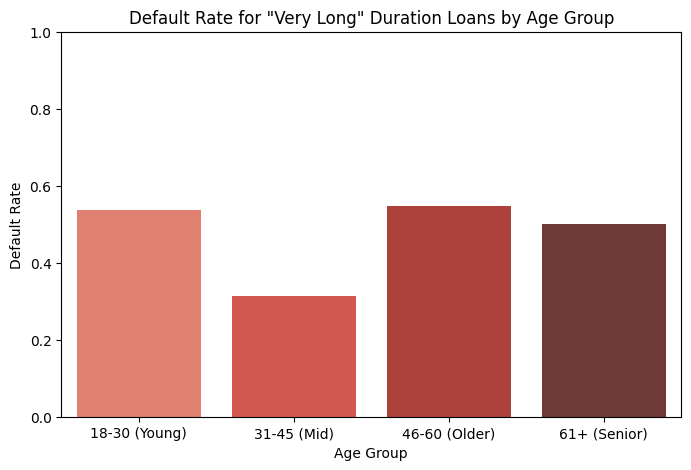

In [51]:
# --- Analysis ---

# 1. Create Bins for Age and Duration

# Age Bins (Example: Adjust based on your actual age distribution)
age_bins = [18, 30, 45, 60, df['age'].max()]
age_labels = ['18-30 (Young)', '31-45 (Mid)', '46-60 (Older)', '61+ (Senior)']
try:
    # Use include_lowest=True for the first bin, right=True is default
    df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)
    print("\nAge bins created:")
    print(df['age_bin'].value_counts().sort_index())
except ValueError as e:
    print(f"\nError creating age bins: {e}. Adjust bins based on data range.")
    df['age_bin'] = None # Assign None if binning fails

# Duration Bins (Example: Using quantiles for 4 groups)
try:
    df['duration_bin'] = pd.qcut(df['months_loan_duration'], q=4, labels=['Short', 'Medium', 'Long', 'Very Long'])
    print("\nDuration bins created:")
    print(df['duration_bin'].value_counts().sort_index())
except ValueError as e:
    print(f"\nError creating duration bins: {e}. Could be too few unique values for q=4.")
    df['duration_bin'] = None # Assign None if binning fails


# Proceed only if binning was successful
if df['age_bin'] is not None and df['duration_bin'] is not None:

    # 2. Calculate Default Rates by Combined Bins
    default_rate_combo = df.groupby(['age_bin', 'duration_bin'])['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Age Bin and Duration Bin:")
    print(default_rate_combo)

    # 3. Visualize using a Heatmap
    try:
        heatmap_data = default_rate_combo.pivot_table(index='age_bin', columns='duration_bin', values='mean')
        plt.figure(figsize=(10, 7))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="viridis", linewidths=.5)
        plt.title('Default Rate by Age Group and Loan Duration Category')
        plt.xlabel('Loan Duration Category')
        plt.ylabel('Age Group')
        plt.show()
    except Exception as e:
        print(f"\nCould not generate heatmap: {e}")


    # 4. Focus on "Very Long" Duration Loans
    print("\n--- Analysis Focused on 'Very Long' Duration Loans ---")
    very_long_defaults = default_rate_combo[default_rate_combo['duration_bin'] == 'Very Long']
    print("Default Rate and Count for 'Very Long' Duration Loans by Age Group:")
    print(very_long_defaults[['age_bin', 'mean', 'count']])

    # Visualize default rate for Very Long loans by Age Group
    plt.figure(figsize=(8, 5))
    sns.barplot(x='age_bin', y='mean', data=very_long_defaults, palette='Reds_d')
    plt.title('Default Rate for "Very Long" Duration Loans by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Default Rate')
    plt.ylim(0, 1) # Ensure y-axis is 0 to 1 for rate
    plt.show()

# Age Combined with Amount

- Is a very large loan riskier for very young or very old individuals?

Yes, very large loans appear riskier for very young individuals (62.5% default rate) compared to very old individuals (40.0% default rate) in this dataset.


Defining 'Very Large Amount' as > 7179.40 (90th percentile)
Number of very large loans found: 100
Defining 'Very Young' as <= 25
Defining 'Very Old' as >= 60

Age groups for Very Large Loans:
age_group_large_loan
Middle Age    79
Very Young    16
Very Old       5
Name: count, dtype: int64

Default Rate for VERY LARGE Loans by Defined Age Group:
  age_group_large_loan      mean  count
0           Very Young  0.625000     16
1           Middle Age  0.443038     79
2             Very Old  0.400000      5


<ipython-input-52-9e4fd10403ee>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group_large_loan', y='mean', data=default_rate_large_loan_by_age, order=age_order, palette='coolwarm')


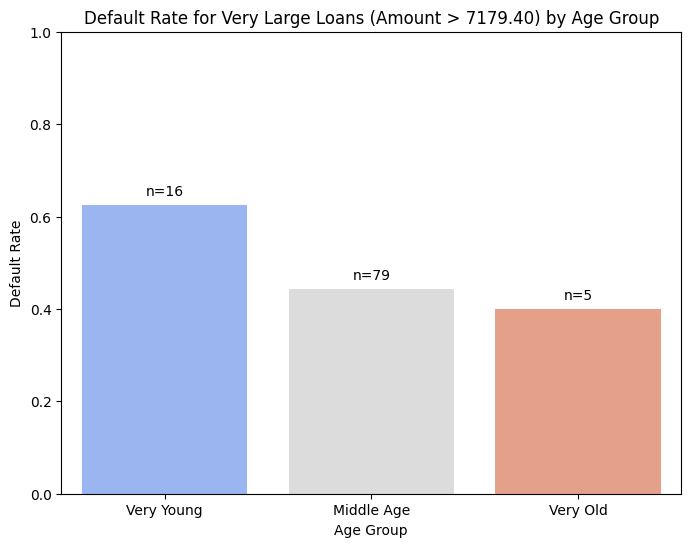

In [52]:
# --- Analysis ---

# 1. Define "Very Large Loan" threshold
# Using the 90th percentile as an example
very_large_threshold = df['amount'].quantile(0.90)
print(f"\nDefining 'Very Large Amount' as > {very_large_threshold:.2f} (90th percentile)")

# 3. Filter for Very Large Loans
df_very_large_loans = df[df['amount'] > very_large_threshold].copy()
print(f"Number of very large loans found: {len(df_very_large_loans)}")

if len(df_very_large_loans) > 0:
    # 2. Define Age Categories
    young_threshold = 25
    old_threshold = 60
    print(f"Defining 'Very Young' as <= {young_threshold}")
    print(f"Defining 'Very Old' as >= {old_threshold}")

    # 4. Categorize Age within the Filtered Data
    # Create conditions
    conditions = [
        df_very_large_loans['age'] <= young_threshold,
        df_very_large_loans['age'] >= old_threshold
    ]
    # Create choices corresponding to conditions
    choices = ['Very Young', 'Very Old']
    # Default choice if neither condition is met
    default_choice = 'Middle Age'

    df_very_large_loans['age_group_large_loan'] = np.select(conditions, choices, default=default_choice)
    print("\nAge groups for Very Large Loans:")
    print(df_very_large_loans['age_group_large_loan'].value_counts())


    # 5. Calculate Default Rates within the Filtered Data by Age Category
    default_rate_large_loan_by_age = df_very_large_loans.groupby('age_group_large_loan')['default'].agg(['mean', 'count']).reset_index()
    # Ensure all categories are present for plotting order, even if count is 0
    age_order = ['Very Young', 'Middle Age', 'Very Old']
    default_rate_large_loan_by_age = default_rate_large_loan_by_age.set_index('age_group_large_loan').reindex(age_order).fillna(0).reset_index() # Fill NA might be needed if a category has 0 loans

    print("\nDefault Rate for VERY LARGE Loans by Defined Age Group:")
    print(default_rate_large_loan_by_age)

    # 6. Visualize
    plt.figure(figsize=(8, 6))
    sns.barplot(x='age_group_large_loan', y='mean', data=default_rate_large_loan_by_age, order=age_order, palette='coolwarm')
    plt.title(f'Default Rate for Very Large Loans (Amount > {very_large_threshold:.2f}) by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Default Rate')
    plt.ylim(0, 1) # Ensure y-axis is 0 to 1 for rate

    # Add counts on bars for context (optional)
    for index, row in default_rate_large_loan_by_age.iterrows():
        plt.text(index, row['mean'] + 0.02, f"n={int(row['count'])}", color='black', ha="center")

    plt.show()

# Installment rate combined with amount

Is a high installment rate worse when combined with a high loan amount? Thus indicating a potentially unsustainable repayment burden relative to income (though income isn't explicit, age/job might be proxies).


High loan amounts with high installment rates increases the burden of repayment thus leading to higher risk of default.


Amount bins created:
amount_bin
Low         334
Moderate    332
High        334
Name: count, dtype: int64

Default Rate by Amount Bin and Installment Rate:
   amount_bin  installment_rate      mean  count
0         Low                 1  0.241379     29
1         Low                 2  0.234043     47
2         Low                 3  0.255319     47
3         Low                 4  0.308057    211
4    Moderate                 1  0.138889     36
5    Moderate                 2  0.220779     77
6    Moderate                 3  0.183673     49
7    Moderate                 4  0.311765    170
8        High                 1  0.309859     71
9        High                 2  0.317757    107
10       High                 3  0.393443     61
11       High                 4  0.431579     95


<ipython-input-54-f580ef0c248b>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_combo = df.groupby(['amount_bin', 'installment_rate'])['default'].agg(['mean', 'count']).reset_index()


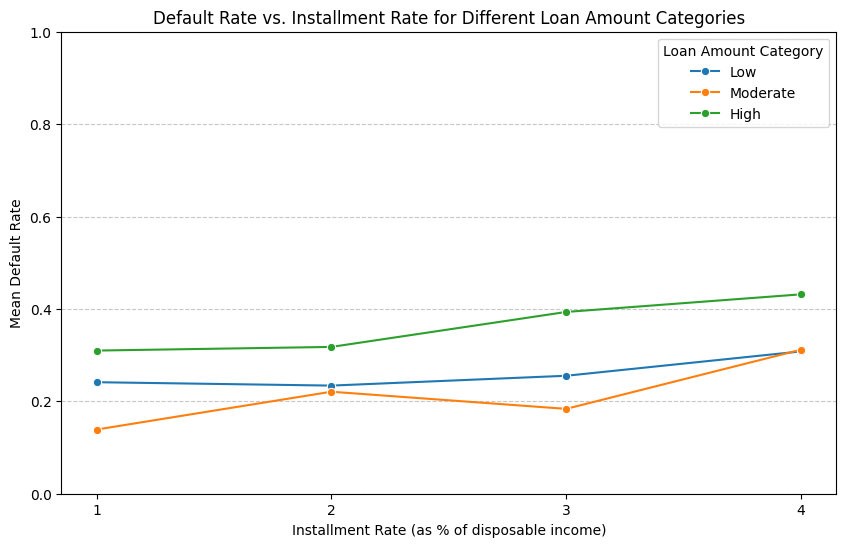

In [54]:
# --- Analysis ---

# 1. Categorize 'amount'
# Using tertiles (3 groups) as an example
try:
    df['amount_bin'] = pd.qcut(df['amount'], q=3, labels=['Low', 'Moderate', 'High'])
    print("\nAmount bins created:")
    print(df['amount_bin'].value_counts().sort_index())
except ValueError as e:
    print(f"\nError creating amount bins: {e}. Adjust q or use fixed bins.")
    df['amount_bin'] = None # Assign None if binning fails

# Proceed only if binning was successful
if df['amount_bin'] is not None:

    # 2. Group Data & 3. Calculate Default Rates
    default_rate_combo = df.groupby(['amount_bin', 'installment_rate'])['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Amount Bin and Installment Rate:")
    print(default_rate_combo)

    # 4. Visualize using a Line Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='installment_rate', y='mean', hue='amount_bin', data=default_rate_combo, marker='o', palette='tab10')

    # Optional: Add point labels for counts (can get cluttered)
    # for line in range(0, default_rate_combo.shape[0]):
    #      plt.text(default_rate_combo.installment_rate[line], default_rate_combo['mean'][line]+0.01,
    #               f"n={default_rate_combo['count'][line]}", horizontalalignment='center', size='small', color='black')


    plt.title('Default Rate vs. Installment Rate for Different Loan Amount Categories')
    plt.xlabel('Installment Rate (as % of disposable income)')
    plt.ylabel('Mean Default Rate')
    plt.xticks(sorted(df['installment_rate'].unique())) # Ensure ticks are 1, 2, 3, 4
    plt.ylim(0, max(1.0, default_rate_combo['mean'].max() * 1.1)) # Adjust y-axis limit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Loan Amount Category')
    plt.show()

## Does having property significantly reduce the risk only for high loan amounts, or is the effect more general?

Answer: No


'has_real_estate' flag created:
property                  has_real_estate
other                     False              332
real estate               True               282
building society savings  False              232
unknown/none              False              154
Name: count, dtype: int64

Amount bins created:
amount_bin
Low         334
Moderate    332
High        334
Name: count, dtype: int64

Default Rate by Amount Bin and Real Estate Ownership:
  amount_bin  has_real_estate      mean  count
0        Low            False  0.364103    195
1        Low             True  0.172662    139
2   Moderate            False  0.250000    236
3   Moderate             True  0.260417     96
4       High            False  0.383275    287
5       High             True  0.234043     47


<ipython-input-55-db235eeca232>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_combo = df.groupby(['amount_bin', 'has_real_estate'])['default'].agg(['mean', 'count']).reset_index()


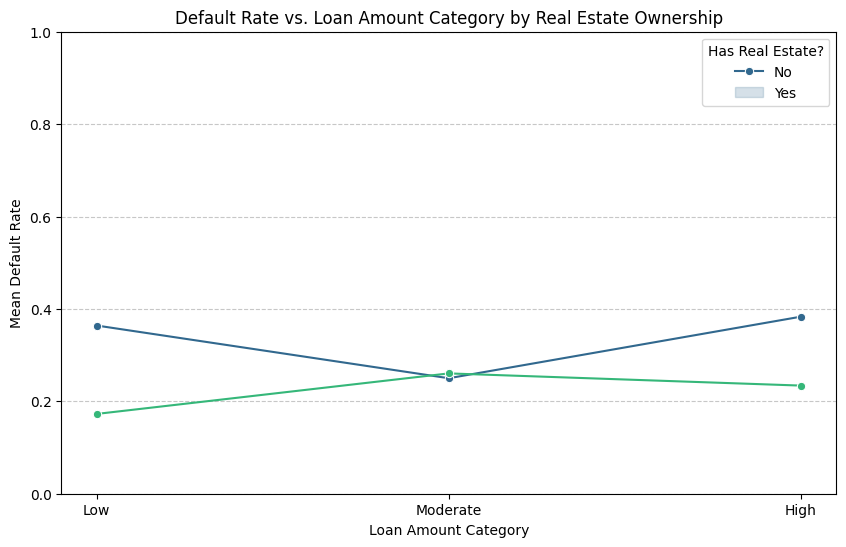


Calculated Risk Reduction (No Real Estate Rate - Real Estate Rate):
has_real_estate  risk_reduction
amount_bin                     
Low                    0.191441
Moderate              -0.010417
High                   0.149233

Based on these observations, conclude whether the risk-reducing effect of property is general or specific to high loan amounts.


In [55]:
# --- Analysis ---

# 1. Define "Having Property" (using 'real estate' as the key property type)
df['has_real_estate'] = (df['property'] == 'real estate')
print("\n'has_real_estate' flag created:")
print(df[['property', 'has_real_estate']].value_counts())

# 2. Categorize 'amount'
# Using tertiles (3 groups)
try:
    amount_bins = ['Low', 'Moderate', 'High']
    df['amount_bin'] = pd.qcut(df['amount'], q=3, labels=amount_bins)
    print("\nAmount bins created:")
    print(df['amount_bin'].value_counts().sort_index())
except ValueError as e:
    print(f"\nError creating amount bins: {e}. Adjust q or use fixed bins.")
    df['amount_bin'] = None # Assign None if binning fails

# Proceed only if binning was successful
if df['amount_bin'] is not None:

    # 3. Group Data & 4. Calculate Default Rates
    default_rate_combo = df.groupby(['amount_bin', 'has_real_estate'])['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Amount Bin and Real Estate Ownership:")
    print(default_rate_combo)

    # 5. Visualize using a Line Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='amount_bin', y='mean', hue='has_real_estate', data=default_rate_combo, marker='o', palette='viridis')

    plt.title('Default Rate vs. Loan Amount Category by Real Estate Ownership')
    plt.xlabel('Loan Amount Category')
    plt.ylabel('Mean Default Rate')
    # Ensure x-axis order if necessary (should be automatic for categorical)
    # plt.xticks(ticks=range(len(amount_bins)), labels=amount_bins) # Might be needed if x treated numerically
    plt.ylim(0, max(1.0, default_rate_combo['mean'].max() * 1.1)) # Adjust y-axis limit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Has Real Estate?', labels=['No', 'Yes']) # Adjust labels based on boolean order
    plt.show()

    # Calculate the difference explicitly (optional)
    pivot_table = default_rate_combo.pivot(index='amount_bin', columns='has_real_estate', values='mean')
    if False in pivot_table.columns and True in pivot_table.columns:
         pivot_table['risk_reduction'] = pivot_table[False] - pivot_table[True]
         print("\nCalculated Risk Reduction (No Real Estate Rate - Real Estate Rate):")
         print(pivot_table[['risk_reduction']])
    else:
         print("\nCould not calculate risk reduction (missing True or False column).")


    print("\nBased on these observations, conclude whether the risk-reducing effect of property is general or specific to high loan amounts.")

else:
    print("\nSkipping analysis due to errors in creating amount bins.")

# Analysis for Combining Numerical Datasets


--- Analysis 1: Loan Amount vs. Default Rate ---

Amount bins created:
amount_bin
Amount Q1 (Low)     250
Amount Q2           250
Amount Q3           250
Amount Q4 (High)    250
Name: count, dtype: int64

Default Rate by Amount Bin:
         amount_bin   mean  count
0   Amount Q1 (Low)  0.308    250
1         Amount Q2  0.248    250
2         Amount Q3  0.224    250
3  Amount Q4 (High)  0.420    250


<ipython-input-56-65e8fff1f59f>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amount_default_rate = df.groupby('amount_bin')['default'].agg(['mean', 'count']).reset_index()
<ipython-input-56-65e8fff1f59f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='amount_bin', y='mean', data=amount_default_rate, palette='viridis')


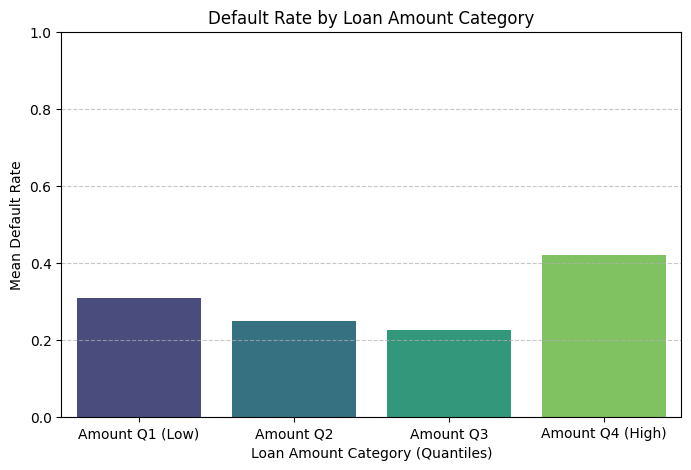


--- Analysis 2: Loan Duration vs. Default Rate ---

Duration bins created:
duration_bin
Duration Q1 (Short)    359
Duration Q2            187
Duration Q3            224
Duration Q4 (Long)     230
Name: count, dtype: int64

Default Rate by Duration Bin:
          duration_bin      mean  count
0  Duration Q1 (Short)  0.211699    359
1          Duration Q2  0.299465    187
2          Duration Q3  0.294643    224
3   Duration Q4 (Long)  0.443478    230


<ipython-input-56-65e8fff1f59f>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_default_rate = df.groupby('duration_bin')['default'].agg(['mean', 'count']).reset_index()
<ipython-input-56-65e8fff1f59f>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='duration_bin', y='mean', data=duration_default_rate, palette='magma')


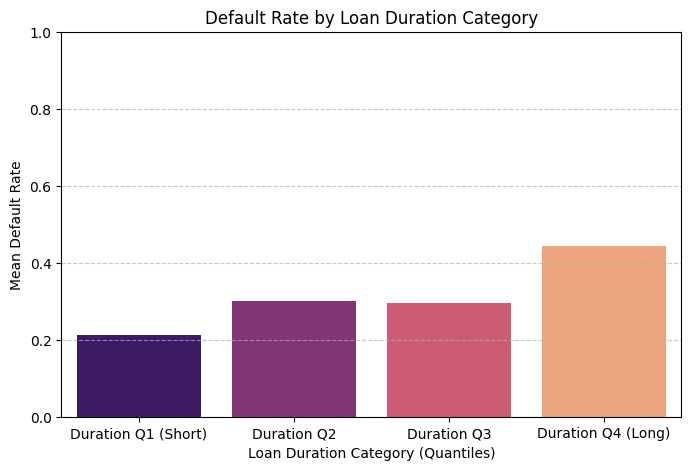


--- Analysis 3: Combined Amount & Duration vs. Default Rate ---

Default Rate by Combined Amount and Duration Bins:
        amount_bin         duration_bin      mean  count
0  Amount Q1 (Low)  Duration Q1 (Short)  0.258621    174
1  Amount Q1 (Low)          Duration Q2  0.377778     45
2  Amount Q1 (Low)          Duration Q3  0.500000     30
3  Amount Q1 (Low)   Duration Q4 (Long)  0.000000      1
4        Amount Q2  Duration Q1 (Short)  0.149123    114


<ipython-input-56-65e8fff1f59f>:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combo_default_rate = df.groupby(['amount_bin', 'duration_bin'])['default'].agg(['mean', 'count']).reset_index()
<ipython-input-56-65e8fff1f59f>:73: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = combo_default_rate.pivot_table(index='amount_bin', columns='duration_bin', values='mean')
<ipython-input-56-65e8fff1f59f>:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_counts = 

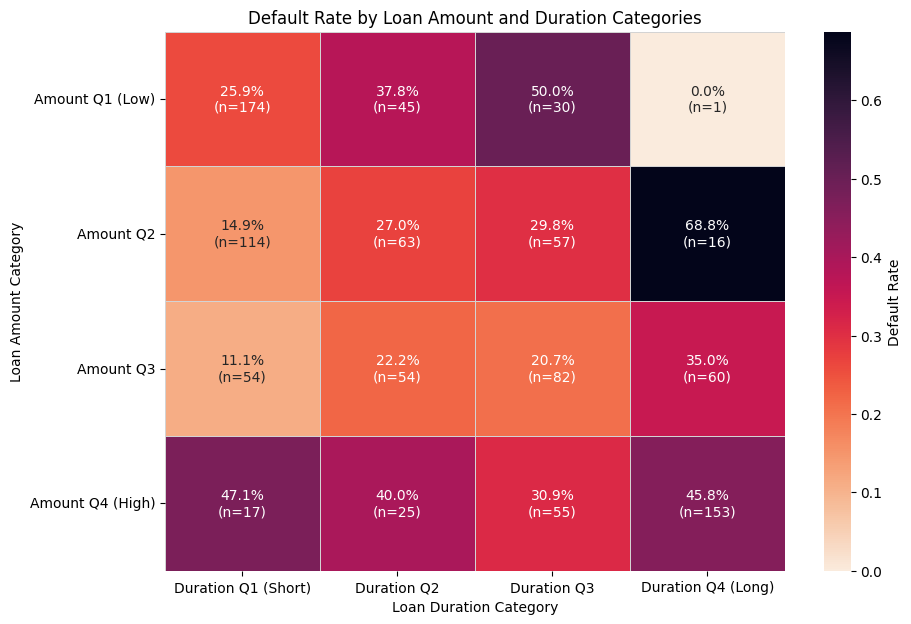

In [56]:
# --- Analysis 1: Amount vs. Default Rate ---
print("\n--- Analysis 1: Loan Amount vs. Default Rate ---")

# Create bins for loan amount (e.g., using quantiles for 4 groups)
try:
    amount_labels = ['Amount Q1 (Low)', 'Amount Q2', 'Amount Q3', 'Amount Q4 (High)']
    df['amount_bin'] = pd.qcut(df['amount'], q=4, labels=amount_labels)
    print("\nAmount bins created:")
    print(df['amount_bin'].value_counts().sort_index())

    # Calculate default rate per amount bin
    amount_default_rate = df.groupby('amount_bin')['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Amount Bin:")
    print(amount_default_rate)

    # Visualize
    plt.figure(figsize=(8, 5))
    sns.barplot(x='amount_bin', y='mean', data=amount_default_rate, palette='viridis')
    plt.title('Default Rate by Loan Amount Category')
    plt.xlabel('Loan Amount Category (Quantiles)')
    plt.ylabel('Mean Default Rate')
    plt.ylim(0, max(1.0, amount_default_rate['mean'].max() * 1.1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

except ValueError as e:
    print(f"\nError creating amount bins (maybe too few unique values for q=4): {e}")
    df['amount_bin'] = None # Mark as failed

# --- Analysis 2: Loan Duration vs. Default Rate ---
print("\n--- Analysis 2: Loan Duration vs. Default Rate ---")

# Create bins for loan duration (e.g., using quantiles for 4 groups)
try:
    duration_labels = ['Duration Q1 (Short)', 'Duration Q2', 'Duration Q3', 'Duration Q4 (Long)']
    df['duration_bin'] = pd.qcut(df['months_loan_duration'], q=4, labels=duration_labels)
    print("\nDuration bins created:")
    print(df['duration_bin'].value_counts().sort_index())

    # Calculate default rate per duration bin
    duration_default_rate = df.groupby('duration_bin')['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Duration Bin:")
    print(duration_default_rate)

    # Visualize
    plt.figure(figsize=(8, 5))
    sns.barplot(x='duration_bin', y='mean', data=duration_default_rate, palette='magma')
    plt.title('Default Rate by Loan Duration Category')
    plt.xlabel('Loan Duration Category (Quantiles)')
    plt.ylabel('Mean Default Rate')
    plt.ylim(0, max(1.0, duration_default_rate['mean'].max() * 1.1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

except ValueError as e:
    print(f"\nError creating duration bins (maybe too few unique values for q=4): {e}")
    df['duration_bin'] = None # Mark as failed


# --- Analysis 3: Combined Amount & Duration vs. Default Rate ---
print("\n--- Analysis 3: Combined Amount & Duration vs. Default Rate ---")

# Proceed only if both binning steps were successful
if df['amount_bin'] is not None and df['duration_bin'] is not None:

    # Group by both bins and calculate default rate
    combo_default_rate = df.groupby(['amount_bin', 'duration_bin'])['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Combined Amount and Duration Bins:")
    print(combo_default_rate.head()) # Print first few rows

    # Pivot data for heatmap visualization
    try:
        heatmap_data = combo_default_rate.pivot_table(index='amount_bin', columns='duration_bin', values='mean')
        heatmap_counts = combo_default_rate.pivot_table(index='amount_bin', columns='duration_bin', values='count').fillna(0).astype(int) # Get counts for context

        # Create combined annotation strings (Rate% \n n=Count)
        annot_labels = heatmap_data.applymap(lambda x: f'{x:.1%}' if pd.notna(x) else '') # Format mean as percentage
        annot_labels = annot_labels + '\n(n=' + heatmap_counts.astype(str) + ')' # Add count info

        # Visualize using heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(heatmap_data,
                    annot=annot_labels, # Show rate and count
                    fmt="", # Use empty format string as labels are pre-formatted
                    cmap="rocket_r", # Choose a sequential colormap (darker = higher risk)
                    linewidths=.5,
                    linecolor='lightgray',
                    cbar_kws={'label': 'Default Rate'}) # Add label to color bar
        plt.title('Default Rate by Loan Amount and Duration Categories')
        plt.xlabel('Loan Duration Category')
        plt.ylabel('Loan Amount Category')
        plt.yticks(rotation=0) # Keep y-axis labels horizontal
        plt.show()

    except Exception as e:
        print(f"\nCould not generate heatmap: {e}")

else:
    print("\nSkipping combined analysis due to errors in creating bins.")


--- Analysis 1: Loan Amount vs. Default Rate ---

Amount bins created:
amount_bin
Amount Q1 (Low)     250
Amount Q2           250
Amount Q3           250
Amount Q4 (High)    250
Name: count, dtype: int64

Default Rate by Amount Bin:
         amount_bin   mean  count
0   Amount Q1 (Low)  0.308    250
1         Amount Q2  0.248    250
2         Amount Q3  0.224    250
3  Amount Q4 (High)  0.420    250


<ipython-input-58-4fe9e061251f>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amount_default_rate = df.groupby('amount_bin')['default'].agg(['mean', 'count']).reset_index()
<ipython-input-58-4fe9e061251f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='amount_bin', y='mean', data=amount_default_rate, palette='Blues_d') # Use a different palette


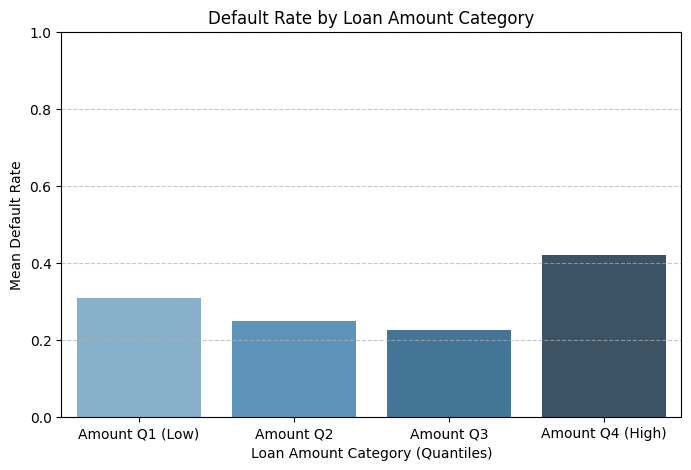


--- Analysis 2: Checking Balance vs. Default Rate ---

Checking Balance bins created:
checking_balance_bin
Balance < 0        274
Balance 0-200      269
Balance 200-500     23
Balance > 500       40
Name: count, dtype: int64

Default Rate by Checking Balance Bin:
  checking_balance_bin      mean  count
0          Balance < 0  0.492701    274
1        Balance 0-200  0.390335    269
2      Balance 200-500  0.260870     23
3        Balance > 500  0.200000     40


<ipython-input-58-4fe9e061251f>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_default_rate = df.groupby('checking_balance_bin')['default'].agg(['mean', 'count']).reset_index()
<ipython-input-58-4fe9e061251f>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='checking_balance_bin', y='mean', data=balance_default_rate, palette='Greens_d') # Use a different palette


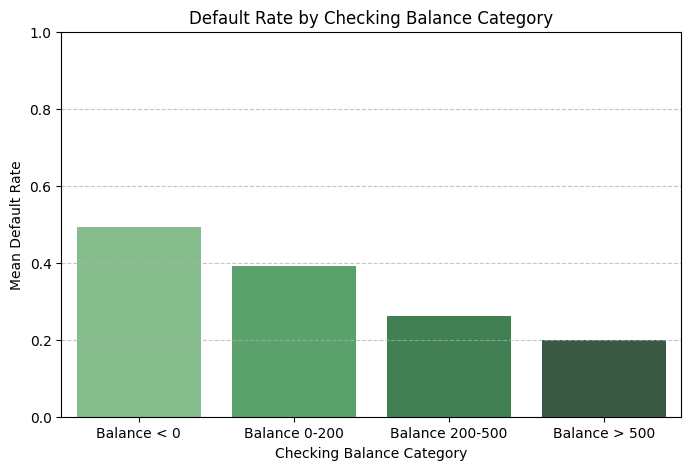


--- Analysis 3: Combined Amount & Checking Balance vs. Default Rate ---

Default Rate by Combined Amount and Checking Balance Bins:
        amount_bin checking_balance_bin      mean  count
0  Amount Q1 (Low)          Balance < 0  0.527778     72
1  Amount Q1 (Low)        Balance 0-200  0.388060     67
2  Amount Q1 (Low)      Balance 200-500  0.500000     10
3  Amount Q1 (Low)        Balance > 500  0.200000     15
4        Amount Q2          Balance < 0  0.428571     63


<ipython-input-58-4fe9e061251f>:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combo_default_rate = df.groupby(['amount_bin', 'checking_balance_bin'])['default'].agg(['mean', 'count']).reset_index()
<ipython-input-58-4fe9e061251f>:81: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = combo_default_rate.pivot_table(index='checking_balance_bin', columns='amount_bin', values='mean') # Swapped axes for better readability
<ipython-input-58-4fe9e061251f>:82: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warni

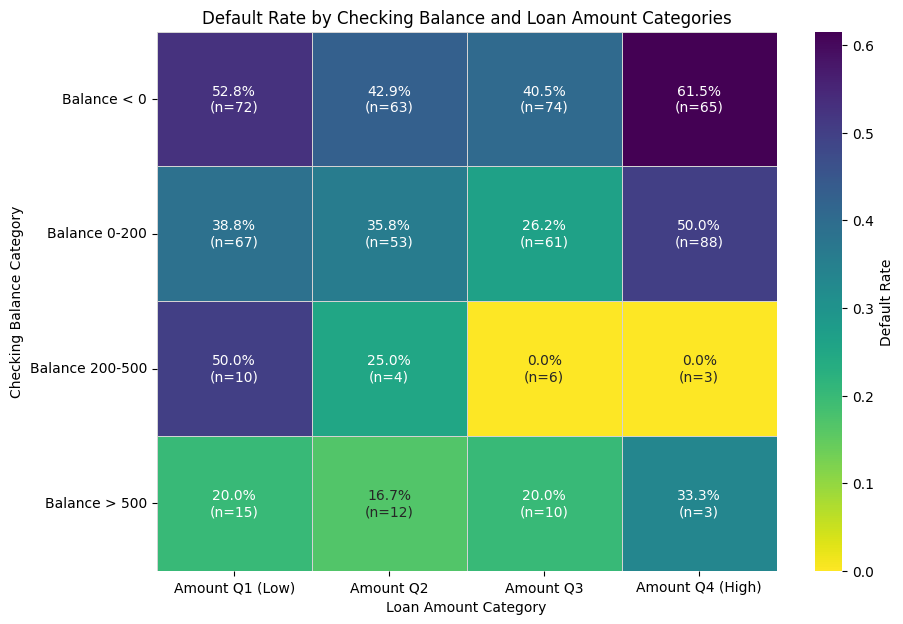

In [58]:
# --- Analysis 1: Amount vs. Default Rate ---
print("\n--- Analysis 1: Loan Amount vs. Default Rate ---")

# Create bins for loan amount (e.g., using quantiles for 4 groups)
try:
    amount_labels = ['Amount Q1 (Low)', 'Amount Q2', 'Amount Q3', 'Amount Q4 (High)']
    df['amount_bin'] = pd.qcut(df['amount'], q=4, labels=amount_labels, duplicates='drop') # drop duplicates if bin edges identical
    print("\nAmount bins created:")
    print(df['amount_bin'].value_counts().sort_index())

    # Calculate default rate per amount bin
    amount_default_rate = df.groupby('amount_bin')['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Amount Bin:")
    print(amount_default_rate)

    # Visualize
    plt.figure(figsize=(8, 5))
    sns.barplot(x='amount_bin', y='mean', data=amount_default_rate, palette='Blues_d') # Use a different palette
    plt.title('Default Rate by Loan Amount Category')
    plt.xlabel('Loan Amount Category (Quantiles)')
    plt.ylabel('Mean Default Rate')
    plt.ylim(0, max(1.0, amount_default_rate['mean'].max() * 1.1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

except ValueError as e:
    print(f"\nError creating amount bins (maybe too few unique values): {e}")
    df['amount_bin'] = None # Mark as failed

# --- Analysis 2: Checking Balance vs. Default Rate ---
print("\n--- Analysis 2: Checking Balance vs. Default Rate ---")

# Create bins for checking balance
# Using quantiles is good, but fixed bins might make more sense for balance levels
# Example using fixed bins (adjust these based on your actual data distribution!)
balance_bins = [-float('inf'), 0, 200, 500, float('inf')]
balance_labels = ['Balance < 0', 'Balance 0-200', 'Balance 200-500', 'Balance > 500']
# Alternatively use quantiles:
# balance_labels = ['Balance Q1 (Low)', 'Balance Q2', 'Balance Q3', 'Balance Q4 (High)']
# try:
#     df['checking_balance_bin'] = pd.qcut(df['checking_balance'], q=4, labels=balance_labels, duplicates='drop')

try:
    df['checking_balance_bin'] = pd.cut(df['checking_balance'], bins=balance_bins, labels=balance_labels, right=False) # right=False means lower bound included
    print("\nChecking Balance bins created:")
    print(df['checking_balance_bin'].value_counts().sort_index())

    # Calculate default rate per checking balance bin
    balance_default_rate = df.groupby('checking_balance_bin')['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Checking Balance Bin:")
    print(balance_default_rate)

    # Visualize
    plt.figure(figsize=(8, 5))
    sns.barplot(x='checking_balance_bin', y='mean', data=balance_default_rate, palette='Greens_d') # Use a different palette
    plt.title('Default Rate by Checking Balance Category')
    plt.xlabel('Checking Balance Category')
    plt.ylabel('Mean Default Rate')
    plt.ylim(0, max(1.0, balance_default_rate['mean'].max() * 1.1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

except Exception as e: # Catch potential errors if cut fails
    print(f"\nError creating checking balance bins: {e}")
    df['checking_balance_bin'] = None # Mark as failed


# --- Analysis 3: Combined Amount & Checking Balance vs. Default Rate ---
print("\n--- Analysis 3: Combined Amount & Checking Balance vs. Default Rate ---")

# Proceed only if both binning steps were successful
if df['amount_bin'] is not None and df['checking_balance_bin'] is not None:

    # Group by both bins and calculate default rate
    combo_default_rate = df.groupby(['amount_bin', 'checking_balance_bin'])['default'].agg(['mean', 'count']).reset_index()
    print("\nDefault Rate by Combined Amount and Checking Balance Bins:")
    print(combo_default_rate.head()) # Print first few rows

    # Pivot data for heatmap visualization
    try:
        heatmap_data = combo_default_rate.pivot_table(index='checking_balance_bin', columns='amount_bin', values='mean') # Swapped axes for better readability
        heatmap_counts = combo_default_rate.pivot_table(index='checking_balance_bin', columns='amount_bin', values='count').fillna(0).astype(int) # Get counts

        # Create combined annotation strings (Rate% \n n=Count)
        annot_labels = heatmap_data.applymap(lambda x: f'{x:.1%}' if pd.notna(x) else '') # Format mean as percentage
        annot_labels = annot_labels + '\n(n=' + heatmap_counts.astype(str) + ')' # Add count info

        # Visualize using heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(heatmap_data,
                    annot=annot_labels, # Show rate and count
                    fmt="", # Use empty format string as labels are pre-formatted
                    cmap="viridis_r", # Choose a sequential colormap (darker = higher risk)
                    linewidths=.5,
                    linecolor='lightgray',
                    cbar_kws={'label': 'Default Rate'}) # Add label to color bar
        plt.title('Default Rate by Checking Balance and Loan Amount Categories')
        plt.xlabel('Loan Amount Category')
        plt.ylabel('Checking Balance Category')
        plt.yticks(rotation=0) # Keep y-axis labels horizontal
        plt.show()

    except Exception as e:
        print(f"\nCould not generate heatmap: {e}")

else:
    print("\nSkipping combined analysis due to errors in creating bins.")

# Developing new features based on Analysis

In [59]:
def engineer_numerical_features(df):
  df_copy = df.copy()

  # Financial Interactions

  # Provides an idea of the average monthly principal repayment
  df_copy["loan_per_month"] = df_copy["amount"] / df_copy["months_loan_duration"]

  # Measures the size of the requested loan relative to the applicant's immediately available cash
  df_copy["loan_to_checking_ratio"] = df_copy["amount"] / (df_copy["checking_balance"] + 1e-6)

  # Measures the loan size relative to the applicant's savings buffer.
  df_copy["loan_to_savings_ratio"] = df_copy["amount"] / (df_copy["savings_balance"] + 1e-6)

  # Measures loan size relative to the applicant's total liquid reserves
  df_copy["loan_to_total_ratio"] = df_copy["amount"] / (df_copy["checking_balance"] + df_copy["savings_balance"] + 1e-6)

  return df_copy





In [70]:
def engineer_categorical_features(df):
  # Foreign Worker-Job Interactions
  df_copy = df.copy()

  df_copy['is_foreign_worker'] = df_copy['foreign_worker'].map({'yes': 1, 'no': 0}).fillna(0).astype(int)
  job_one_hot = pd.get_dummies(df['job'], prefix='job', dtype=int)

  interaction_features = job_one_hot.multiply(df['is_foreign_worker'], axis=0)
  interaction_features.columns = [f'{col}_AND_foreign' for col in interaction_features.columns]

  df_with_interactions = pd.concat([df, interaction_features], axis=1)

  # Job and Housing Combinations
  df_with_interactions['job_housing_interaction'] = df_with_interactions['job'].astype(str) + '_' + df_with_interactions['housing'].astype(str)
  df_with_interactions['job_housing_interaction'] = df_with_interactions['job_housing_interaction'].astype('category')

  # Personal Status and Housing
  df_with_interactions['personal_status_housing_interaction'] = df_with_interactions['personal_status'].astype(str) + '_' + df_with_interactions['housing'].astype(str)
  df_with_interactions['personal_status_housing_interaction'] = df_with_interactions['personal_status_housing_interaction'].astype('category')

  # Credit History and Loan Purpose interaction
  df_with_interactions['credit_history_purpose_interaction'] = df_with_interactions['credit_history'].astype(str) + '_' + df_with_interactions['purpose'].astype(str)
  df_with_interactions['credit_history_purpose_interaction'] = df_with_interactions['credit_history_purpose_interaction'].astype('category')

  return df_with_interactions

# Validating Engineered Features

## Numerical Only

In [62]:
X_train_num_features = engineer_numerical_features(X_train)

In [77]:
def train_evaluate_xgb(X_train: pd.DataFrame, y_train: pd.Series,
                       X_val: pd.DataFrame, y_val: pd.Series,
                       target_names: list = None, # Optional custom names for plotting/reporting
                       ):
    """
    Trains an XGBoost classifier with scale_pos_weight, evaluates it on
    validation data, prints/plots metrics, and returns the model and scores.

    Assumes X_train/X_val contain features ready for XGBoost (e.g., numerical
    or with categorical dtype if enable_categorical=True) and y_train/y_val
    contain numerical binary labels (0 and 1).

    Args:
        X_train: Training features DataFrame.
        y_train: Training labels Series (numerical 0/1).
        X_val: Validation features DataFrame.
        y_val: Validation labels Series (numerical 0/1).
        target_names (list, optional): Names for the classes (e.g., ['No Default', 'Default'])
                                       for plotting/reporting. If None, uses sorted unique
                                       values from y_val as strings. Defaults to None.
        random_state (int): Random state for XGBoost reproducibility. Defaults to 42.

    Returns:
        tuple: (trained_xgb_model, evaluation_metrics_dict)
               - trained_xgb_model: The trained XGBoost classifier object.
               - evaluation_metrics_dict: Dictionary containing 'Accuracy', 'Weighted_F1', 'AUC'.
    """

    print("--- Starting XGBoost Training and Evaluation ---")

    # --- Calculate scale_pos_weight ---
    count_neg = np.sum(y_train == 0)
    count_pos = np.sum(y_train == 1)

    if count_pos == 0:
        print("Warning: No positive samples (class 1) found in y_train. Setting scale_pos_weight to 1.")
        scale_pos_weight = 1
    elif count_neg == 0:
         print("Warning: No negative samples (class 0) found in y_train. Setting scale_pos_weight to 1 (or consider alternative).")
         scale_pos_weight = 1 # Avoid division by zero, although this case is unusual
    else:
        scale_pos_weight = count_neg / count_pos
        print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

    # --- Initialize and Train XGBoost ---
    # Assuming enable_categorical=True is desired based on original code
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        enable_categorical=True,
        scale_pos_weight=scale_pos_weight,

    )

    print("Starting model training...")
    try:
        xgb_model.fit(X_train, y_train)
        print("Model training complete.")
    except Exception as e:
        print(f"Error during model training: {e}")
        return None, None # Return None if training fails

    # --- Evaluation ---
    print("\n--- Model Evaluation on Validation Set ---")
    try:
        y_pred = xgb_model.predict(X_val)
        y_proba = xgb_model.predict_proba(X_val)[:, 1]
    except Exception as e:
        print(f"Error during prediction on validation set: {e}")
        return xgb_model, None # Return model but no metrics if prediction fails

    # Metrics Calculation
    accuracy = accuracy_score(y_val, y_pred)
    f1_weighted = f1_score(y_val, y_pred, average='weighted')
    try:
        # Calculate AUC only if both classes are present in y_val
        if len(np.unique(y_val)) > 1:
             auc_score = roc_auc_score(y_val, y_proba)
        else:
            print("Warning: Only one class present in y_val. AUC is not defined.")
            auc_score = None
    except Exception as e:
         print(f"Error calculating AUC score: {e}")
         auc_score = None


    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")
    if auc_score is not None:
       print(f"AUC Score: {auc_score:.4f}")
    else:
       print("AUC Score: N/A")

    # Determine display labels for plots/reports
    unique_labels_val = sorted(y_val.unique())
    if target_names and len(target_names) == len(unique_labels_val):
        display_labels = target_names
        report_target_names = target_names
    else:
        if target_names:
             print(f"Warning: Provided target_names length {len(target_names)} does not match unique labels in y_val {len(unique_labels_val)}. Using default labels.")
        display_labels = [str(label) for label in unique_labels_val]
        report_target_names = display_labels

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred, labels=unique_labels_val) # Ensure labels order matches display_labels
    print("\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    try:
        fig, ax = plt.subplots(figsize=(8, 6)) # Create figure and axes explicitly
        cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
        cmp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax) # Plot on the axes
        ax.set_title('Confusion Matrix') # Set title on the axes
        plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")

    # Classification Report
    print("\nClassification Report:")
    try:
        # Ensure labels used in report match the actual labels present
        print(classification_report(y_val, y_pred, labels=unique_labels_val, target_names=report_target_names, zero_division=0))
    except Exception as e:
        print(f"Error generating classification report: {e}")

    # --- Return Results ---
    evaluation_metrics = {
        'Accuracy': accuracy,
        'Weighted_F1': f1_weighted,
        'AUC': auc_score
    }

    print("\n--- XGBoost Training and Evaluation Complete ---")

    return xgb_model, evaluation_metrics


In [86]:
X_train_num_features = engineer_numerical_features(X_train)
X_val_num_features = engineer_numerical_features(X_val)

In [87]:
X_train_num_features.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'installment_rate', 'personal_status',
       'other_debtors', 'property', 'age', 'installment_plan', 'housing',
       'existing_credits', 'dependents', 'foreign_worker', 'job', 'gender',
       'checking_balance_missing', 'savings_balance_missing',
       'personal_status_missing', 'has_telephone', 'employment_ordinal',
       'residence_ordinal', 'loan_per_month', 'loan_to_checking_ratio',
       'loan_to_savings_ratio', 'loan_to_total_ratio'],
      dtype='object')

In [88]:
X_val_num_features.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'installment_rate', 'personal_status',
       'other_debtors', 'property', 'age', 'installment_plan', 'housing',
       'existing_credits', 'dependents', 'foreign_worker', 'job', 'gender',
       'checking_balance_missing', 'savings_balance_missing',
       'personal_status_missing', 'has_telephone', 'employment_ordinal',
       'residence_ordinal', 'loan_per_month', 'loan_to_checking_ratio',
       'loan_to_savings_ratio', 'loan_to_total_ratio'],
      dtype='object')

In [89]:
assert set(X_train_num_features.columns) == set(X_val_num_features.columns), "Columns in X_train and X_val do not match"

In [ ]:
# --- Example Usage ---
# Assuming you have already split your data into:
# X_train, X_val, y_train, y_val (where y_* are Series with 0/1)

# Example Call:
# trained_model, metrics = train_evaluate_xgb(X_train_num_features, y_train, X_val_num_features, y_val)

# Example Call with custom target names:
class_names = ['Non-Default', 'Default']
trained_model, metrics = train_evaluate_xgb(X_train_num_features, y_train, X_val_num_features, y_val, target_names=class_names)


if trained_model and metrics:
    print("\nReturned Metrics:", metrics)
    # You can now use trained_model for further predictions or analysis
    feature_importance = trained_model.feature_importances_

An increase in weighted F1 score by 2%

The weighted F1 score is a good choice for imbalanced datasets because it accounts for both precision and recall across all classes while weighting each class’s contribution by its support, preventing majority classes from dominating the evaluation.

# Further Work

Because of time constraints, at this point we can also leverage the categorical-categorical analysis and categorical-numerical analysis to engineer more feature and then use Feature Elimination Methods to reduce the noise and improve the predictive power of the model. For now, we will carry on with what we have.

_"All models are wrong, but some are useful"_ - George Box

# Hyper-parameter Tuning

In [129]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00


In [130]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [131]:
def train_xgboost_model(X_train, y_train, X_val, y_val, target_column='default', random_state=42):
    """
    Trains an XGBoost model on the training set, using scale_pos_weight to handle class imbalance.

    Parameters:
    - preprocessed_df (pd.DataFrame): The input DataFrame with features and target variable.
    - target_column (str): The name of the target variable column.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random state for reproducibility.

    Returns:
    - xgb (XGBClassifier): The trained XGBoost model.
    - X_test (pd.DataFrame): The test set features.
    - y_test (pd.Series): The true labels for the test set.
    """


    # Calculate scale_pos_weight to handle class imbalance
    # Formula: (number of negative samples / number of positive samples)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    X_train_hpo, X_val_hpo, y_train_hpo, y_val_hpo = train_test_split(
    X_train, y_train,
    test_size=0.2, # Or 0.25, adjust as needed
    random_state=42,
    stratify=y_train # Keep stratification
      )

    print(f"Original training shape: {X_train.shape}")
    print(f"HPO training shape: {X_train_hpo.shape}")
    print(f"HPO validation shape: {X_val_hpo.shape}")

    # Define search space for hyperparameters
    search_space = {

    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.4, 1.0, prior='uniform'),


    'reg_lambda': Real(0.5, 15.0, prior='log-uniform'),
    'reg_alpha': Real(0.0, 5.0, prior='uniform'),

    'gamma': Real(0.0, 3.0, prior='uniform'),
    'min_child_weight': Integer(1, 8),
        }

    # Train XGBoost model with scale_pos_weight to focus on the minority class (positive class)
    xgb_estimator = xgb.XGBClassifier(
      objective='binary:logistic',
      early_stopping_rounds=50,
      use_label_encoder=False,
      eval_metric='logloss',
      enable_categorical=True,
      scale_pos_weight=scale_pos_weight, # Passed from outside
      n_estimators=1000,
      random_state=42
        )
    # Define parameters to pass to the xgb_estimator.fit() method FOR EACH TRIAL
    # This is where early stopping is configured
    fit_params = {
      'eval_set': [(X_val_hpo, y_val_hpo)], # Use the HPO validation set
      'verbose': False # Suppress XGBoost's own verbose output during HPO
      }

      # Consider using StratifiedKFold for cv for better class distribution in folds
    cv_strategy = StratifiedKFold(n_splits=5,
                                    shuffle=True,
                                    random_state=42) # Reduced CV folds slightly



    # Perform Bayesian optimization
    bayes_search = BayesSearchCV(estimator=xgb_estimator,
                              search_spaces=search_space,
                              n_iter=50,
                              cv=cv_strategy,
                              n_jobs=-1,
                              scoring='f1_weighted',
                              random_state=42,
                              verbose=2
                                 )

    print("\nStarting Bayesian Optimization with Early Stopping...")

    # Fit the model to the training data
    bayes_search.fit(X_train_hpo, y_train_hpo, callback=None, **fit_params)

    print("\nBayesian Optimization Complete.")

    # Print best parameters and score found by Bayesian optimization
    print(f"Best parameters: {bayes_search.best_params_}")
    print(f"Best cross-validation F1 Weighted score: {bayes_search.best_score_:.4f}")

    # Use the best estimator to make predictions
    best_model_from_hpo = bayes_search.best_estimator_

    print("\nRetraining final model on full training data using best parameters and early stopping...")

    final_model = xgb.XGBClassifier(
        objective='binary:logistic',
        early_stopping_rounds=50,
        use_label_encoder=False,
        eval_metric='logloss',
        enable_categorical=True,
        scale_pos_weight=scale_pos_weight,
        n_estimators=100, # Still set high
        random_state=42,
        **bayes_search.best_params_ # Unpack the best parameters found
    )

    # Fit on the ORIGINAL full training data, evaluating on the FINAL validation set
    final_model.fit(
    X_train, y_train, # Use the complete training set
    eval_set=[(X_val, y_val)], # Use the final validation set
    verbose=False # Or True if you want to see the final training process
      )
    print("Final model retrained.")


    return final_model  # Return trained model and test data

In [ ]:
best_model = train_xgboost_model(X_train_num_features, y_train, X_val_num_features, y_val)

Original training shape: (720, 28)
HPO training shape: (576, 28)
HPO validation shape: (144, 28)

Starting Bayesian Optimization with Early Stopping...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
def evaluate_model(model, X_val, y_val, target_names=None):
    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    print("\n--- Model Evaluation on Validation Set ---")
    try:
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
    except Exception as e:
        print(f"Error during prediction on validation set: {e}")
        return model, None

    # Metrics Calculation
    accuracy = accuracy_score(y_val, y_pred)
    f1_weighted = f1_score(y_val, y_pred, average='weighted')
    try:
        auc_score = roc_auc_score(y_val, y_proba) if len(np.unique(y_val)) > 1 else None
        if auc_score is None:
            print("Warning: Only one class present in y_val. AUC is not defined.")
    except Exception as e:
        print(f"Error calculating AUC score: {e}")
        auc_score = None

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")
    print(f"AUC Score: {auc_score:.4f}" if auc_score is not None else "AUC Score: N/A")

    # Label setup
    unique_labels_val = sorted(y_val.unique())
    if target_names and len(target_names) == len(unique_labels_val):
        display_labels = target_names
    else:
        display_labels = [str(label) for label in unique_labels_val]

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred, labels=unique_labels_val)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    try:
        fig, ax = plt.subplots(figsize=(8, 6))
        cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
        cmp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
        ax.set_title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")

    # Classification Report
    print("\nClassification Report:")
    try:
        print(classification_report(y_val, y_pred, labels=unique_labels_val,
                                    target_names=display_labels, zero_division=0))
    except Exception as e:
        print(f"Error generating classification report: {e}")

    evaluation_metrics = {
        'Accuracy': accuracy,
        'Weighted_F1': f1_weighted,
        'AUC': auc_score
    }

    print("\n--- Evaluation Complete ---")
    return model, evaluation_metrics


In [ ]:
_, metrics = evaluate_model(best_model, X_val_num_features, y_val, target_names=['No Default', 'Default'])

# Develop a Training and Inference Pipeline

## Training Pipeline

In [102]:
## Libraries for First Part of Pipeline
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted # To check if fitted
from collections import defaultdict
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted # To check if fitted
from collections import defaultdict, OrderedDict
from scipy.stats import chi2_contingency

# Libraries for the second part of the Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
import xgboost as xgb
import joblib # For saving/loading the pipeline


def prepare_imputation_strategy(train_df, target_column='default'):
    """
    Analyzes training data to determine imputation strategy.
    Calculates grouped (by target) and global (overall) imputation values
    for columns where missingness is significantly associated with the target.
    Args:
        train_df (pd.DataFrame): The training dataframe.
        target_column (str): The name of the target variable column.
    Returns:
        tuple: Contains:
            - imputation_instructions (dict): {col: 'must-impute'/'not-necessary'}
            - grouped_imputation_values (dict): {col: {target_val: median/mode}}
            - global_imputation_values (dict): {col: global_median/mode}
            - columns_to_impute (list): List of column names needing imputation.
            - missing_indicator_cols (list): List of names for the missing indicator columns to be created.
    """
    df = train_df.copy() # Work on a copy
    null_info = df.isnull().sum().reset_index()
    imputation_instructions = {} # {col: 'must-impute'/'not-necessary'}
    grouped_imputation_values = defaultdict(dict) # {feature: {class_value: median/mode}}
    global_imputation_values = {} # {feature: global_median/mode}
    columns_to_impute = []
    missing_indicator_cols = []

    print("--- Preparing Imputation Strategy (within fit) ---")

    for i in range(len(null_info)):
        column_name = null_info.iloc[i, 0]
        missing_count = null_info.iloc[i, 1]

        if missing_count > 0 and column_name != target_column:
            # print(f"Analyzing column: {column_name} (Missing: {missing_count})") # Reduce verbosity in pipeline
            missing_col_name = f"{column_name}_missing"
            missing_indicator = df[column_name].isna()
            p_value = 1.0
            try:
                contingency_table = pd.crosstab(missing_indicator, df[target_column])
                if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2 or contingency_table.min().min() == 0:
                   # print(f"  Skipping Chi-squared test for {column_name} due to insufficient data variation.")
                   if missing_count / len(df) > 0.05: # Impute if > 5% missing anyway
                       # print(f"  Marking {column_name} for imputation due to missing count > 5%.")
                       p_value = 0.0
                   else:
                       p_value = 1.0
                else:
                    chi2, p_value, _, expected_freq = chi2_contingency(contingency_table)
                    # if (expected_freq < 5).any().any():
                    #      print(f"  Warning: Chi-squared test for {column_name} has expected frequencies < 5.")
            except ValueError as e:
                 # print(f"  Error during Chi-squared test for {column_name}: {e}. Treating as 'must-impute'.")
                 p_value = 0.0

            if p_value < 0.05:
                # print(f"  '{column_name}' missingness IS significantly associated. Marking for imputation.")
                imputation_instructions[column_name] = 'must-impute'
                columns_to_impute.append(column_name)
                missing_indicator_cols.append(missing_col_name)
                is_numeric = pd.api.types.is_numeric_dtype(df[column_name])

                if is_numeric:
                    global_value = df[column_name].median()
                    group_values = df.groupby(target_column)[column_name].median().to_dict()
                else:
                    mode_series = df[column_name].mode()
                    global_value = mode_series.iloc[0] if not mode_series.empty else None
                    group_modes = {}
                    for name, group_df in df.groupby(target_column):
                         mode_series_group = group_df[column_name].mode()
                         group_modes[name] = mode_series_group.iloc[0] if not mode_series_group.empty else global_value
                    group_values = group_modes

                global_imputation_values[column_name] = global_value
                grouped_imputation_values[column_name] = group_values

                # Sanity Checks (Simplified for brevity)
                if global_value is None or any(v is None for v in group_values.values()):
                     print(f"  ERROR: Imputation value is None for {column_name}. Removing from imputation list.")
                     columns_to_impute.remove(column_name)
                     missing_indicator_cols.remove(missing_col_name)
                     del imputation_instructions[column_name]
                     if column_name in global_imputation_values: del global_imputation_values[column_name]
                     if column_name in grouped_imputation_values: del grouped_imputation_values[column_name]

            else:
                # print(f"  '{column_name}' missingness IS NOT significantly associated. Marking as 'not-necessary'.")
                imputation_instructions[column_name] = 'not-necessary'

    # print("--- Imputation Strategy Prepared ---")
    # print(f"Columns to impute: {columns_to_impute}")
    # print(f"Missing indicator columns to create: {missing_indicator_cols}")
    return imputation_instructions, grouped_imputation_values, global_imputation_values, columns_to_impute, missing_indicator_cols


def apply_imputation_strategy(df, imputation_values, columns_to_impute, missing_indicator_cols, target_column=None, mode='grouped'):
    """Applies the prepared imputation strategy to a DataFrame."""
    df_imputed = df.copy()
    # print(f"\n--- Applying Imputation (Mode: {mode}) ---") # Reduce verbosity in pipeline

    # Add missing indicator columns
    # print(f"Adding indicator columns: {missing_indicator_cols}")
    for indicator_col_name in missing_indicator_cols:
        original_col_name = indicator_col_name.replace('_missing', '')
        if original_col_name in df_imputed.columns:
            df_imputed[indicator_col_name] = df_imputed[original_col_name].isna().astype(int)
        # else: print(f"  Warning: Original column '{original_col_name}' not found for indicator '{indicator_col_name}'.")


    # Apply imputation value filling
    # print(f"Imputing columns: {columns_to_impute}")
    for col in columns_to_impute:
        if col not in df_imputed.columns or col not in imputation_values:
             # print(f"  Warning: Column '{col}' or its imputation values not found. Skipping.")
             continue

        nan_count_before = df_imputed[col].isnull().sum()
        if nan_count_before == 0: continue

        if mode == 'grouped':
            if target_column is None or target_column not in df_imputed.columns:
                raise ValueError("Target column must be provided and exist in df for 'grouped' mode.")
            # print(f"  Applying GROUPED imputation for '{col}'...")
            group_vals = imputation_values[col]
            for group, value in group_vals.items():
                 if value is not None:
                     mask = (df_imputed[col].isnull()) & (df_imputed[target_column] == group)
                     df_imputed.loc[mask, col] = value
                 # else: print(f"  Warning: Imputation value is None for column {col}, group {group}. NaNs remain.")

        elif mode == 'global':
            # print(f"  Applying GLOBAL imputation for '{col}'...")
            global_value = imputation_values[col]
            if global_value is not None:
                df_imputed[col].fillna(global_value)
            # else: print(f"  Warning: Global imputation value is None for column {col}. NaNs remain.")
        else:
            raise ValueError("Invalid mode. Choose 'grouped' or 'global'.")

        # nan_count_after = df_imputed[col].isnull().sum()
        # print(f"    '{col}': NaNs imputed: {nan_count_before - nan_count_after} (Remaining NaNs: {nan_count_after})")


    # Optional: Handle 'telephone' - move inside if 'telephone' column exists
    if 'telephone' in df_imputed.columns:
      df_imputed['has_telephone'] = df_imputed['telephone'].notna().astype(int)
      # print("Dropping 'telephone' column.")
      df_imputed.drop(columns=['telephone'], inplace=True, errors='ignore')

    # print("--- Imputation Applied ---")
    return df_imputed

# --- Custom Transformer Class ---
class SmartImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_column='default'):
        self.target_column = target_column

    def fit(self, X, y=None):
        # y is typically the target Series, used here to ensure target column is available
        # Combine X and y temporarily for prepare function if needed
        # Or ensure target_column is already in X when passed to fit
        if self.target_column not in X.columns:
             if y is not None and isinstance(y, pd.Series) and y.name == self.target_column:
                  X_fit = pd.concat([X, y], axis=1)
             elif y is not None and isinstance(y, pd.Series) and y.name != self.target_column:
                 # Try assigning y with the correct name if lengths match
                 if len(X) == len(y):
                     X_fit = X.copy()
                     X_fit[self.target_column] = y
                 else:
                     raise ValueError(f"Target column '{self.target_column}' not found in X, and provided y has different length or wrong name.")
             else:
                  raise ValueError(f"Target column '{self.target_column}' not found in X and y not provided or suitable.")
        else:
            X_fit = X

        (self.imputation_instructions_, self.grouped_imputation_values_,
         self.global_imputation_values_, self.columns_to_impute_,
         self.missing_indicator_cols_) = prepare_imputation_strategy(X_fit, self.target_column)
        return self

    def transform(self, X):
        # Check if fit has been called
        check_is_fitted(self, ['global_imputation_values_', 'columns_to_impute_', 'missing_indicator_cols_'])
        X_transformed = X.copy()
        # Always use GLOBAL values for transform (inference/test/validation)
        X_transformed = apply_imputation_strategy(
            X_transformed,
            imputation_values=self.global_imputation_values_, # Use learned GLOBAL values
            columns_to_impute=self.columns_to_impute_,
            missing_indicator_cols=self.missing_indicator_cols_,
            target_column=None, # Target not needed/available for global mode
            mode='global' # Explicitly use global mode
        )
        return X_transformed


def convert_object_to_category(df, ordinal=False):
    df = df.copy()
    # Keep track of columns converted to category
    converted_cols = []
    for col in df.columns:
        if pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].astype('category')
            converted_cols.append(col)
    # print(f"Converted object columns to category: {converted_cols}") # Optional print

    if ordinal:
      # Ensure columns exist before processing
      columns_to_convert_ordinal = []
      if 'employment_length' in df.columns:
          columns_to_convert_ordinal.append('employment_length')
      if 'residence_history' in df.columns:
           columns_to_convert_ordinal.append('residence_history')

      if not columns_to_convert_ordinal:
           print("Ordinal columns ('employment_length', 'residence_history') not found, skipping ordinal conversion.")
           return df

      def duration_to_months(duration):
          if pd.isna(duration) or not isinstance(duration, str): return np.nan
          if 'month' in duration: return int(duration.split()[0])
          elif 'year' in duration: return int(duration.split()[0]) * 12
          else: return np.nan

      for col in columns_to_convert_ordinal:
          col_name = col.split("_")[0]
          temp_months_col = f'{col_name}_months_temp' # Avoid potential conflicts
          df[temp_months_col] = df[col].astype(str).apply(duration_to_months) # Ensure apply on strings
          unique_months = sorted(df[temp_months_col].dropna().unique())
          # Convert unique months to strings for category levels
          categories = [str(int(m)) if not np.isnan(m) else 'nan' for m in unique_months]
          # Handle potential NaN category explicitly if needed
          if df[temp_months_col].isnull().any() and 'nan' not in categories:
              categories.append('nan') # Add 'nan' if missing values exist and aren't a level

          # Convert the temp months column to string, handling NaNs
          series_to_convert = df[temp_months_col].apply(lambda x: str(int(x)) if pd.notna(x) else 'nan')

          # Create the ordered categorical column
          df[f'{col_name}_ordinal'] = pd.Categorical(
              series_to_convert,
              categories=categories,
              ordered=True
          )
          # print(f"Created ordinal column: {col_name}_ordinal") # Optional print
          # Drop original and temporary columns
          df.drop(columns=[col, temp_months_col], inplace=True, errors='ignore')

    return df

def regroup_installment_plan(df: pd.DataFrame, column_name: str = 'installment_plan') -> pd.DataFrame:
    """
    Regroups the 'installment_plan' column based on observed default rates.

    Combines 'bank' and 'stores' into a single 'Bank/Stores Plan' category,
    leaving 'none' as its own category. Creates a new column 'installment_plan_grouped'.

    Args:
        df (pd.DataFrame): The input DataFrame containing the installment_plan column.
        column_name (str): The name of the column to regroup. Defaults to 'installment_plan'.

    Returns:
        pd.DataFrame: The DataFrame with the new 'installment_plan_grouped' column added.
                      The original column is kept for reference but can be dropped later.
    """
    df_copy = df.copy()

    if column_name not in df_copy.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Define the mapping for regrouping
    # Categories 'bank' and 'stores' have similar high default rates (~40-41%)
    # Category 'none' has a distinct lower default rate (~27.5%)
    mapping = {
        'bank': 'Bank/Stores Plan',
        'stores': 'Bank/Stores Plan',
        'none': 'None'
    }

    # Create the new grouped column
    new_col_name = f"{column_name}_grouped"
    df_copy[new_col_name] = df_copy[column_name].map(mapping)

    # Convert the new column to category dtype for consistency
    df_copy[new_col_name] = df_copy[new_col_name].astype('category')

    return df_copy


def engineer_numerical_features(df):
  df_copy = df.copy()
  # Ensure source columns exist and handle potential division by zero or NaNs
  if "amount" in df_copy and "months_loan_duration" in df_copy:
    df_copy["loan_per_month"] = df_copy["amount"] / df_copy["months_loan_duration"].replace(0, 1e-6) # Avoid zero div
  if "amount" in df_copy and "checking_balance" in df_copy:
    df_copy["loan_to_checking_ratio"] = df_copy["amount"] / (df_copy["checking_balance"].fillna(0) + 1e-6) # Fill NaNs before division
  if "amount" in df_copy and "savings_balance" in df_copy:
    df_copy["loan_to_savings_ratio"] = df_copy["amount"] / (df_copy["savings_balance"].fillna(0) + 1e-6)
  if "amount" in df_copy and "checking_balance" in df_copy and "savings_balance" in df_copy:
    df_copy["loan_to_total_ratio"] = df_copy["amount"] / (df_copy["checking_balance"].fillna(0) + df_copy["savings_balance"].fillna(0) + 1e-6)
  # print("Engineered numerical features.") # Optional print
  return df_copy


def engineer_categorical_features(df):
  df_copy = df.copy() # Work on a copy

  # Foreign Worker-Job Interactions (ensure source columns exist)
  if 'foreign_worker' in df_copy and 'job' in df_copy:
      df_copy['is_foreign_worker'] = df_copy['foreign_worker'].map({'yes': 1, 'no': 0}).fillna(0).astype(int)
      job_one_hot = pd.get_dummies(df_copy['job'], prefix='job', dtype=int)
      interaction_features = job_one_hot.multiply(df_copy['is_foreign_worker'], axis=0)
      interaction_features.columns = [f'{col}_AND_foreign' for col in interaction_features.columns]
      # Only concat columns that aren't already there
      cols_to_add = [col for col in interaction_features.columns if col not in df_copy.columns]
      df_copy = pd.concat([df_copy, interaction_features[cols_to_add]], axis=1)
  # else: print("Skipping foreign worker interaction - required columns missing.")

  # Job and Housing Combinations
  if 'job' in df_copy and 'housing' in df_copy:
      df_copy['job_housing_interaction'] = df_copy['job'].astype(str) + '_' + df_copy['housing'].astype(str)
      df_copy['job_housing_interaction'] = df_copy['job_housing_interaction'].astype('category')
  # else: print("Skipping job-housing interaction - required columns missing.")

  # Personal Status and Housing
  if 'personal_status' in df_copy and 'housing' in df_copy:
      df_copy['personal_status_housing_interaction'] = df_copy['personal_status'].astype(str) + '_' + df_copy['housing'].astype(str)
      df_copy['personal_status_housing_interaction'] = df_copy['personal_status_housing_interaction'].astype('category')
  # else: print("Skipping personal_status-housing interaction - required columns missing.")

  # Credit History and Loan Purpose interaction
  if 'credit_history' in df_copy and 'purpose' in df_copy:
      df_copy['credit_history_purpose_interaction'] = df_copy['credit_history'].astype(str) + '_' + df_copy['purpose'].astype(str)
      df_copy['credit_history_purpose_interaction'] = df_copy['credit_history_purpose_interaction'].astype('category')
  # else: print("Skipping credit_history-purpose interaction - required columns missing.")

  # print("Engineered categorical features.") # Optional print
  return df_copy

# Wrap functions that don't require fitting state
# Set ordinal=True if you want the ordinal conversion logic to run
convert_cats_transformer = FunctionTransformer(convert_object_to_category, kw_args={'ordinal': True}, validate=False)
regroup_installment_plan_transformer = FunctionTransformer(regroup_installment_plan, validate=False)
engineer_num_transformer = FunctionTransformer(engineer_numerical_features, validate=False)

best_params = OrderedDict([
    ('colsample_bytree', 1.0),
    ('learning_rate', 0.16455239155781587),
    ('max_depth', 9),
    ('subsample', 1.0)
])

xgb_model = xgb.XGBClassifier(
    **best_params,
    n_estimators=100,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True, # Set to False because OHE is used
    random_state=42
    )

# --- Build the Full Pipeline ---
training_pipeline = Pipeline(steps=[
    ('imputer', SmartImputer(target_column='default')),
    ('convert_types', convert_cats_transformer), # Convert objects, create ordinals
    ('regroup_installment_plan', regroup_installment_plan_transformer), # Regroup installment plan
    ('engineer_numerical', engineer_num_transformer), # Create numerical features
    # ('engineer_categorical', engineer_cat_transformer), # Create categorical features
    ('classifier', xgb_model) # Add the classifier
    # Use xgb_model_cat if using enable_categorical=True and adjusted preprocessor_standard
])

print("\nFull Training Pipeline Created:")
print(training_pipeline)

# Assuming X_train, y_train are your raw training data (pandas DataFrames/Series)
# Ensure y_train is just the target Series, and X_train contains features + target column if needed by fit



Full Training Pipeline Created:
Pipeline(steps=[('imputer', SmartImputer()),
                ('convert_types',
                 FunctionTransformer(func=<function convert_object_to_category at 0x787b2eb068e0>,
                                     kw_args={'ordinal': True})),
                ('regroup_installment_plan',
                 FunctionTransformer(func=<function regroup_installment_plan at 0x787b2eb056c0>)),
                ('engineer_numerical',
                 FunctionTransformer(func=<function engineer_numerical_feat...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.16455239155781587, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=

## Pipeline Creation

In [103]:
# Example: Separate target for fitting if not already done
target = 'default'
if target in X_train_full.columns:
    y_train = X_train_full[target]
    X_train_full_features = X_train_full.drop(columns=[target])
else:
    X_train_full_features = X_train_full # Assume target is already separate

# --- Train the Pipeline ---
print("\n--- Starting Pipeline Training ---")
training_pipeline.fit(X_train_full_features, y_train_full) # Pass target `y` if needed by fit methods
print("--- Pipeline Training Complete ---")

# --- Save the Fitted Pipeline ---
pipeline_filename = 'full_credit_pipeline_new.joblib'
pipeline_path = f"{model_folder}/{pipeline_filename}"
joblib.dump(training_pipeline, pipeline_path)
print(f"Fitted pipeline saved to {pipeline_filename}")


--- Starting Pipeline Training ---
--- Preparing Imputation Strategy (within fit) ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:27:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Pipeline Training Complete ---
Fitted pipeline saved to full_credit_pipeline_new.joblib


# Inference on one customer

In [ ]:
# Pick one random sample from X_test to test the Pipeline
random_index = np.random.randint(0, len(X_test))
random_sample = X_test.iloc[[random_index]]

random_sample.to_dict()

In [ ]:
# --- Online Inference - Using only one sample (for scoring new customers as they come in) ---

# 1. Load the fitted pipeline
loaded_pipeline = joblib.load(pipeline_path)
print("\n--- Loaded Fitted Pipeline for Inference ---")

# 2. Load or create new raw data (must have same original columns as training data)

new_data_raw = random_sample # New Customer data

# 3. Make Predictions
print("\n--- Making Predictions on New Data ---")

predictions = loaded_pipeline.predict(new_data_raw) # Scoring new customer data
probabilities = loaded_pipeline.predict_proba(new_data_raw)[:, 1] # Prob of positive class

print("\nPredictions:", predictions)
print("Probabilities (Default):", probabilities)

# Add predictions back to the raw data for inspection
new_data_raw.loc[:, 'Prediction'] = predictions
new_data_raw.loc[:, 'Probability_Default'] = probabilities
print("\nNew Data with Predictions:")

# For all customers

In [107]:
# --- Batch Inference - Using only all the test samples ---

# 1. Load the fitted pipeline
loaded_pipeline = joblib.load(pipeline_path)
print("\n--- Loaded Fitted Pipeline for Inference ---")

# 2. Load or create new raw data (must have same original columns as training data)

new_data_raw = X_test # A Random Sample from the Test data

# 3. Make Predictions
print("\n--- Making Predictions on New Data ---")

predictions = loaded_pipeline.predict(new_data_raw)
probabilities = loaded_pipeline.predict_proba(new_data_raw)[:, 1] # Prob of positive class

# print("\nPredictions:", predictions)
# print("Probabilities (Default):", probabilities)

# # Add predictions back to the raw data for inspection
new_data_raw.loc[:, 'Prediction'] = predictions
new_data_raw.loc[:, 'Probability_Default'] = probabilities
# print("\nNew Data with Predictions:")
# new_data_raw


--- Loaded Fitted Pipeline for Inference ---

--- Making Predictions on New Data ---


In [108]:
new_data_raw['Prediction'] = predictions
new_data_raw['Probability_Default'] = probabilities

# Evaluate Model from Inference Pipeline

In [106]:
import numpy as np
import pandas as pd # For type hints, assuming inputs might be Series
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score, # Computes AUC-PR
    PrecisionRecallDisplay, # For plotting PR curve
    RocCurveDisplay # For plotting ROC curve
)

def evaluate_classification_metrics(y_true, y_pred, y_proba=None, target_names=None, plot_curves=True):
    """
    Calculates and displays common classification evaluation metrics and plots.

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Predicted target values (class labels).
        y_proba (array-like, optional): Predicted probabilities for the positive class.
                                         Required for AUC-ROC and AUC-PR. Defaults to None.
        target_names (list, optional): Display names for the target classes (e.g., ['No Default', 'Default']).
                                       If None, defaults to ['Class 0', 'Class 1', ...]. Defaults to None.
        plot_curves (bool): Whether to plot ROC and Precision-Recall curves. Defaults to True.


    Returns:
        dict: A dictionary containing the calculated scalar metrics:
              'Weighted_F1', 'AUC_ROC', 'AUC_PR'. AUC metrics will be None
              if y_proba is not provided or calculation fails.
    """
    print("--- Classification Evaluation ---")

    # Ensure inputs are numpy arrays for consistency
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_proba is not None:
        y_proba = np.asarray(y_proba)

    # Input validation
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape} and y_pred {y_pred.shape}")
    if y_proba is not None and y_true.shape[0] != y_proba.shape[0]:
         raise ValueError(f"Shape mismatch: y_true {y_true.shape[0]} and y_proba {y_proba.shape[0]}")

    # Determine labels and target names
    unique_labels = sorted(np.unique(y_true))
    if target_names:
        if len(target_names) != len(unique_labels):
            print(f"Warning: Provided target_names length ({len(target_names)}) doesn't match "
                  f"unique labels in y_true ({len(unique_labels)}). Using default names.")
            display_labels = [f"Class {i}" for i in unique_labels]
        else:
            display_labels = target_names
    else:
        display_labels = [f"Class {i}" for i in unique_labels]

    # --- Calculate Metrics ---
    metrics = {}

    # 1. Weighted F1 Score
    try:
        f1_w = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        metrics['Weighted_F1'] = f1_w
        print(f"Weighted F1 Score: {f1_w:.4f}")
    except Exception as e:
        print(f"Error calculating Weighted F1 Score: {e}")
        metrics['Weighted_F1'] = None

    # 2. Classification Report
    print("\nClassification Report:")
    try:
        print(classification_report(y_true, y_pred, labels=unique_labels, target_names=display_labels, zero_division=0))
    except Exception as e:
        print(f"Error generating classification report: {e}")

    # 3. Confusion Matrix
    print("\nConfusion Matrix:")
    try:
        cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
        metrics['Confusion_Matrix'] = cm
        print(cm)
        # Plotting
        fig_cm, ax_cm = plt.subplots(figsize=(7, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
        disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax_cm)
        ax_cm.set_title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Error calculating/plotting Confusion Matrix: {e}")

    # 4. AUC-ROC & AUC-PR (Require Probabilities and multiple classes)
    auc_roc = None
    auc_pr = None
    can_calc_auc = (y_proba is not None) and (len(unique_labels) > 1)

    if y_proba is None:
        print("\nSkipping AUC-ROC and AUC-PR calculations (requires y_proba).")
    elif len(unique_labels) <= 1:
        print(f"\nSkipping AUC-ROC and AUC-PR calculations (only found {len(unique_labels)} class in y_true).")
    else:
        # AUC-ROC
        try:
            auc_roc = roc_auc_score(y_true, y_proba)
            metrics['AUC_ROC'] = auc_roc
            print(f"\nAUC-ROC Score: {auc_roc:.4f}")
        except Exception as e:
            print(f"Error calculating AUC-ROC: {e}")
            metrics['AUC_ROC'] = None

        # AUC-PR (Average Precision)
        try:
            auc_pr = average_precision_score(y_true, y_proba)
            metrics['AUC_PR'] = auc_pr
            print(f"AUC-PR Score (Average Precision): {auc_pr:.4f}")
        except Exception as e:
            print(f"Error calculating AUC-PR (Average Precision): {e}")
            metrics['AUC_PR'] = None

        # Plot Curves if requested and possible
        if plot_curves:
            try:
                fig_curves, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(15, 6))

                # Plot ROC Curve
                RocCurveDisplay.from_predictions(y_true, y_proba, ax=ax_roc, name='Model')
                ax_roc.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
                ax_roc.set_title('ROC Curve')
                ax_roc.legend()

                # Plot Precision-Recall Curve
                PrecisionRecallDisplay.from_predictions(y_true, y_proba, ax=ax_pr, name='Model')
                # Calculate chance level for PR curve (proportion of positive class)
                chance_level_pr = np.sum(y_true == 1) / len(y_true)
                ax_pr.axhline(chance_level_pr, color='k', linestyle='--', label=f'Chance level ({chance_level_pr:.2f})')
                ax_pr.set_title('Precision-Recall Curve')
                ax_pr.legend()

                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting ROC/PR curves: {e}")


    print("\n--- Evaluation Complete ---")
    # Ensure AUC keys exist even if calculation failed
    if 'AUC_ROC' not in metrics: metrics['AUC_ROC'] = None
    if 'AUC_PR' not in metrics: metrics['AUC_PR'] = None

    return metrics

--- Classification Evaluation ---
Weighted F1 Score: 0.7395

Classification Report:
              precision    recall  f1-score   support

  No Default       0.78      0.91      0.84        70
     Default       0.67      0.40      0.50        30

    accuracy                           0.76       100
   macro avg       0.72      0.66      0.67       100
weighted avg       0.75      0.76      0.74       100


Confusion Matrix:
[[64  6]
 [18 12]]


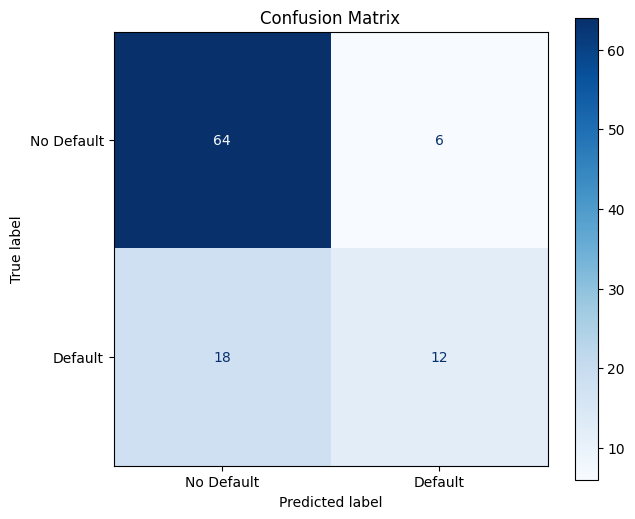


AUC-ROC Score: 0.7424
AUC-PR Score (Average Precision): 0.5681


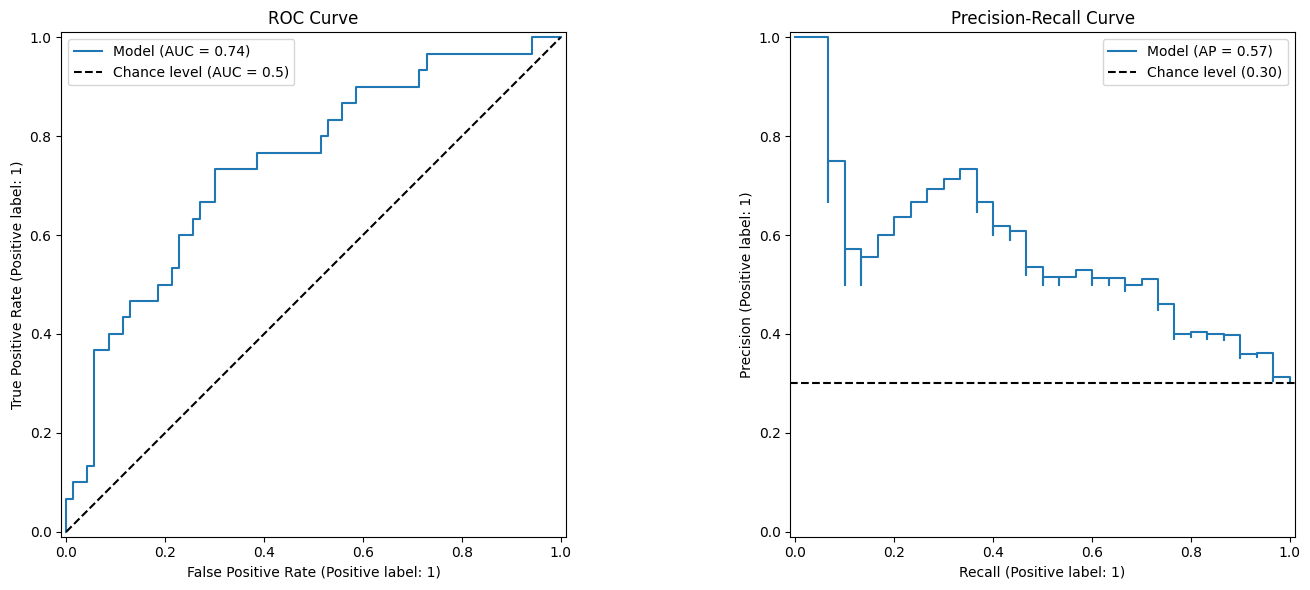


--- Evaluation Complete ---

Returned Metrics Dictionary:
{'Weighted_F1': 0.7394736842105263, 'Confusion_Matrix': array([[64,  6],
       [18, 12]]), 'AUC_ROC': np.float64(0.7423809523809524), 'AUC_PR': np.float64(0.5680992875975089)}


In [109]:
# Example Call:
evaluation_results = evaluate_classification_metrics(
    y_test,
    predictions,
    probabilities,
    target_names=['No Default', 'Default'] # Optional: for better labels
)

# Access the calculated scores:
if evaluation_results:
    print("\nReturned Metrics Dictionary:")
    print(evaluation_results)
    # weighted_f1 = evaluation_results['Weighted_F1']
    # auc = evaluation_results['AUC_ROC']
    # auc_pr_score = evaluation_results['AUC_PR']

# Qualitative Analysis of the Model

## Model Usability - Assessing Business Value of the Model

In [114]:
def calculate_financial_metrics(conf_matrix, cleaned_credit_score_data, interest_rate=0.1):
    """
    Calculates financial metrics based on the confusion matrix and credit score data.

    Parameters:
    - conf_matrix (np.ndarray): The confusion matrix from model predictions.
    - cleaned_credit_score_data (pd.DataFrame): DataFrame containing the credit score data with 'amount' and 'default' columns.
    - interest_rate (float): The interest rate to calculate opportunity cost from false negatives.

    Returns:
    - dict: A dictionary containing financial metrics and the overall net benefit.
    """
    # Extract values from confusion matrix
    true_negative = conf_matrix[0][0]
    false_positive = conf_matrix[0][1]
    false_negative = conf_matrix[1][0]
    true_positive = conf_matrix[1][1]

    # Calculate average loan amount for high-risk individuals (defaults)
    X = cleaned_credit_score_data[cleaned_credit_score_data['default'] == 1]['amount'].mean()  # Average for defaults
    print(f"Average loan amount for high-risk individuals (X): ${X:.2f}")

    # Calculate average loan amount for low-risk individuals (no defaults)
    Y = cleaned_credit_score_data[cleaned_credit_score_data['default'] == 0]['amount'].mean()  # Average for non-defaults
    print(f"Average loan amount for low-risk individuals (Y): ${Y:.2f}")

    # Calculate default rate for high-risk individuals (D)
    D = cleaned_credit_score_data['default'].mean()  # Default rate across all loans
    print(f"Default rate for high-risk individuals (D): {D:.2f}")

    # Calculate financial loss from false positives
    financial_loss_fp = false_positive * X * D  # Total expected loss from false positives
    print(f"Financial Loss from False Positives: ${financial_loss_fp:.2f}")

    # Calculate opportunity cost from false negatives
    opportunity_cost_fn = false_negative * Y * interest_rate  # Total opportunity cost from false negatives
    print(f"Opportunity Cost from False Negatives: ${opportunity_cost_fn:.2f}")

    # Calculate savings from true positives
    savings_tp = true_positive * X * D  # Total savings from avoiding defaults on true positives
    print(f"Savings from True Positives: ${savings_tp:.2f}")

    # Calculate the overall net benefit
    net_benefit = savings_tp - (financial_loss_fp + opportunity_cost_fn)
    print(f"Overall Net Benefit: ${net_benefit:.2f}")

    return {
        "average_loan_high_risk": X,
        "average_loan_low_risk": Y,
        "default_rate": D,
        "financial_loss_fp": financial_loss_fp,
        "opportunity_cost_fn": opportunity_cost_fn,
        "savings_tp": savings_tp,
        "net_benefit": net_benefit
    }


In [115]:
conf_matrix = evaluation_results['Confusion_Matrix']
calculate_financial_metrics(conf_matrix, test_df, interest_rate=0.10)

Average loan amount for high-risk individuals (X): $4315.27
Average loan amount for low-risk individuals (Y): $3212.93
Default rate for high-risk individuals (D): 0.30
Financial Loss from False Positives: $7767.48
Opportunity Cost from False Negatives: $5783.27
Savings from True Positives: $15534.96
Overall Net Benefit: $1984.21


{'average_loan_high_risk': np.float64(4315.266666666666),
 'average_loan_low_risk': np.float64(3212.9285714285716),
 'default_rate': np.float64(0.3),
 'financial_loss_fp': np.float64(7767.48),
 'opportunity_cost_fn': np.float64(5783.271428571429),
 'savings_tp': np.float64(15534.96),
 'net_benefit': np.float64(1984.2085714285713)}

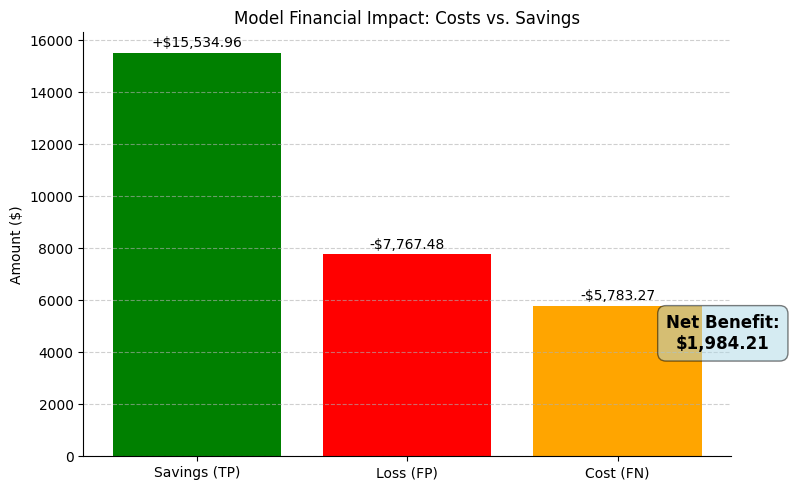

In [116]:

# Data
metrics = {
    'Savings (TP)': 15534.96,
    'Loss (FP)': -7767.48, # Negative for cost
    'Cost (FN)': -5783.27   # Negative for cost
}
net_benefit = 1984.21
labels = list(metrics.keys())
values = list(metrics.values())
colors = ['green', 'red', 'orange'] # Assign colors

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(labels, np.abs(values), color=colors) # Plot absolute values for height
ax.set_ylabel('Amount ($)')
ax.set_title('Model Financial Impact: Costs vs. Savings')

# Add exact values on bars
# Iterate through the bars and corresponding labels:
for bar, label in zip(bars, labels):
    yval = bar.get_height()
    sign = '+' if metrics[label] > 0 else '-' # Use the label directly
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f"{sign}${yval:,.2f}", ha='center', va='bottom')

# Add Net Benefit annotation
plt.text(len(labels) - 0.5 , net_benefit + 2000, f"Net Benefit:\n${net_benefit:,.2f}",
         ha='center', va='bottom', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=0) # Keep labels horizontal if space allows
plt.tight_layout()
plt.show()

In [118]:
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3388 sha256=0e25359841e2f2b3ab72f43a56d1a5e066770da44e553360fcfa0a5d039b11c6
  Stored in directory: /root/.cache/pip/wheels/49/9a/ff/ec03fce8e52feb9578e6d919014384cd15a7f1a2d90f56fce9
Successfully built waterfallcharts


/usr/local/lib/python3.11/dist-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/usr/local/lib/python3.11/dist-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


<Figure size 800x600 with 0 Axes>

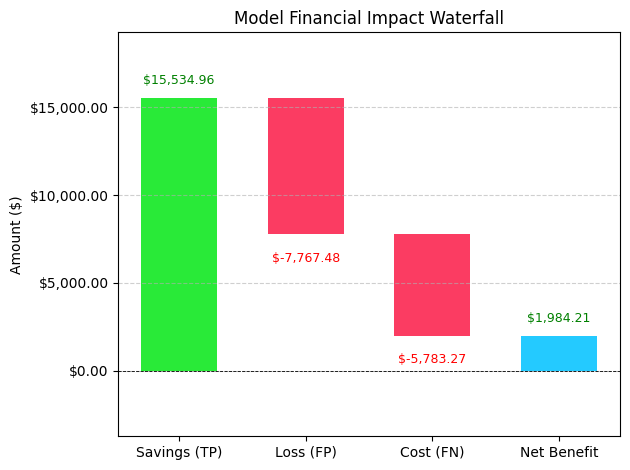

In [119]:
import waterfall_chart


# Data - Order matters for waterfall
steps = ['Savings (TP)', 'Loss (FP)', 'Cost (FN)']
amounts = [15534.96, -7767.48, -5783.27] # Costs are negative contributions

# Plot
plt.figure(figsize=(8, 6))
waterfall_chart.plot(steps, amounts, formatting='${:,.2f}', net_label="Net Benefit")
plt.title('Model Financial Impact Waterfall')
plt.ylabel("Amount ($)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=0) # Keep labels horizontal if space allows
plt.tight_layout()
plt.show()

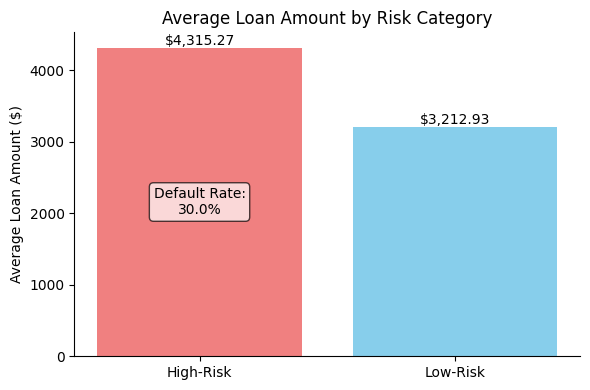

In [120]:


# Data
avg_loans = {'High-Risk': 4315.27, 'Low-Risk': 3212.93}
default_rate_high_risk = 0.30

labels = list(avg_loans.keys())
values = list(avg_loans.values())

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=['lightcoral', 'skyblue'])
ax.set_ylabel('Average Loan Amount ($)')
ax.set_title('Average Loan Amount by Risk Category')

# Add values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"${yval:,.2f}", ha='center', va='bottom')

# Add default rate annotation
plt.text(0, avg_loans['High-Risk'] * 0.5, f"Default Rate:\n{default_rate_high_risk:.1%}",
         ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import warnings

# Try importing shap, provide message if not installed
try:
    import shap
    SHAP_INSTALLED = True
except ImportError:
    print("SHAP library not installed. To get feature explanations, please install it: pip install shap")
    SHAP_INSTALLED = False

def perform_qualitative_model_analysis(
    model,
    X_val_processed: pd.DataFrame, # Data the model predicts on
    y_val: pd.Series,             # True labels
    X_val_raw: pd.DataFrame = None, # Optional: Original features for display
    threshold: float = 0.5,       # Decision threshold
    num_samples_to_show: int = 5, # Number of examples per category
    class_names: list = None,     # e.g., ['No Default', 'Default']
    subgroup_col: str = None,     # Column name in X_val_raw for subgroup analysis
    feature_names: list = None    # Feature names used by the model (if not columns of X_val_processed)
):
    """
    Performs and facilitates qualitative analysis of a binary classification model.

    Args:
        model: The trained classifier model object (must have predict/predict_proba).
        X_val_processed: DataFrame of processed features used for prediction.
        y_val: Series of true labels for the validation set.
        X_val_raw: Optional DataFrame of original, unprocessed features corresponding
                   to X_val_processed for easier interpretation. Index must match X_val_processed.
        threshold: The probability threshold used for classification (default 0.5).
        num_samples_to_show: Number of sample instances to display for error analysis etc.
        class_names: Optional list of class names for display (e.g., ['Negative', 'Positive']).
        subgroup_col: Optional name of a column in X_val_raw to perform subgroup analysis on.
        feature_names: Optional list of feature names if X_val_processed.columns is not sufficient.
    """

    print("--- Starting Qualitative Model Analysis ---")
    print(f"Using threshold: {threshold}")

    if X_val_raw is not None and not X_val_processed.index.equals(X_val_raw.index):
         warnings.warn("Indices of X_val_processed and X_val_raw do not match. Raw data display might be incorrect.")
         X_val_raw = None # Avoid showing potentially mismatched data
         print("Ignoring X_val_raw due to index mismatch.")

    if feature_names is None:
        try:
            feature_names = X_val_processed.columns.tolist()
        except AttributeError:
             warnings.warn("Could not infer feature names from X_val_processed. SHAP plots might lack labels.")
             feature_names = [f'feature_{i}' for i in range(X_val_processed.shape[1])]


    # --- 1. Get Predictions ---
    try:
        y_proba_all = model.predict_proba(X_val_processed)
        # Assuming positive class is the second column (index 1)
        y_proba = y_proba_all[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
    except Exception as e:
        print(f"\nERROR: Could not get predictions from model: {e}")
        return

    # Determine class names if not provided
    unique_labels = sorted(np.unique(y_val))
    if class_names is None or len(class_names) != len(unique_labels):
        class_names_used = [f"Class {i}" for i in unique_labels]
        print(f"Using default class names: {class_names_used}")
    else:
        class_names_used = class_names

    # --- 2. Create Results DataFrame for Inspection ---
    results_df = pd.DataFrame({
        'True Label': y_val,
        'Predicted Label': y_pred,
        'Predicted Probability': y_proba
    }, index=X_val_processed.index)

    # Add raw features if available
    display_df = X_val_raw if X_val_raw is not None else X_val_processed
    results_df = pd.concat([results_df, display_df], axis=1)


    # --- 3. Error Analysis (False Positives / False Negatives) ---
    print("\n--- Error Analysis ---")
    false_positives = results_df[(results_df['True Label'] == 0) & (results_df['Predicted Label'] == 1)]
    false_negatives = results_df[(results_df['True Label'] == 1) & (results_df['Predicted Label'] == 0)]

    print(f"\nTotal False Positives (Predicted {class_names_used[1]}, True {class_names_used[0]}): {len(false_positives)}")
    if not false_positives.empty:
        print(f"Showing up to {num_samples_to_show} False Positive examples:")
        print(false_positives.head(num_samples_to_show))
    else:
        print("No False Positives found.")

    print(f"\nTotal False Negatives (Predicted {class_names_used[0]}, True {class_names_used[1]}): {len(false_negatives)}")
    if not false_negatives.empty:
        print(f"Showing up to {num_samples_to_show} False Negative examples:")
        print(false_negatives.head(num_samples_to_show))
    else:
        print("No False Negatives found.")

    print("\nQualitative Questions for Error Analysis:")
    print("- Are there patterns in the features of FP/FN?")
    print("- Are errors concentrated in specific subgroups (if X_val_raw provided)?")
    print("- How far off were the probabilities for the misclassified samples?")

    # --- 4. Prediction Inspection (Correct / Uncertain Cases) ---
    print("\n--- Prediction Inspection ---")
    true_positives = results_df[(results_df['True Label'] == 1) & (results_df['Predicted Label'] == 1)]
    true_negatives = results_df[(results_df['True Label'] == 0) & (results_df['Predicted Label'] == 0)]

    # Define uncertainty band around the threshold
    uncertainty_margin = 0.1
    lower_bound = max(0, threshold - uncertainty_margin)
    upper_bound = min(1, threshold + uncertainty_margin)
    uncertain_cases = results_df[
        (results_df['Predicted Probability'] >= lower_bound) &
        (results_df['Predicted Probability'] <= upper_bound)
    ]

    print(f"\nTotal True Positives: {len(true_positives)}")
    if not true_positives.empty:
        print(f"Showing up to {num_samples_to_show} high-confidence True Positive examples (Sorted by Probability Desc):")
        print(true_positives.sort_values('Predicted Probability', ascending=False).head(num_samples_to_show))

    print(f"\nTotal True Negatives: {len(true_negatives)}")
    if not true_negatives.empty:
        print(f"Showing up to {num_samples_to_show} high-confidence True Negative examples (Sorted by Probability Asc):")
        print(true_negatives.sort_values('Predicted Probability', ascending=True).head(num_samples_to_show))

    print(f"\nTotal Uncertain Cases (Probability between {lower_bound:.2f} and {upper_bound:.2f}): {len(uncertain_cases)}")
    if not uncertain_cases.empty:
        print(f"Showing up to {num_samples_to_show} Uncertain examples:")
        print(uncertain_cases.head(num_samples_to_show))

    print("\nQualitative Questions for Prediction Inspection:")
    print("- Do the features of high-confidence correct predictions make sense?")
    print("- What are the characteristics of cases where the model is uncertain?")


    # --- 5. Feature Attributions (SHAP) ---
    print("\n--- Feature Attributions (SHAP Analysis) ---")
    if not SHAP_INSTALLED:
        print("SHAP library not found. Skipping feature attribution analysis.")
    else:
        try:
            print("Calculating SHAP values (this may take a moment)...")
            # Use TreeExplainer for tree-based models like XGBoost, LightGBM, CatBoost, RF
            # Use KernelExplainer for others (slower, requires background dataset)
            # Adapt this based on your model type
            if hasattr(model, '_Booster'): # Heuristic for XGBoost/LightGBM
                 explainer = shap.TreeExplainer(model)
            else:
                 # Fallback - KernelExplainer might be very slow for large datasets
                 # Consider masking a subset of X_val_processed for background data
                 print("Attempting to use shap.Explainer (might be slow or require specific model types)...")
                 explainer = shap.Explainer(model.predict_proba, X_val_processed) # May need adjustments

            shap_values = explainer.shap_values(X_val_processed) # Get values for both classes

            # For binary classification, shap_values can be a list [shap_neg, shap_pos]
            # We usually focus on the positive class shap values
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values_positive = shap_values[1]
            else: # Sometimes explainer might return values for only one class or in a different format
                shap_values_positive = shap_values

            print("SHAP values calculated.")

            # Create SHAP DataFrame for easier indexing if needed
            shap_df = pd.DataFrame(shap_values_positive, columns=feature_names, index=X_val_processed.index)

            # Plot Global Feature Importance (Bar Plot)
            print("\nSHAP Global Feature Importance (Mean Absolute SHAP Value):")
            fig_bar, ax_bar = plt.subplots()
            shap.summary_plot(shap_values_positive, X_val_processed, plot_type="bar", feature_names=feature_names, show=False)
            plt.title("SHAP Feature Importance (Bar)")
            plt.show()

            # Plot SHAP Summary Plot (Beeswarm)
            print("\nSHAP Summary Plot (Beeswarm - shows value distribution and impact):")
            fig_bee, ax_bee = plt.subplots()
            shap.summary_plot(shap_values_positive, X_val_processed, feature_names=feature_names, show=False)
            plt.title("SHAP Summary Plot")
            plt.show()

            # Explain specific instances (e.g., top errors) - More interactive part
            print("\nExample SHAP Explanation for Specific Instances:")
            print("(Consider using shap.force_plot or shap.waterfall_plot interactively in notebook)")

            # Example: Explain the first False Positive and first False Negative
            indices_to_explain = []
            if not false_positives.empty: indices_to_explain.append(false_positives.index[0])
            if not false_negatives.empty: indices_to_explain.append(false_negatives.index[0])

            if indices_to_explain:
                 print(f"Generating waterfall plots for example instances (Indices: {indices_to_explain})...")
                 for idx in indices_to_explain:
                     if idx in X_val_processed.index:
                         plt.figure()
                         # Adjust expected_value source based on explainer type
                         try:
                             expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
                         except AttributeError:
                             expected_value=0 # Fallback if not available

                         shap.waterfall_plot(shap.Explanation(values=shap_df.loc[idx].values,
                                                             base_values=expected_value,
                                                             data=X_val_processed.loc[idx].values,
                                                             feature_names=feature_names),
                                             max_display=15, show=False)
                         plt.title(f"SHAP Waterfall Plot for Instance Index: {idx} (True: {results_df.loc[idx, 'True Label']}, Pred: {results_df.loc[idx, 'Predicted Label']})")
                         plt.tight_layout()
                         plt.show()
                     else:
                          print(f"Index {idx} not found in X_val_processed for SHAP explanation.")

            # Example: Explain the first False Positive and first False Negative
            print("\nExample SHAP Explanation for Specific Instances:")
            print("Indicies to Explain for my Presentation")
            indices_to_explain = [235, 953, 347]


            if indices_to_explain:
                 print(f"Generating waterfall plots for example instances (Indices: {indices_to_explain})...")
                 for idx in indices_to_explain:
                     if idx in X_val_processed.index:
                         plt.figure()
                         # Adjust expected_value source based on explainer type
                         try:
                             expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
                         except AttributeError:
                             expected_value=0 # Fallback if not available

                         shap.waterfall_plot(shap.Explanation(values=shap_df.loc[idx].values,
                                                             base_values=expected_value,
                                                             data=X_val_processed.loc[idx].values,
                                                             feature_names=feature_names),
                                             max_display=15, show=False)
                         plt.title(f"SHAP Waterfall Plot for Instance Index: {idx} (True: {results_df.loc[idx, 'True Label']}, Pred: {results_df.loc[idx, 'Predicted Label']})")
                         plt.tight_layout()
                         plt.show()
                     else:
                          print(f"Index {idx} not found in X_val_processed for SHAP explanation.")

            print("\nQualitative Questions for SHAP Analysis:")
            print("- Which features have the most impact overall?")
            print("- Does the direction of impact make sense (e.g., higher income decreases default risk)?")
            print("- For specific errors, which features pushed the prediction the wrong way?")
            print("- Is the model relying on features you expect based on domain knowledge?")

        except Exception as e:
            print(f"\nERROR during SHAP analysis: {e}")
            print("Ensure your model type is compatible with the chosen SHAP explainer.")


    # --- 6. Subgroup Performance Assessment ---
    print("\n--- Subgroup Performance Analysis ---")
    if subgroup_col is None:
        print("No subgroup_col provided. Skipping subgroup analysis.")
    elif X_val_raw is None:
         print(f"Skipping subgroup analysis: X_val_raw DataFrame (needed for column '{subgroup_col}') was not provided or had index mismatch.")
    elif subgroup_col not in X_val_raw.columns:
        print(f"Skipping subgroup analysis: Column '{subgroup_col}' not found in X_val_raw.")
    else:
        print(f"Analyzing performance by subgroup based on column: '{subgroup_col}'")
        # Add subgroup info to results
        results_with_subgroup = pd.concat([results_df[['True Label', 'Predicted Label']], X_val_raw[[subgroup_col]]], axis=1)

        # Calculate metrics per subgroup
        subgroup_metrics = results_with_subgroup.groupby(subgroup_col).agg(
            Count=('True Label', 'count'),
            Accuracy=('True Label', lambda x: accuracy_score(x, results_with_subgroup.loc[x.index, 'Predicted Label'])),
            True_Label_Mean=('True Label', 'mean'), # Proportion of actual positives
            Predicted_Label_Mean=('Predicted Label', 'mean') # Proportion of predicted positives
            # Add more metrics like precision/recall if needed, requires careful lambda functions
        ).reset_index()

        print("\nSubgroup Performance Metrics:")
        print(subgroup_metrics)

        print("\nQualitative Questions for Subgroup Analysis:")
        print(f"- Does accuracy (or other key metrics) vary significantly across '{subgroup_col}' categories?")
        print("- Are errors (FP/FN) disproportionately concentrated in certain subgroups?")
        print("- Manually inspect errors within low-performing subgroups using the 'results_df'.")


    # --- 7. Final Thoughts ---
    print("\n--- Qualitative Analysis Summary ---")
    print("Review the displayed examples (errors, correct predictions, uncertain cases).")
    print("Analyze the SHAP plots to understand feature influences.")
    print("Consider the subgroup performance differences.")
    print("Combine these observations with domain knowledge to assess model trustworthiness, limitations, and potential biases.")
    print("This analysis should guide further model refinement or deployment decisions.")
    print("\n--- End of Qualitative Model Analysis ---")



In [112]:
X_test.drop(columns=['Probability_Default', 'Prediction'], inplace=True)

Applying preprocessing steps to validation data...
Preprocessing complete. X_val_processed generated.
Retrieved feature names from DataFrame columns.

Calling qualitative analysis function...
--- Starting Qualitative Model Analysis ---
Using threshold: 0.5

--- Error Analysis ---

Total False Positives (Predicted Default, True No Default): 6
Showing up to 7 False Positive examples:
     True Label  Predicted Label  Predicted Probability  checking_balance  \
338           0                1               0.914610             -40.0   
142           0                1               0.820227             -39.0   
944           0                1               0.624301              -9.0   
141           0                1               0.881057              67.0   
261           0                1               0.621334              -2.0   
229           0                1               0.808630             -29.0   

     months_loan_duration credit_history    purpose  amount  savings_balanc

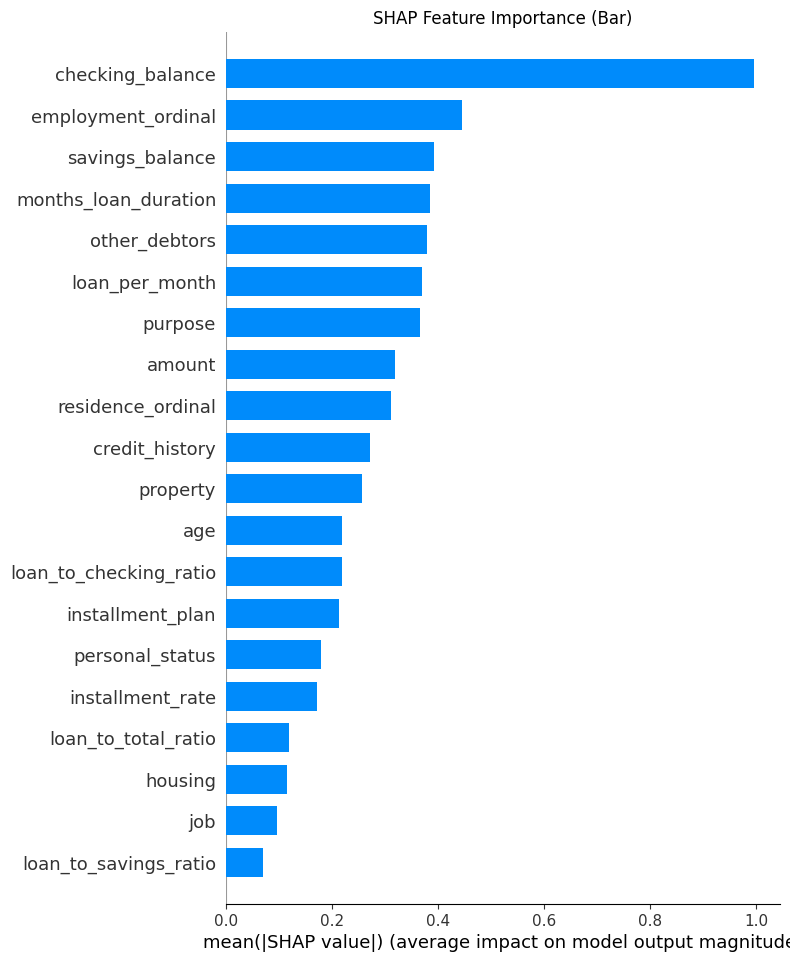


SHAP Summary Plot (Beeswarm - shows value distribution and impact):


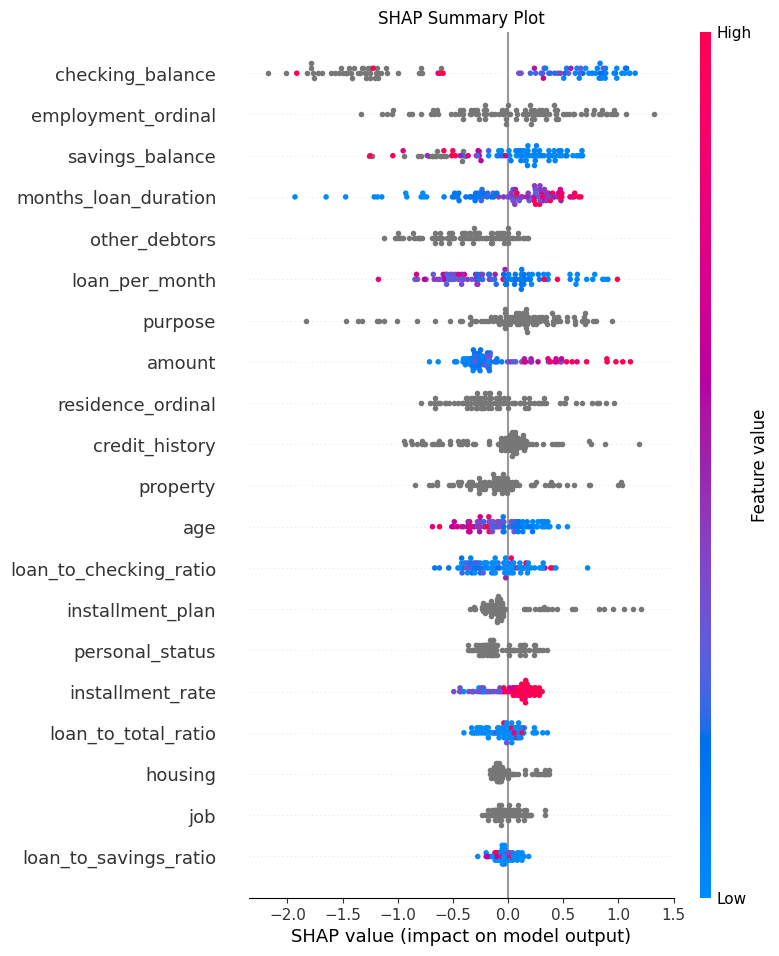


Example SHAP Explanation for Specific Instances:
(Consider using shap.force_plot or shap.waterfall_plot interactively in notebook)
Generating waterfall plots for example instances (Indices: [np.int64(338), np.int64(13)])...


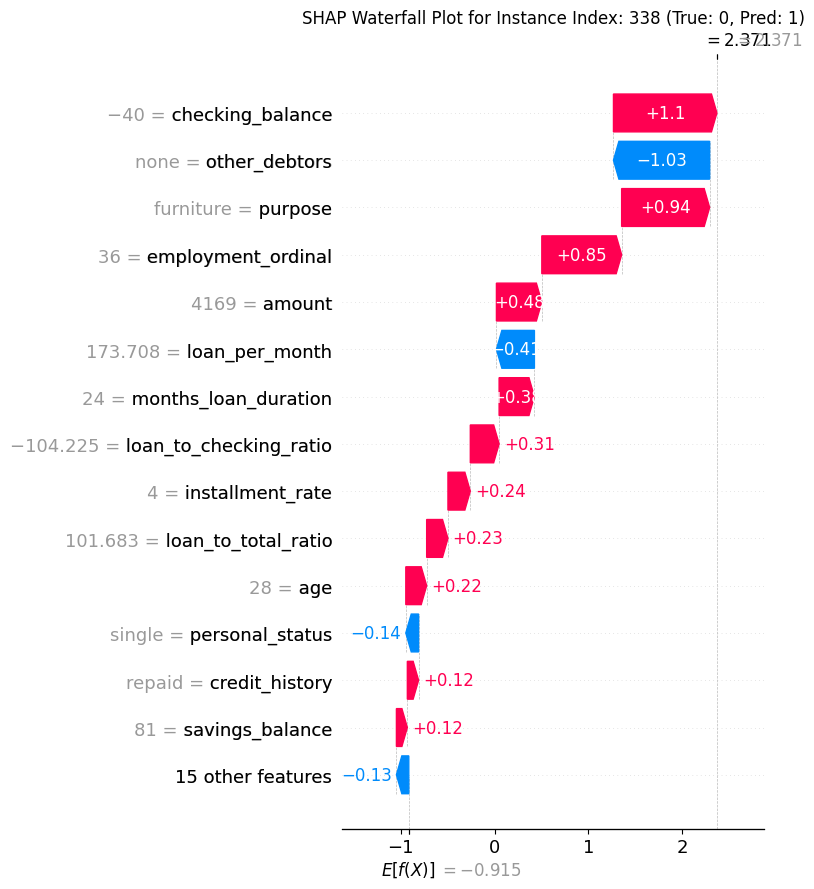

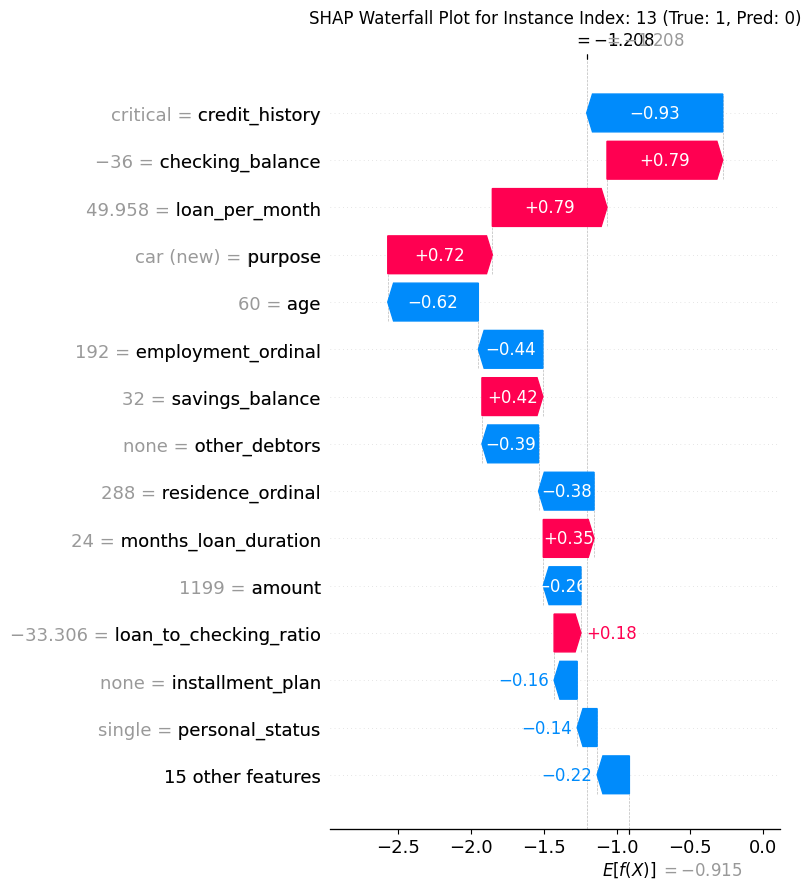


Example SHAP Explanation for Specific Instances:
Indicies to Explain for my Presentation
Generating waterfall plots for example instances (Indices: [235, 953, 347])...


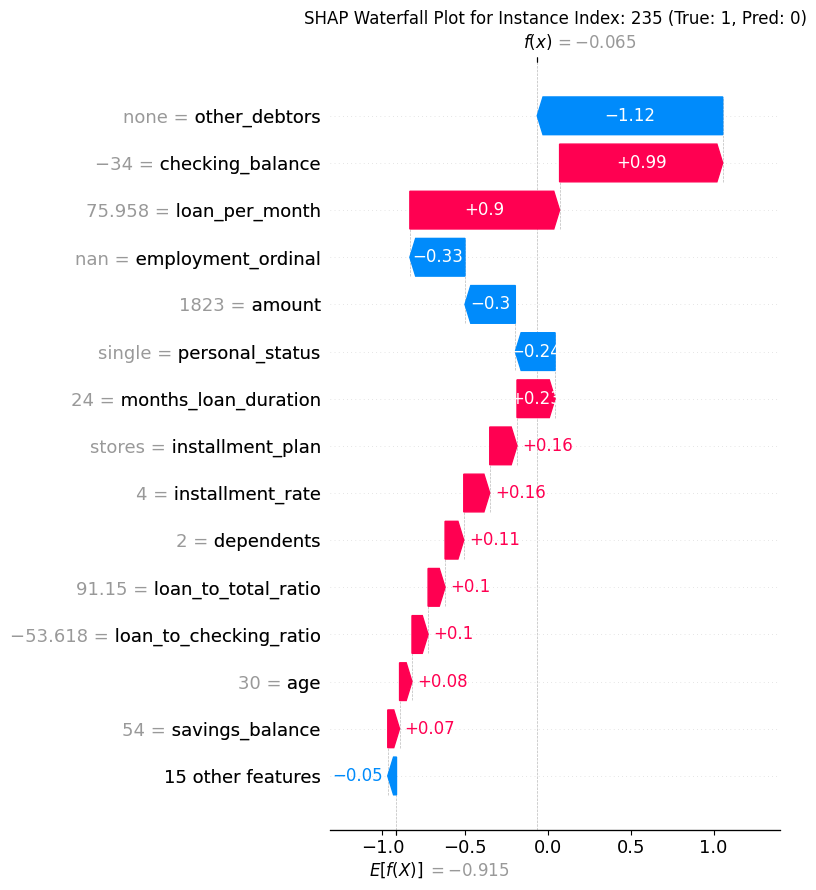

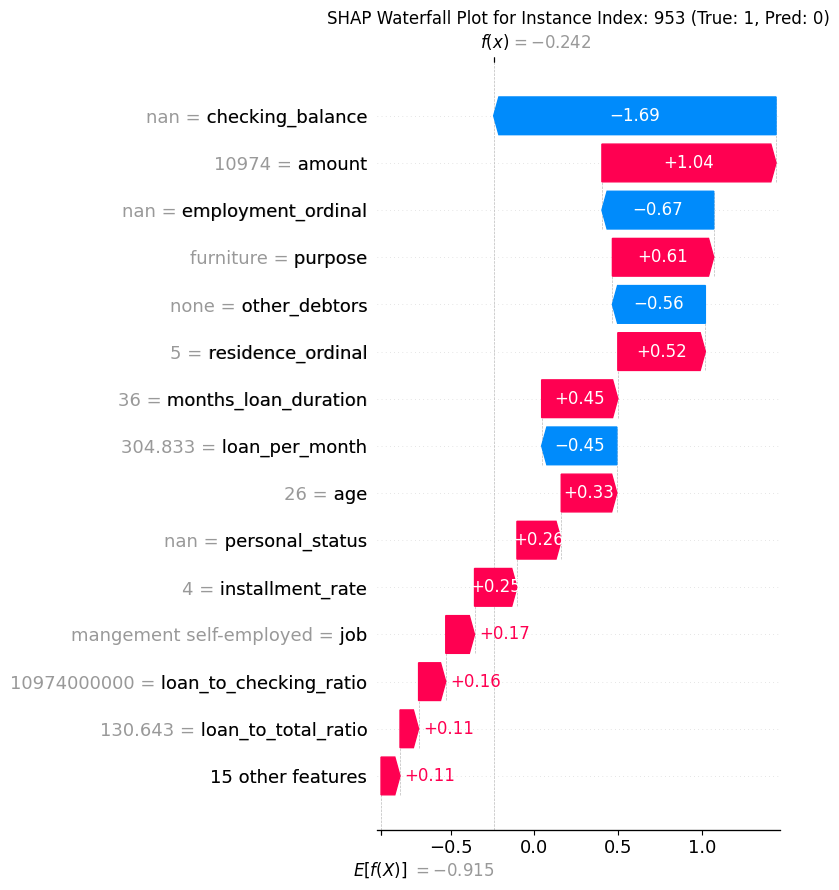

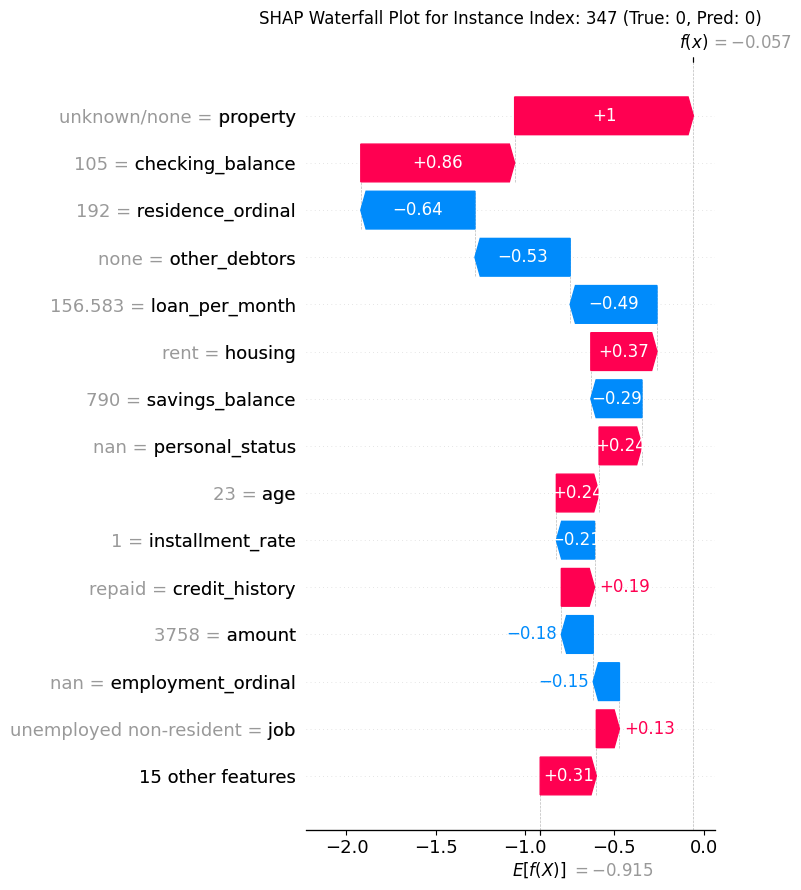


Qualitative Questions for SHAP Analysis:
- Which features have the most impact overall?
- Does the direction of impact make sense (e.g., higher income decreases default risk)?
- For specific errors, which features pushed the prediction the wrong way?
- Is the model relying on features you expect based on domain knowledge?

--- Subgroup Performance Analysis ---
Analyzing performance by subgroup based on column: 'job'

Subgroup Performance Metrics:
                       job  Count  Accuracy  True_Label_Mean  \
0  mangement self-employed     16  0.625000         0.250000   
1         skilled employee     60  0.750000         0.316667   
2  unemployed non-resident      3  1.000000         0.000000   
3       unskilled resident     21  0.857143         0.333333   

   Predicted_Label_Mean  
0              0.125000  
1              0.200000  
2              0.000000  
3              0.190476  

Qualitative Questions for Subgroup Analysis:
- Does accuracy (or other key metrics) vary signifi

In [113]:
import pandas as pd
import joblib
from sklearn.exceptions import NotFittedError # Import NotFittedError
 # Or however you load your pipeline

# --- Assume these are loaded or available ---
# loaded_pipeline: Your full, fitted training pipeline object (including the classifier)
# X_test: Your raw validation features DataFrame (the input BEFORE any processing)
# y_validation_true: Your true validation labels

# --- Obtain X_val_processed ---
try:
    # 1. Select all steps EXCEPT the last one (the classifier)
    #    The slicing `[:-1]` creates a temporary pipeline with only the transformer steps.
    preprocessing_pipeline = loaded_pipeline[:-1]

    # 2. Apply the transform methods of all preprocessing steps to the raw validation data
    print("Applying preprocessing steps to validation data...")
    X_val_processed = preprocessing_pipeline.transform(X_test)
    print("Preprocessing complete. X_val_processed generated.")

    # 3. (Optional but Recommended) Get Feature Names after transformation
    #    This is often needed for SHAP plots or detailed analysis.
    #    Requires the last step of the preprocessing pipeline to support get_feature_names_out
    #    (like ColumnTransformer or OneHotEncoder with recent sklearn).
    feature_names_processed = None
    try:
        # Access the last step of the *preprocessing part* of the pipeline
        last_preprocessor_step_name = preprocessing_pipeline.steps[-1][0] # Get name of last step
        last_preprocessor_object = preprocessing_pipeline.named_steps[last_preprocessor_step_name]

        if hasattr(last_preprocessor_object, 'get_feature_names_out'):
            feature_names_processed = last_preprocessor_object.get_feature_names_out()
            print(f"Successfully retrieved {len(feature_names_processed)} feature names after processing.")
        else:
             # If the last step doesn't have it, try converting the output to a DataFrame
             # This might work if the previous steps preserved DataFrame structure
             if isinstance(X_val_processed, pd.DataFrame):
                 feature_names_processed = X_val_processed.columns.tolist()
                 print("Retrieved feature names from DataFrame columns.")
             else:
                 print("Warning: Could not automatically retrieve feature names after processing.")
                 print("The last preprocessing step doesn't have 'get_feature_names_out'.")
                 # You might need to construct them manually based on your pipeline steps.

    except Exception as e:
        print(f"Warning: Error retrieving feature names: {e}")


    # 4. (Optional) Convert X_val_processed to DataFrame if it's a NumPy array
    #    This can make indexing easier in the analysis function, but uses more memory.
    if not isinstance(X_val_processed, pd.DataFrame) and feature_names_processed is not None:
        X_val_processed_df = pd.DataFrame(X_val_processed,
                                          columns=feature_names_processed,
                                          index=X_test.index) # Preserve original index!
        print("Converted processed data to DataFrame.")
    elif isinstance(X_val_processed, pd.DataFrame):
        X_val_processed_df = X_val_processed # It's already a DataFrame
        if feature_names_processed is None: # Try to get names if not already found
            feature_names_processed = X_val_processed_df.columns.tolist()
    else:
        # It's likely a NumPy array and feature names couldn't be retrieved
        X_val_processed_df = pd.DataFrame(X_val_processed, index=X_test.index) # Create DF without column names
        print("Warning: Processed data is likely a NumPy array, creating DataFrame without column names.")


    # --- Now you can call the analysis function ---
    print("\nCalling qualitative analysis function...")
    perform_qualitative_model_analysis(
        model=loaded_pipeline.named_steps['classifier'], # Get model from full pipeline
        X_val_processed=X_val_processed_df, # Pass the processed data (ideally DataFrame)
        y_val=y_test, # True labels for validation set
        X_val_raw=X_test,
        threshold=0.5, # Your chosen threshold
        num_samples_to_show=7,
        class_names=['No Default', 'Default'],
        subgroup_col='job',
        feature_names=feature_names_processed # Pass the retrieved feature names
    )

except AttributeError:
    print("\nError: Could not slice the pipeline. Is it a fitted Scikit-learn Pipeline object?")
except NotFittedError:
     print("\nError: The pipeline must be fitted before calling transform.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

# Bias and Fairness Evaluation

In [121]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 11.8 MB/s eta 0:00:00


In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                            f1_score, make_scorer) # Core sklearn metrics
from fairlearn.metrics import MetricFrame, count   # The core Fairlearn tool
# Import specific fairness metrics from fairlearn if needed,
# or use sklearn metrics wrapped by MetricFrame
from fairlearn.metrics import selection_rate, false_positive_rate, false_negative_rate
import warnings
from functools import partial # Useful for setting arguments in metrics

def evaluate_fairness_with_fairlearn(
    y_true,
    y_pred,
    sensitive_features: pd.Series or pd.DataFrame, # Can handle multiple sensitive features
    metric_fns: dict = None, # Allows users to specify metrics
    positive_label = 1 # Label considered "positive" outcome
    ):
    """
    Calculates and visualizes fairness metrics using fairlearn.metrics.MetricFrame.

    Compares performance across groups defined by sensitive attributes.

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Predicted target values (class labels).
        sensitive_features (pd.Series or pd.DataFrame): Contains the sensitive attribute(s)
                                                      values (e.g., gender, race, job).
                                                      Must have the same index as y_true/y_pred.
        metric_fns (dict, optional): A dictionary where keys are metric names (str) and
                                     values are callable metric functions (e.g., from
                                     sklearn.metrics or fairlearn.metrics).
                                     If None, uses a default set including accuracy, recall,
                                     precision, selection rate, FPR, FNR.
                                     Defaults to None.
        positive_label (int or str): The value in y_true/y_pred representing the positive outcome.
                                     Needed for metrics like recall, precision, fpr, fnr.
                                     Defaults to 1.

    Returns:
        fairlearn.metrics.MetricFrame: The MetricFrame object containing overall results,
                                       results by group, and disparity metrics/methods.
                                       Returns None if an error occurs.
    """
    print("--- Bias and Fairness Evaluation using Fairlearn ---")

    # --- Input Validation ---
    if not isinstance(sensitive_features, (pd.Series, pd.DataFrame)):
        raise TypeError("sensitive_features must be a pandas Series or DataFrame.")
    if not (y_true.shape[0] == y_pred.shape[0] == sensitive_features.shape[0]):
         raise ValueError("Inputs y_true, y_pred, and sensitive_features must have the same number of samples.")
    if isinstance(y_true, pd.Series) and not y_true.index.equals(sensitive_features.index):
         warnings.warn("Indices of y_true and sensitive_features do not match. Ensure alignment.")


    # --- Define Default Metrics if None Provided ---
    if metric_fns is None:
        # Use partial to preset arguments like positive_label and zero_division
        recall_positive = partial(recall_score, pos_label=positive_label, zero_division=0)
        precision_positive = partial(precision_score, pos_label=positive_label, zero_division=0)
        f1_positive = partial(f1_score, pos_label=positive_label, zero_division=0)

        metric_fns = {
            'accuracy': accuracy_score,
            'recall': recall_positive, # TPR for positive_label
            'precision': precision_positive, # PPV for positive_label
            'f1_score': f1_positive, # F1 for positive_label
            'selection_rate': selection_rate, # Rate of positive predictions
            'fpr': partial(false_positive_rate, pos_label=positive_label), # Fairlearn's FPR
            'fnr': partial(false_negative_rate, pos_label=positive_label), # Fairlearn's FNR
            'count': count, # Sample count per group
        }
        print("Using default set of metrics: accuracy, recall, precision, f1_score, selection_rate, fpr, fnr, count")


    # --- Calculate Metrics using MetricFrame ---
    try:
        print("Calculating metrics by group using MetricFrame...")

        # MetricFrame handles grouping and calculations automatically
        grouped_on_sensitive = MetricFrame(metrics=metric_fns,
                                           y_true=y_true,
                                           y_pred=y_pred,
                                           sensitive_features=sensitive_features)

        # Extract results
        metrics_by_group = grouped_on_sensitive.by_group
        overall_metrics = grouped_on_sensitive.overall

        print("\n--- Overall Metrics ---")
        print(overall_metrics)

        print("\n--- Metrics by Group ---")
        print(metrics_by_group)

        # --- Calculate and Print Disparities ---
        if isinstance(metrics_by_group.index, pd.MultiIndex) or len(metrics_by_group) > 1:
            print("\n--- Metric Disparities (Difference: Max - Min) ---")
            metric_diffs = grouped_on_sensitive.difference(method='between_groups')
            print(metric_diffs)

            # Example: Calculate Ratio (Min / Max) - closer to 1 is better
            # Useful for things like the 80% rule for selection rate
            print("\n--- Metric Disparities (Ratio: Min / Max) ---")
            with warnings.catch_warnings(): # Suppress potential division by zero warnings from fairlearn ratio calculation
                warnings.simplefilter("ignore", category=RuntimeWarning)
                metric_ratios = grouped_on_sensitive.ratio(method='between_groups')
            print(metric_ratios)


        # --- Visualization ---
        print("\n--- Visualizing Metrics by Group ---")
        try:
             # Plotting each metric by group
             metrics_to_plot = list(metric_fns.keys())
             n_metrics = len(metrics_to_plot)
             n_cols = 3 # Adjust layout as needed
             n_rows = (n_metrics + n_cols - 1) // n_cols

             fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
             axes = axes.flatten()

             sensitive_feature_name = sensitive_features.name if isinstance(sensitive_features, pd.Series) else 'Group Combination'

             for i, metric_name in enumerate(metrics_to_plot):
                 if metric_name in metrics_by_group.columns:
                     # Plot the metric for each group
                     metrics_by_group[metric_name].plot(kind='bar', ax=axes[i], title=metric_name, rot=45)
                     axes[i].set_ylabel("Metric Value")
                     axes[i].set_xlabel(sensitive_feature_name) # Label x-axis with sensitive feature name
                     axes[i].yaxis.grid(True, linestyle='--', alpha=0.6)
                 else:
                      axes[i].set_visible(False) # Hide if metric wasn't calculated (e.g., error)


             # Hide any remaining unused axes
             for j in range(i + 1, len(axes)):
                 axes[j].set_visible(False)

             plt.suptitle(f'Fairness Metrics Comparison across "{sensitive_feature_name}" Groups', fontsize=16, y=1.03)
             plt.tight_layout()
             plt.show()

        except Exception as plot_err:
             print(f"Error during visualization: {plot_err}")


        print("\n--- End Bias and Fairness Evaluation ---")
        return grouped_on_sensitive # Return the MetricFrame object

    except Exception as e:
        print(f"\nERROR during Fairlearn MetricFrame calculation: {e}")
        return None




In [125]:
y_validation_pred = pd.Series(predictions)

--- Bias and Fairness Evaluation using Fairlearn ---
Calculating metrics by group using MetricFrame...

--- Overall Metrics ---
accuracy            0.760000
recall              0.400000
precision           0.666667
f1_score            0.500000
selection_rate      0.180000
fpr                 0.085714
fnr                 0.600000
count             100.000000
dtype: float64

--- Metrics by Group ---
        accuracy    recall  precision  f1_score  selection_rate       fpr  \
gender                                                                      
female  0.680000  0.444444   0.571429       0.5        0.280000  0.187500   
male    0.786667  0.380952   0.727273       0.5        0.146667  0.055556   

             fnr  count  
gender                   
female  0.555556   25.0  
male    0.619048   75.0  

--- Metric Disparities (Difference: Max - Min) ---
accuracy           0.106667
recall             0.063492
precision          0.155844
f1_score           0.000000
selection_rate     0.1

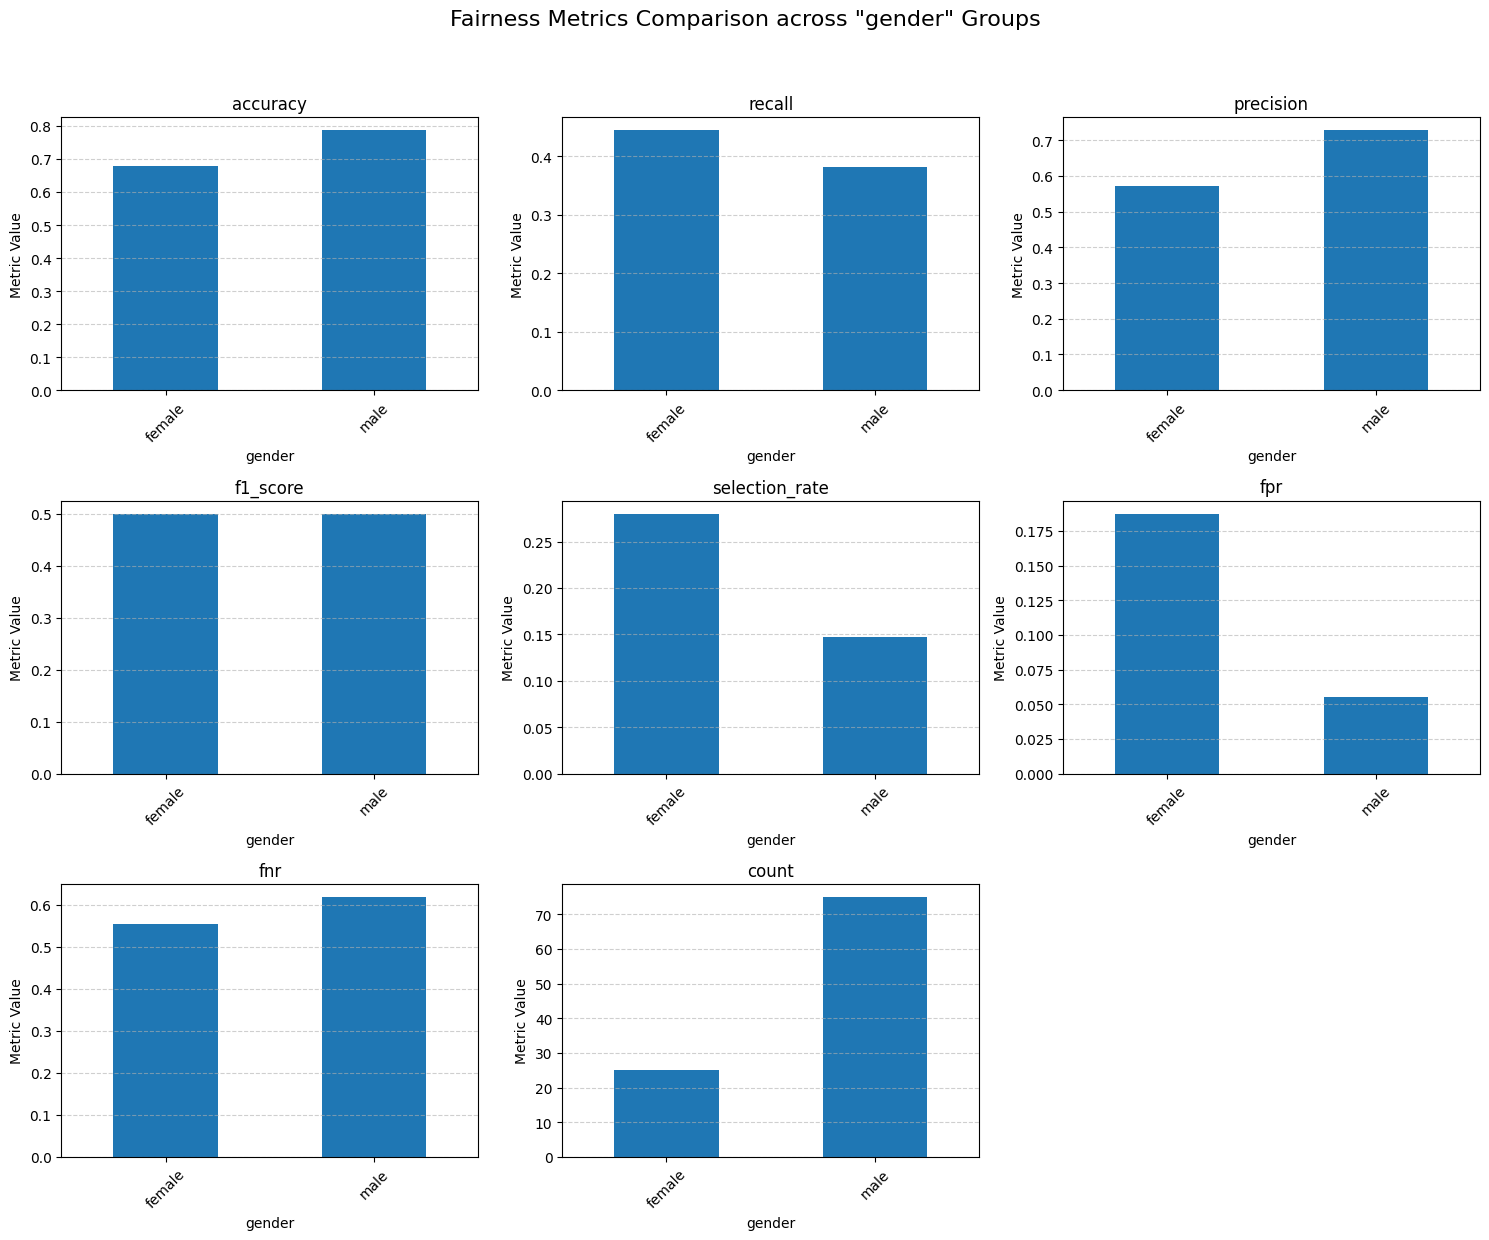


--- End Bias and Fairness Evaluation ---

Accessing results programmatically:
Overall Accuracy: 0.76
Accuracy by Group:
 gender
female    0.680000
male      0.786667
Name: accuracy, dtype: float64
Accuracy Difference: 0.10666666666666658
Selection Rate Ratio: 0.5238095238095237


In [126]:
# --- Example Usage ---

# # Assume you have:
# y_validation_true: True validation labels (e.g., pd.Series)
# y_validation_pred: Predicted validation labels (e.g., np.array or pd.Series)
# X_validation_original_features: DataFrame containing raw features including sensitive attributes

positive_label = 1
# # Define the sensitive attribute(s) - must be a Series or DataFrame with matching index
sensitive_col_name = 'gender'

if sensitive_col_name in test_df.columns: # Use X_test instead of test_df
    sensitive_attrs = test_df[sensitive_col_name] # Use X_test instead of test_df
    # No need for resetting the index because X_test and y_test were created using the same split

    # Run the evaluation
    metric_frame_results = evaluate_fairness_with_fairlearn(
        y_true=y_test,
        y_pred=y_validation_pred,
        sensitive_features=sensitive_attrs,
        positive_label=1, # Adjust if your positive label is different
        metric_fns = {
            'accuracy': accuracy_score,
            'recall': partial(recall_score, pos_label=positive_label, zero_division=0), # TPR for positive_label
            'precision': partial(precision_score, pos_label=positive_label, zero_division=0), # PPV for positive_label
            'f1_score': partial(f1_score, pos_label=positive_label, zero_division=0), # F1 for positive_label
            'selection_rate': selection_rate, # Rate of positive predictions
            'fpr': partial(false_positive_rate, pos_label=positive_label), # Fairlearn's FPR
            'fnr': partial(false_negative_rate, pos_label=positive_label), # Fairlearn's FNR
            'count': count, # Sample count per group
        }
    )

    # You can access results programmatically from metric_frame_results if needed
    if metric_frame_results:
        print("\nAccessing results programmatically:")
        print("Overall Accuracy:", metric_frame_results.overall['accuracy'])
        print("Accuracy by Group:\n", metric_frame_results.by_group['accuracy'])
        print("Accuracy Difference:", metric_frame_results.difference()['accuracy'])
        print("Selection Rate Ratio:", metric_frame_results.ratio()['selection_rate'])
else:
    print(f"Sensitive attribute column '{sensitive_col_name}' not found.")